In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
import ruptures as rpt
from scipy.signal import find_peaks
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
from sklearn.decomposition import PCA as SKPCA
import math
import os


## Where to change the patient file path

In [115]:
sub = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_03_23_2023_LSTN_subject2\Processed DLC\csv folder')

## Patient Specific Items

In [119]:
# use this if one trial is incomplete or does not work well
# only put the depth with no front or side
skip_trails = ['t1']

## Functions

In [5]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0


    # (Optional) Reset index or drop NaNs if needed
    # cleaned_df = cleaned_df.dropna(subset=marker_names)  # if you want to drop completely bad rows

    # cleaned_df now has cleaned x/y data based on per-marker likelihoods

    cleaned_df


    return cleaned_df

In [96]:
def run_PCA(X, indices, n_components=None):
    '''Calculates PCA for one camera view and one probe position'''

    # 1. Takes into consideration if there are indices or not (helpful for when looking at specific movement)
    if indices is not None:
        X_subset = X.iloc[indices[0]:indices[1]+1]
    else:
        X_subset = X

    # 2. Drop columns containing '.2' --> dropping likelihood rows
    df = X_subset.loc[:, ~X_subset.columns.str.contains(r'\.2')]

    # 3. Remove constant columns --> gets rid of runs that were unsuccessful 
    stds = df.std(axis=0)
    df = df.loc[:, stds != 0]

    # 4. Standardize the data --> standardize mean to 0 and std to 1 (suggested from geeks for geeks)
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(df)

    # 5. Apply PCA
    pca = SKPCA(n_components=n_components)
    X_pca = pca.fit_transform(X_standardized)

    # 6. Output
    explained_variance_ratio = pca.explained_variance_ratio_
    explained_variance = pca.explained_variance_
    pca_components = pca.components_ # direction (vectors) the define the PCs in the original feature space pca_components[0] are the scores in regards to PCA1



    return X_pca, explained_variance_ratio, explained_variance, pca_components


def trim_initial_zeros(df):
    """
    Trims the DataFrame by removing rows at the beginning where ANY column is 0.
    Once all columns have non-zero values, keeps everything from that row on.
    Necessary because rows were set to 0 when filtering likelihood
    """
    mask = (df != 0).any(axis=1)
    first_valid_index = mask.idxmax()  # first row where any column is non-zero
    return df.loc[first_valid_index:].reset_index(drop=True)

In [95]:
def gauss_smooth_uniform(yin, dt, gkern_std):
    """
    Smooth 'yin' using a Gaussian filter via convolution.
    
    Parameters:
        yin : numpy array of signal values
        dt : time step between samples (e.g., 0.001 for 1kHz)
        gkern_std : Gaussian kernel std in time units (e.g., 0.05s)
    
    """
    # Convert gkern_std from time units to number of samples
    sigma_samples = gkern_std / dt
    yout = gaussian_filter1d(yin, sigma=sigma_samples, mode='reflect')
    return yout

In [103]:
def reports_PC1(df, indices):
    '''takes in a dataframe and indices and reports back PC1'''

    start = indices[0]
    end = indices[1]

    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(df, (start, end), n_components=None)
    
    pc1_values = X_pca[:, 0]

    pc1_features = components[0]

    return pc1_values, pc1_features

    


In [109]:
def hand_PS_mov(df, t, slope_threshold=0.05, window=5):
    '''reports the peaks and the troughs'''

    # --- Signal extraction ---
    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    pc1, pc1_features = reports_PC1(df, (start_idx, end_idx))
    pc1 = gauss_smooth_uniform(pc1, 0.01, 0.05)
    t_np = np.arange(start_idx, end_idx)

    # --- Peak & Trough Detection ---
    peaks, _ = find_peaks(pc1, height=None, prominence=5, width=5)
    troughs, _ = find_peaks(-pc1, distance=None, prominence=5, width=5)

    # --- Boundary Filter ---
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    # --- Time Mapping ---
    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, pc1


In [108]:
def arm_EF_mov(df, t):
    '''reports the peaks and troughs'''

    # --- Signal extraction ---
    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    pc1, pc1_features = reports_PC1(df, (start_idx, end_idx))
    pc1 = gauss_smooth_uniform(pc1, 0.01, 0.05)
    t_np = np.arange(start_idx, end_idx)

    # --- Peak & Trough Detection ---
    peaks, _ = find_peaks(pc1, height=None, prominence=5, width=5)
    troughs, _ = find_peaks(-pc1, distance=None, prominence=5, width=5)

    # --- Boundary Filter ---
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    # --- Time Mapping ---
    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, pc1

In [105]:
def hand_OC_mov(df, t):
    '''
    Reports the peaks and troughs from the Euclidean distance.
    '''

    # --- Signal extraction ---
    start_idx = int(t[0])
    end_idx = int(t[-1]) + 1

    pc1, pc1_features = reports_PC1(df, (start_idx, end_idx))
    pc1 = gauss_smooth_uniform(pc1, 0.01, 0.05)
    t_np = np.arange(start_idx, end_idx)

    # --- Peak & Trough Detection ---
    peaks, _ = find_peaks(pc1, height=None, prominence=5, width=5)
    troughs, _ = find_peaks(-pc1, distance=None, prominence=5, width=5)

    # --- Boundary Filter ---
    peaks = peaks[peaks < len(t_np)]
    troughs = troughs[troughs < len(t_np)]

    # --- Time Mapping ---
    t_peak = t_np[peaks]
    t_trough = t_np[troughs]

    return t_peak, t_trough, pc1


In [ ]:
def compute_peaks_troughs(row):
    base = row['dataset']  # like 'b1', 't2', etc.
    view = row['view']     # 'front' or 'side'

    if view == 'side':
        return None  # Skip side views early exit

    try:
        dff = dataframes.get(base + 'f')
        hand_OC_peaks, hand_OC_troughs, hand_OC_euclidean = hand_OC_mov(dff, row['hand_OC'])
        hand_PS_peaks, hand_PS_troughs, hand_PS_euclidean = hand_PS_mov(dff, row['hand_PS'])
        arm_EF_peaks, arm_EF_troughs, arm_EF_data = arm_EF_mov(dff, row['arm_EF'])

        # Ensure integer arrays for indexing later
        hand_OC_peaks = np.array(hand_OC_peaks, dtype=int)
        hand_OC_troughs = np.array(hand_OC_troughs, dtype=int)
        hand_PS_peaks = np.array(hand_PS_peaks, dtype=int)
        hand_PS_troughs = np.array(hand_PS_troughs, dtype=int)
        arm_EF_peaks = np.array(arm_EF_peaks, dtype=int)
        arm_EF_troughs = np.array(arm_EF_troughs, dtype=int)

        # Return Series with all front-view metrics
        return pd.Series({
            'hand_OC_peaks': hand_OC_peaks,
            'hand_OC_troughs': hand_OC_troughs,
            'hand_OC_euclidean_dis': hand_OC_euclidean,
            'hand_PS_peaks': hand_PS_peaks,
            'hand_PS_troughs': hand_PS_troughs,
            'hand_PS_euclidean_dis': hand_PS_euclidean,
            'arm_EF_peaks': arm_EF_peaks,
            'arm_EF_troughs': arm_EF_troughs,
            'arm_EF_data': arm_EF_data
        })

    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        # Return a Series filled with None for all expected outputs
        return pd.Series({
            'hand_OC_peaks': None, 'hand_OC_troughs': None, 'hand_OC_euclidean_dis': None,
            'hand_PS_peaks': None, 'hand_PS_troughs': None,
            'arm_EF_peaks': None, 'arm_EF_troughs': None
        })

In [77]:
def average_close_indices(index_list, threshold):
    if not index_list:
        return []

    averaged = []
    current_group = [index_list[0]]

    for i in range(1, len(index_list)):
        if abs(index_list[i] - sum(current_group)/len(current_group)) <= threshold:
            current_group.append(index_list[i])
        else:
            # Commit the average of the current group
            averaged.append(int(sum(current_group)/len(current_group)))
            # Start new group
            current_group = [index_list[i]]

    # Don't forget the last group
    averaged.append(int(sum(current_group)/len(current_group)))
    return averaged


In [13]:
def gauss_smooth_uniform(yin, dt, gkern_std):
    """
    Smooth 'yin' using a Gaussian filter via convolution.
    
    Parameters:
        yin : numpy array of signal values
        dt : time step between samples (e.g., 0.001 for 1kHz)
        gkern_std : Gaussian kernel std in time units (e.g., 0.05s)
    
    """
    # Convert gkern_std from time units to number of samples
    sigma_samples = gkern_std / dt
    yout = gaussian_filter1d(yin, sigma=sigma_samples, mode='reflect')
    return yout


## Creates dataframes for each depth

In [117]:
# List of base labels (subject-depth identifiers)
base_labels = ['b1', 'b2', 'b3', 'c1', 'c2', 'c3', 't1', 't2', 't3']

# Place to store all the DataFrames
dataframes = {}

files = list(sub.iterdir())

# First, filter out LC2 files
valid_files = [file for file in files if 'LC2' not in file.name]

# Iterate through all files and match them
for file in valid_files:
    filename = file.name.lower()

    # Find which base label (b1, b2, etc.) is in the filename
    base_label = None
    for base in base_labels:
        if base in filename:
            base_label = base
            break

    if base_label is None:
        print(f"Skipping file (no base label match): {filename}")
        continue  # Skip files without a base label match

    # Determine if it's front or side view
    if 'front' in filename:
        suffix = 'f'
    elif 'side' in filename:
        suffix = 's'
    else:
        print(f"Skipping file (no view info): {filename}")
        continue  # Skip files without view info

    # Construct full label (e.g., 'b1f', 'c2s')
    label = base_label + suffix

    # Load and store in dictionary
    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")



     bodyparts StablePoint StablePoint.1 StablePoint.2   PalmBase PalmBase.1  \
0       coords           x             y    likelihood          x          y   
1            0   312.37256     90.169426     0.9454463  267.89175  287.26443   
2            1    312.2302      90.40724     0.9373964  265.75037  284.86755   
3            2   312.24457      90.30127    0.93601197  265.21674   284.9264   
4            3   311.87827      90.29879     0.9441474  265.31732   286.3712   
...        ...         ...           ...           ...        ...        ...   
1327      1326   312.79306      90.74159     0.9609104   294.0356  367.53326   
1328      1327    312.6162      91.11673    0.96110815  293.51898   368.3171   
1329      1328   312.80075      90.77604     0.9515535   293.1958  368.65656   
1330      1329   312.35977      90.99973     0.9514125  293.29675   368.7996   
1331      1330   312.43835     90.826546     0.9502585  293.31845  368.52686   

      PalmBase.2       MCP1     MCP1.1 

## Runs PCA and ruptures on PC1 and PC2 to create df_indices

For b1f the variance for PC1 is 0.4678 and PC2 is 0.3294


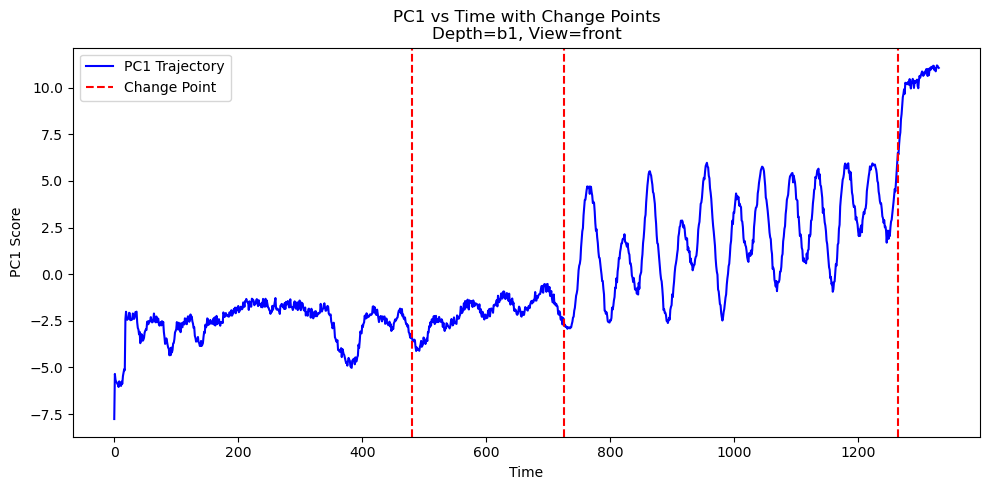

Change points (frame indices) for b1 front: [480, 725, 1265, 1331]
For b1s the variance for PC1 is 0.5358 and PC2 is 0.3451


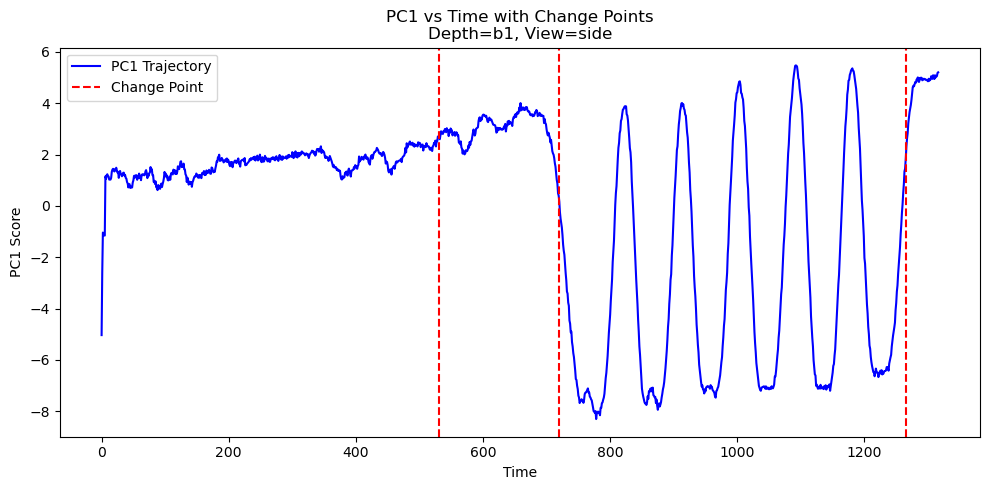

Change points (frame indices) for b1 side: [530, 720, 1265, 1317]
For b2f the variance for PC1 is 0.5426 and PC2 is 0.1947


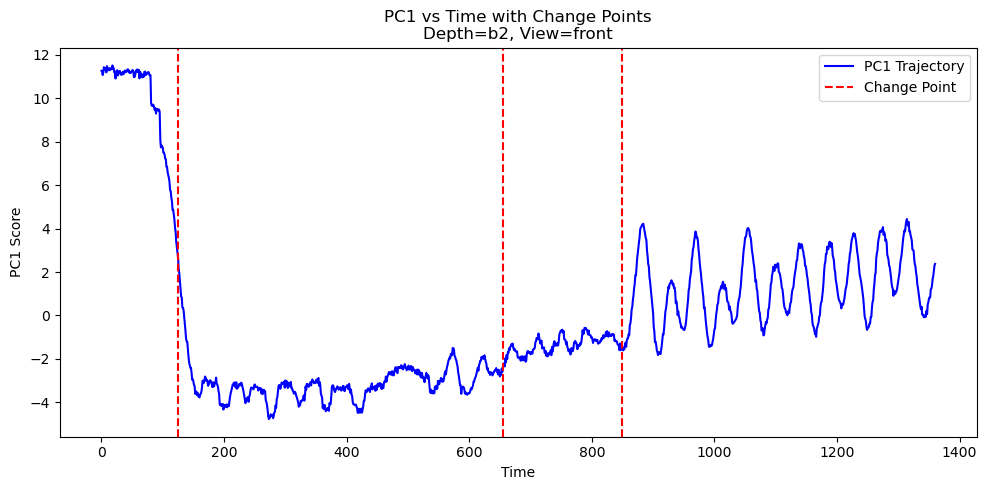

Change points (frame indices) for b2 front: [125, 655, 850, 1361]
For b2s the variance for PC1 is 0.4566 and PC2 is 0.4208


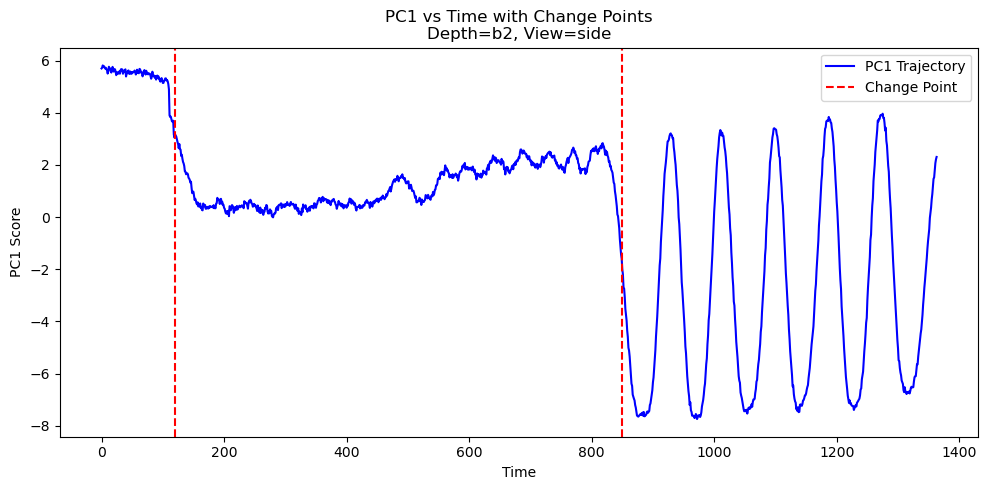

Change points (frame indices) for b2 side: [120, 850, 1364]
For b3f the variance for PC1 is 0.4582 and PC2 is 0.2881


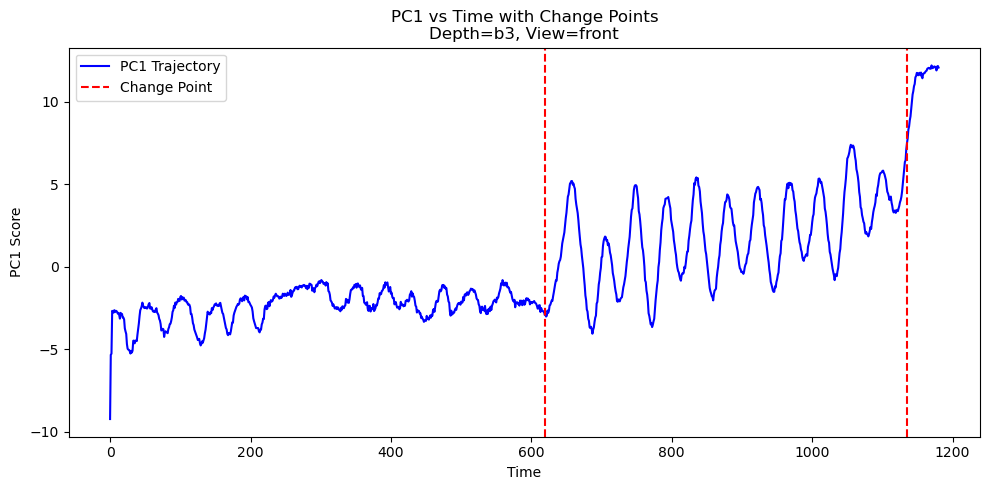

Change points (frame indices) for b3 front: [620, 1135, 1181]
For b3s the variance for PC1 is 0.4753 and PC2 is 0.3762


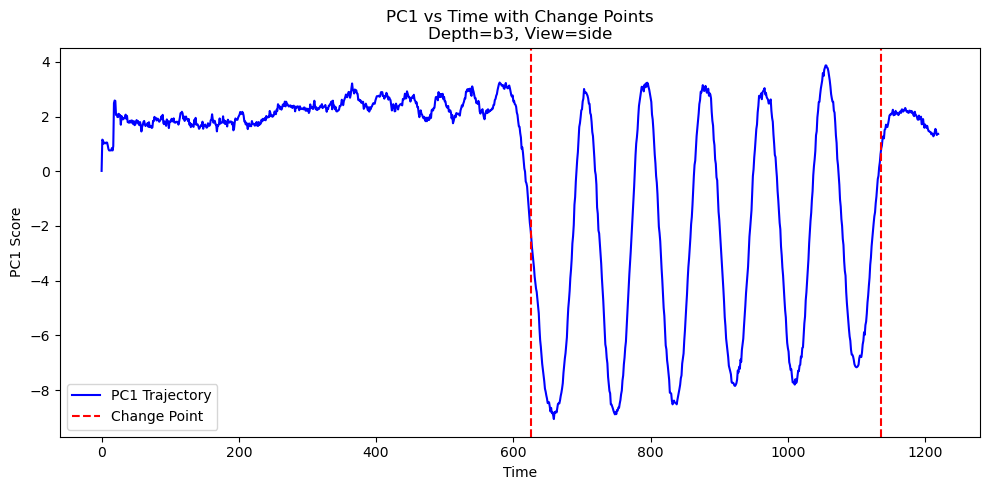

Change points (frame indices) for b3 side: [625, 1135, 1220]
For c1f the variance for PC1 is 0.4739 and PC2 is 0.2527


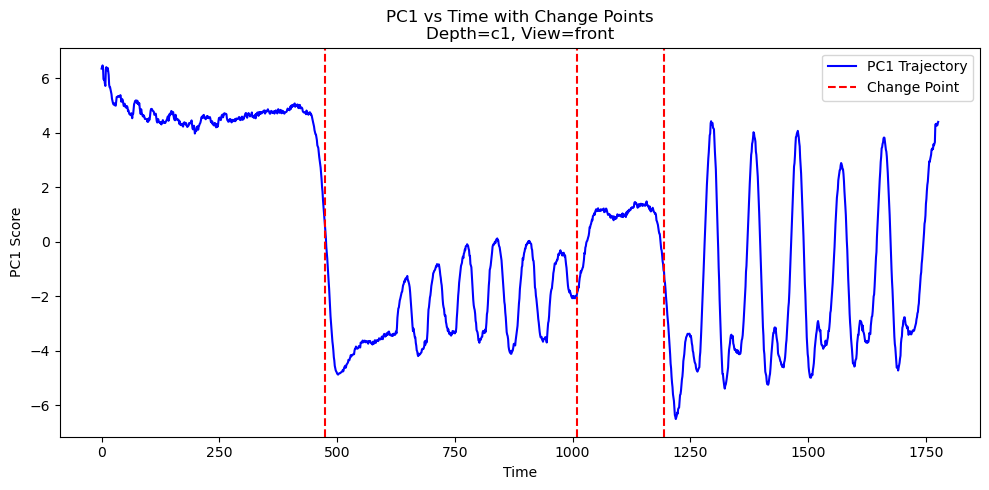

Change points (frame indices) for c1 front: [475, 1010, 1195, 1777]
For c1s the variance for PC1 is 0.4621 and PC2 is 0.3768


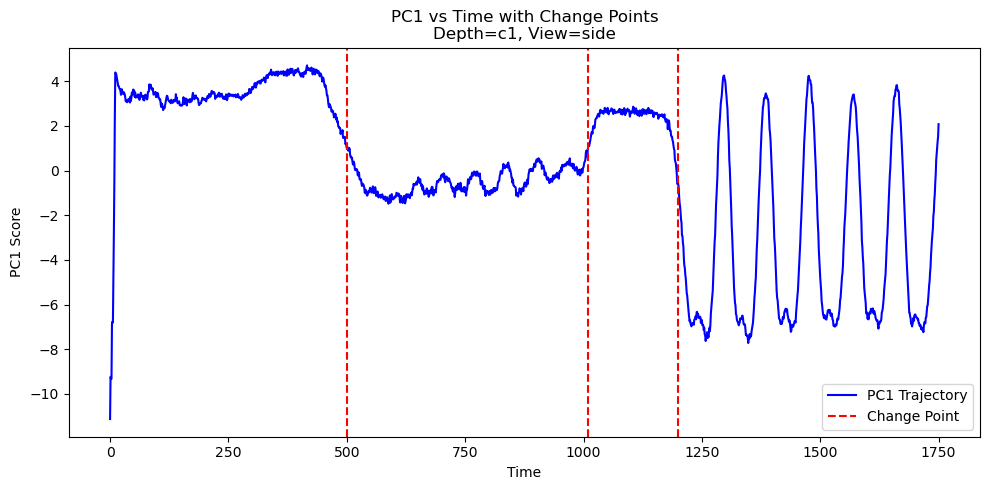

Change points (frame indices) for c1 side: [500, 1010, 1200, 1751]
For c2f the variance for PC1 is 0.5669 and PC2 is 0.2161


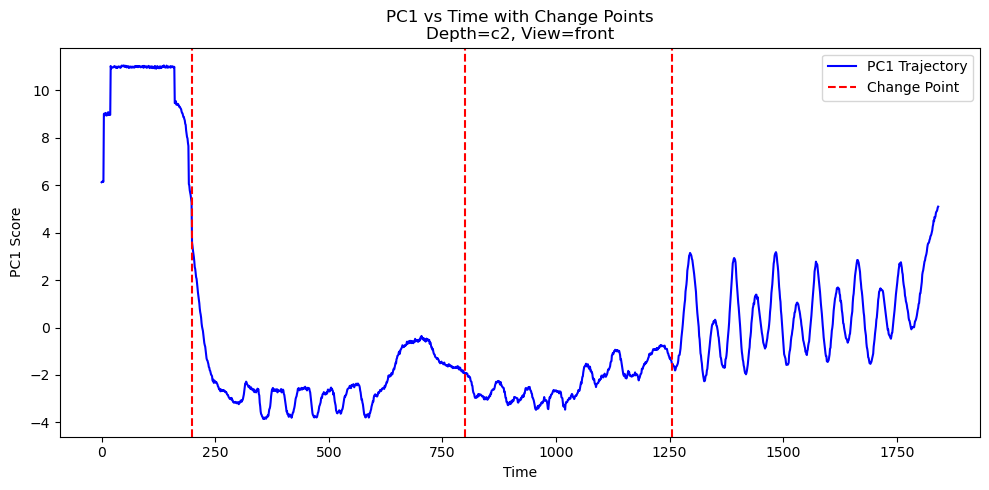

Change points (frame indices) for c2 front: [200, 800, 1255, 1842]
For c2s the variance for PC1 is 0.5440 and PC2 is 0.3244


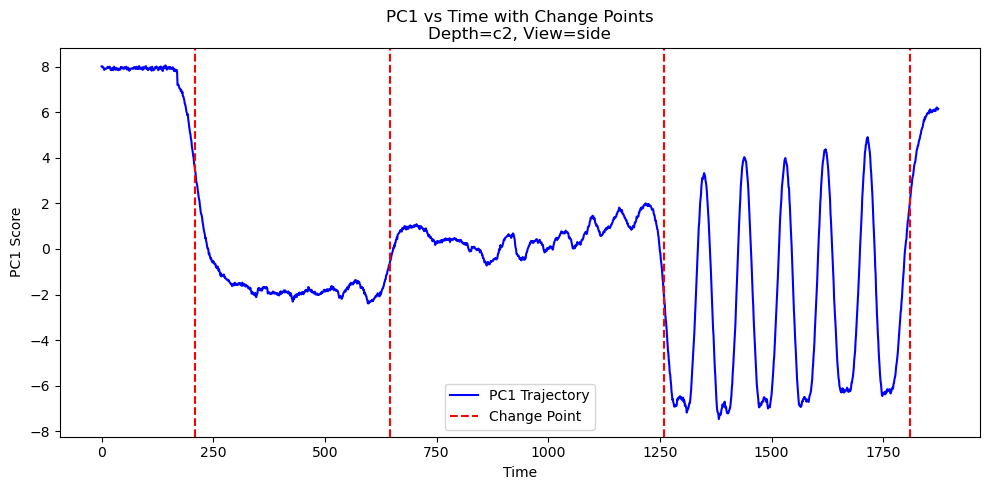

Change points (frame indices) for c2 side: [210, 645, 1260, 1810, 1874]
For c3f the variance for PC1 is 0.5081 and PC2 is 0.2415


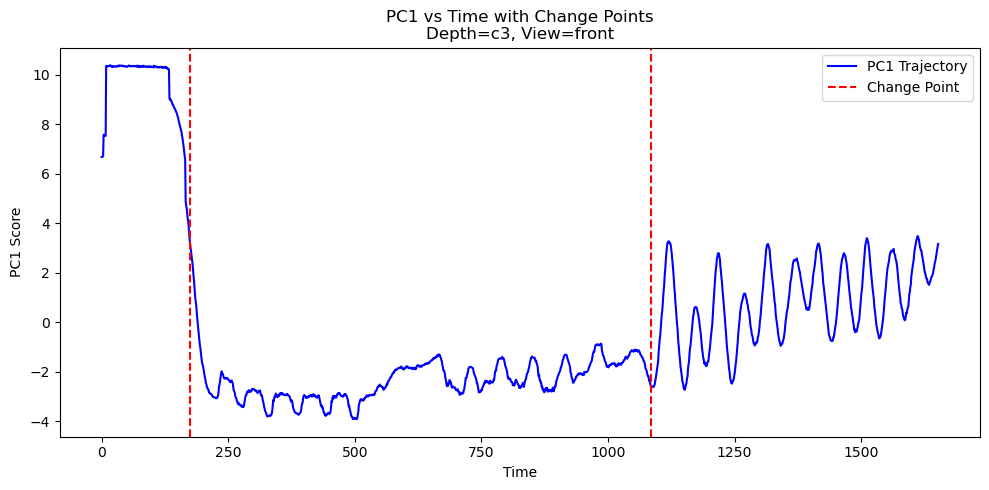

Change points (frame indices) for c3 front: [175, 1085, 1653]
For c3s the variance for PC1 is 0.5615 and PC2 is 0.3199


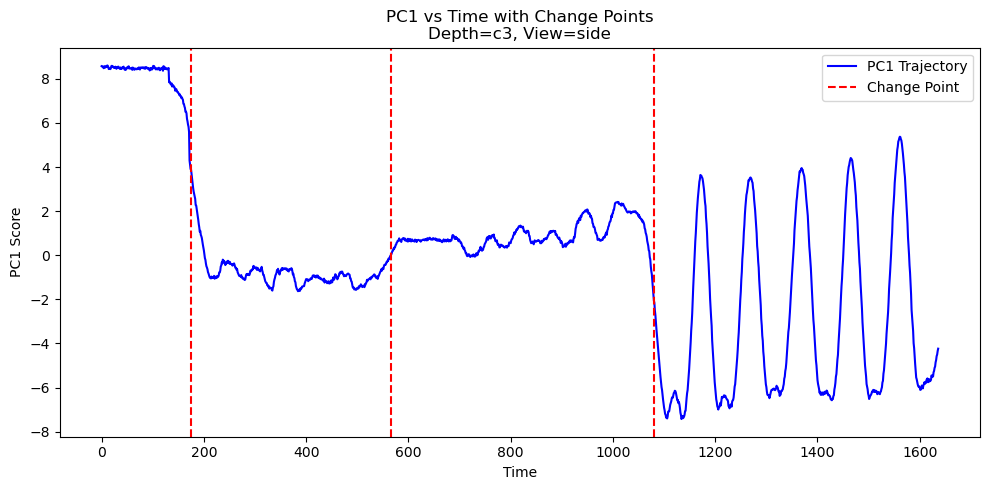

Change points (frame indices) for c3 side: [175, 565, 1080, 1637]
For t1f the variance for PC1 is 0.7115 and PC2 is 0.1000


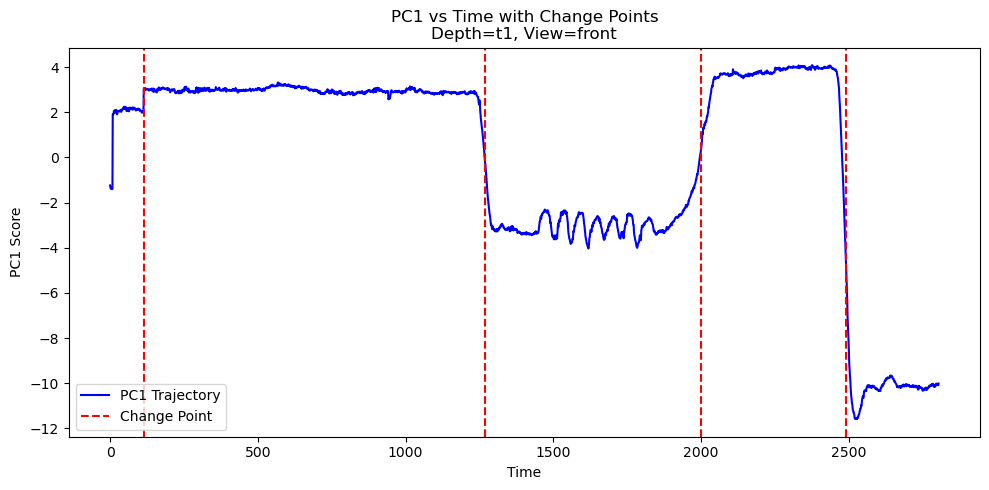

Change points (frame indices) for t1 front: [115, 1270, 2000, 2490, 2805]
For t1s the variance for PC1 is 0.5853 and PC2 is 0.2542


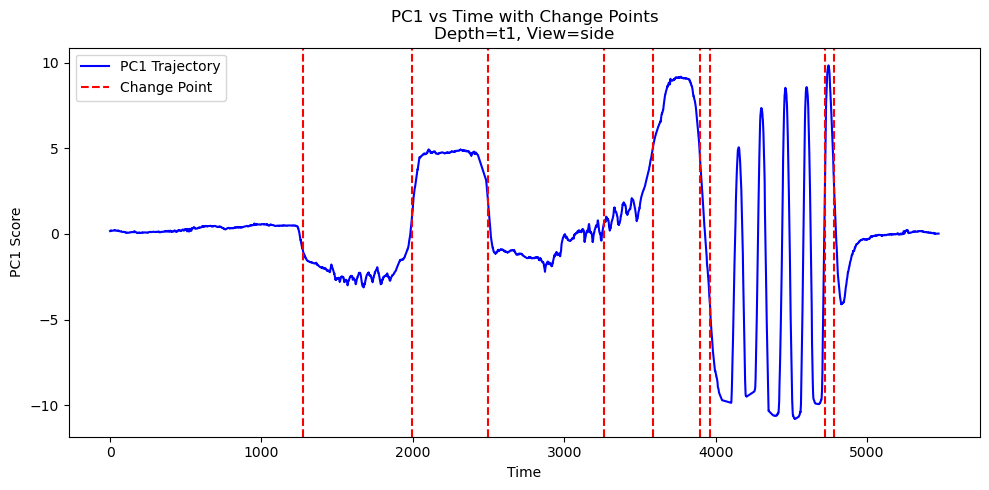

Change points (frame indices) for t1 side: [1275, 1995, 2495, 3260, 3585, 3900, 3965, 4720, 4785, 5474]
For t2f the variance for PC1 is 0.5471 and PC2 is 0.1888


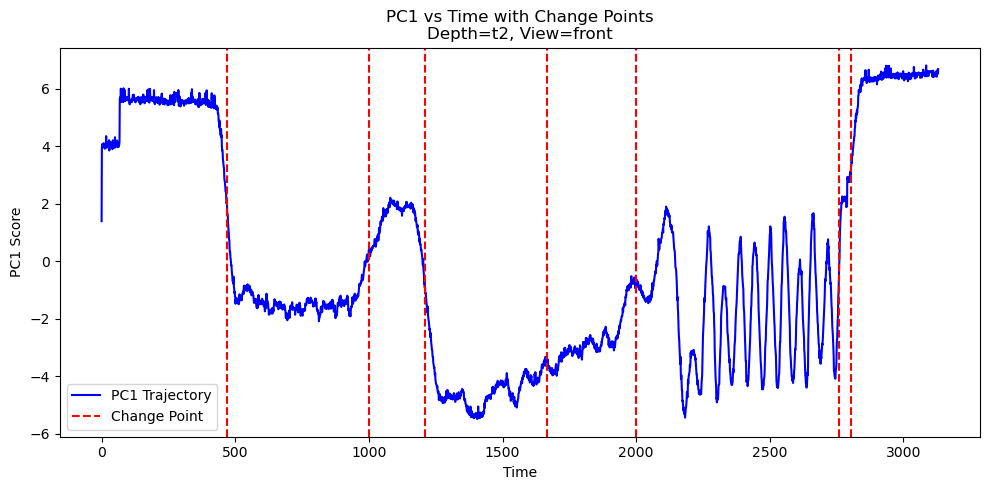

Change points (frame indices) for t2 front: [470, 1000, 1210, 1665, 2000, 2760, 2805, 3131]
For t2s the variance for PC1 is 0.5390 and PC2 is 0.3010


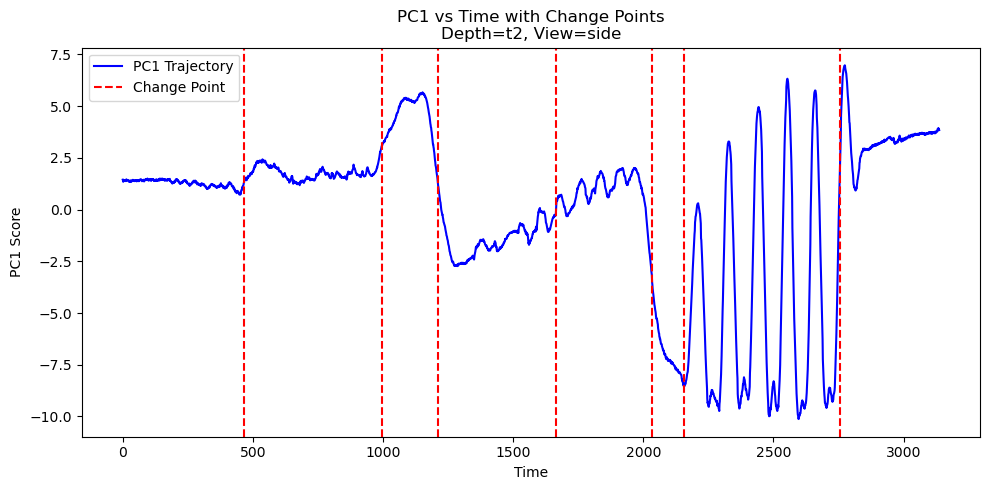

Change points (frame indices) for t2 side: [465, 995, 1210, 1665, 2035, 2155, 2755, 3138]
For t3f the variance for PC1 is 0.5325 and PC2 is 0.1649


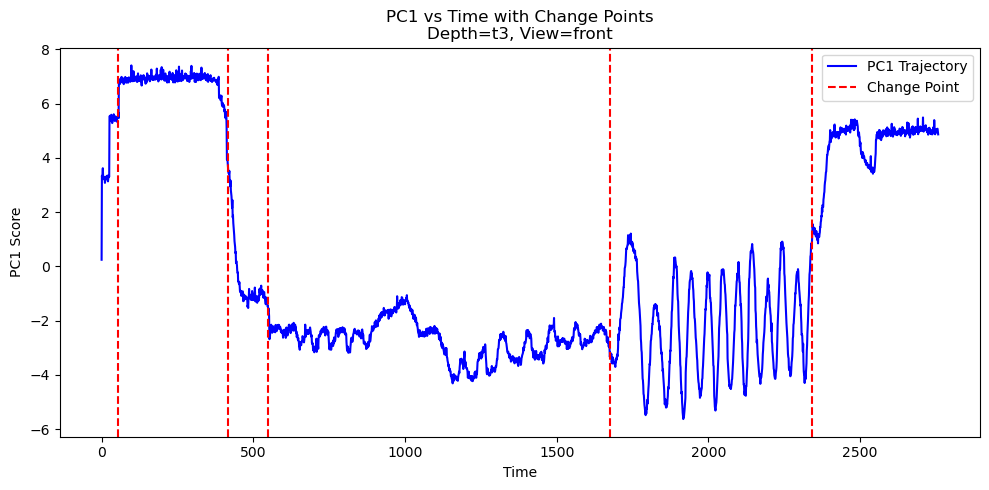

Change points (frame indices) for t3 front: [55, 415, 550, 1675, 2340, 2758]
For t3s the variance for PC1 is 0.5228 and PC2 is 0.2575


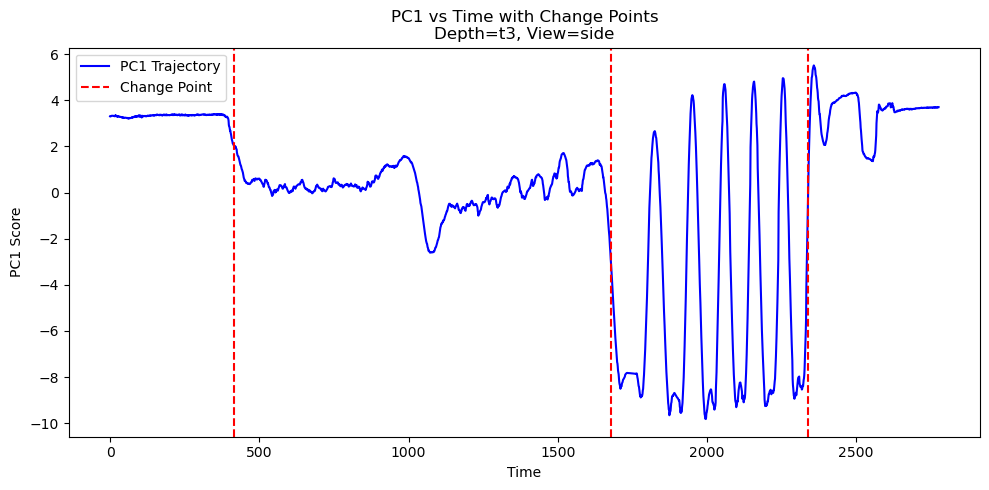

Change points (frame indices) for t3 side: [415, 1680, 2340, 2777]
   depth   view component   feature_1  weight_1 feature_2  weight_2 feature_3  \
0     b1  front       PC1       fTip3  0.240434   Elbow.1  0.239025     fTip4   
1     b1   side       PC1        MCP3  0.249545      MCP2  0.249181      MCP4   
2     b2  front       PC1      MCP2.1  0.239753   fTip2.1  0.236234    MCP3.1   
3     b2   side       PC1        MCP5  0.264611      MCP4  0.264560      MCP3   
4     b3  front       PC1      MCP2.1  0.245700   fTip2.1  0.240437   fTip1.1   
5     b3   side       PC1        MCP3  0.273454      MCP4  0.272974      MCP2   
6     c1  front       PC1  PalmBase.1  0.274866    MCP4.1  0.251102  PalmBase   
7     c1   side       PC1        MCP1  0.243886     fTip1  0.243171      MCP2   
8     c2  front       PC1      MCP1.1  0.236851    MCP2.1  0.231860   fTip4.1   
9     c2   side       PC1      MCP5.1  0.226989   fTip5.1  0.226067      MCP5   
10    c3  front       PC1      MCP1.1  0.2

In [138]:
# Initialize empty lists before loop
pca1_rows = []
pca2_rows = []
explained_var_rows = []
top5_pc1_rows = []
top5_pc2_rows = []

# 
results_list = []

# Parameters for ruptures
model = "rbf"
penalty_value = 35  # Adjust as needed

for base in dataframes:
    mov = 'all'  # example movement label
    df = dataframes[base]

    # Extract depth and view info from 'base'
    depth = base[:-1]  # e.g. 'b1f' -> 'b1'
    view_type = 'front' if base.endswith('f') else 'side'

    # Trim zeros from beginning of view
    view_trimmed = trim_initial_zeros(df)

    # Extract original columns used in PCA (excluding dropped/constant)
    used_columns = view_trimmed.loc[:, ~view_trimmed.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    # Run PCA on trimmed data
    X_pca, explained_variance_ratio, explained_variance_raw, components = run_PCA(view_trimmed, None)

    print(f'For {base} the variance for PC1 is {explained_variance_ratio[0]:.4f} and PC2 is {explained_variance_ratio[1]:.4f}')
    

    # X_pca shape: (n_samples, 2)
    pc1_scores = X_pca[:, 0]
    pc2_scores = X_pca[:, 1]
    t = np.arange(len(pc1_scores))

    # Now stack them for ruptures
    signal = np.column_stack((pc1_scores, pc2_scores))

    # Run ruptures (as you already do)
    algo = rpt.Pelt(model='rbf').fit(signal)
    change_points = algo.predict(pen=penalty_value)

    # Plot 3D trajectory with change points
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt

    
    plt.figure(figsize=(10, 5))

    # Plot PC1 scores over time
    plt.plot(t, pc1_scores, color='blue', label='PC1 Trajectory')

    # Mark change points with vertical dashed lines
    for cp in change_points[:-1]:  # Skip last point if it’s at the end
        plt.axvline(x=cp, color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")

    plt.xlabel('Time')
    plt.ylabel('PC1 Score')
    plt.title(f'PC1 vs Time with Change Points\nDepth={depth}, View={view_type}')
    plt.legend()
    plt.tight_layout()
    plt.show()


    # Print results
    print(f"Change points (frame indices) for {depth} {view_type}: {change_points}")

    # Create a dictionary for storing change point results
    dic_indices = {
        "depth": depth,
        "view": view_type,
        "component": "indices"
    }

    # Save the top features and their change points
    dic_indices["change_points"] = change_points

    # Assuming you're collecting multiple such dictionaries into a list
    results_list.append(dic_indices)

    

    # PC1 and PC2 component weights (loadings)
    pc1 = components[0]
    pc2 = components[1]

    # Create dicts for PC1 and PC2 rows
    row_pc1 = {
        "depth": depth,
        "view": view_type,
        "component": "PC1",
        "values" : pc1_scores
    }
    row_pc2 = {
        "depth": depth,
        "view": view_type,
        "component": "PC2",
        "values" : pc2_scores
    }

    # Add feature component weights to both PC1 and PC2 rows
    for feat, weight1, weight2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = weight1
        row_pc2[feat] = weight2

    # Append rows to respective lists
    pca1_rows.append(row_pc1)
    pca2_rows.append(row_pc2)

    # Save explained variance for PC1 and PC2
    explained_var_rows.append({
        "depth": depth,
        "view": view_type,
        "PC1_var": explained_variance_ratio[0],
        "PC2_var": explained_variance_ratio[1],
    })

    # Top 5 contributors for PC1
    feature_contributions_pc1 = list(zip(final_cols, pc1))
    feature_contributions_pc1.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc1 = feature_contributions_pc1[:5]

    top5_pc1_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC1"
    }
    for idx, (feat, weight) in enumerate(top5_pc1):
        top5_pc1_dict[f"feature_{idx+1}"] = feat
        top5_pc1_dict[f"weight_{idx+1}"] = weight
    top5_pc1_rows.append(top5_pc1_dict)

    # Top 5 contributors for PC2
    feature_contributions_pc2 = list(zip(final_cols, pc2))
    feature_contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = feature_contributions_pc2[:5]

    top5_pc2_dict = {
        "depth": depth,
        "view": view_type,
        "component": "PC2"
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_pc2_dict[f"feature_{idx+1}"] = feat
        top5_pc2_dict[f"weight_{idx+1}"] = weight
    top5_pc2_rows.append(top5_pc2_dict)

# Create DataFrames after loop
pca1_df = pd.DataFrame(pca1_rows)
pca2_df = pd.DataFrame(pca2_rows)
explained_df = pd.DataFrame(explained_var_rows)
top5_pc1_df = pd.DataFrame(top5_pc1_rows)
top5_pc2_df = pd.DataFrame(top5_pc2_rows)

print(top5_pc1_df)
print(top5_pc2_df)


In [34]:
top5_pc1_df

depth   view component feature_1  weight_1 feature_2  weight_2   feature_3  \
0    b1  front       PC1      MCP5  0.225705   fTip5.1 -0.225112  PalmBase.1   
1    c1  front       PC1    MCP5.1  0.221498   fTip5.1  0.217318  PalmBase.1   
2    c2  front       PC1    MCP5.1  0.221327   fTip5.1  0.212959  PalmBase.1   
3    c3  front       PC1    MCP5.1  0.223981   fTip5.1  0.217790  PalmBase.1   
4    t3  front       PC1      MCP5  0.247257  PalmBase  0.244527     fTip5.1   

   weight_3   feature_4  weight_4 feature_5  weight_5  
0 -0.223219      MCP4.1 -0.222436   fTip4.1 -0.218517  
1  0.216170      MCP4.1  0.214560  PalmBase -0.212837  
2  0.211758      MCP4.1  0.210760     fTip1 -0.209062  
3  0.216333      MCP4.1  0.215206  PalmBase -0.210491  
4 -0.221733  MidForeArm  0.220396    MCP4.1 -0.216332

In [35]:
pca1_df

depth   view component                                             values  \
0    b1  front       PC1  [-7.558006725161321, -7.547622331763729, -7.55...   
1    c1  front       PC1  [5.80751981356834, 5.809814251277348, 5.808052...   
2    c2  front       PC1  [7.040466521882552, 7.038292327945735, 7.03148...   
3    c3  front       PC1  [7.413895726090499, 7.41831985214348, 7.419768...   
4    t3  front       PC1  [-7.214786642094398, -7.213566354633988, -7.21...   

   PalmBase  PalmBase.1      MCP1    MCP1.1      MCP2    MCP2.1  ...  \
0  0.203160   -0.223219  0.202649 -0.201322  0.200595 -0.208609  ...   
1 -0.212837    0.216170 -0.208493  0.198592 -0.208563  0.201016  ...   
2 -0.208083    0.211758 -0.206355  0.185945 -0.207118  0.192441  ...   
3 -0.210491    0.216333 -0.205637  0.192777 -0.206582  0.198207  ...   
4  0.244527    0.073210  0.210167 -0.199827  0.208235 -0.199184  ...   

      fTip3   fTip3.1     fTip4   fTip4.1     fTip5   fTip5.1  MidForeArm  \
0  0.189781 -0.212434  0.189787 -0.218517  0.188017 -0.225112    0.201870   
1 -0.199311  0.204433 -0.199235  0.209611 -0.199232  0.217318   -0.176187   
2 -0.203847  0.195107 -0.205311  0.202727 -0.205534  0.212959   -0.201038   
3 -0.200210  0.201542 -0.201479  0.208600 -0.201576  0.217790   -0.200518   
4  0.201228 -0.204817  0.201102 -0.212225  0.200604 -0.221733    0.220396   

   MidForeArm.1     Elbow   Elbow.1  
0      0.118918  0.164057  0.150883  
1     -0.077887 -0.109094 -0.101592  
2     -0.106101 -0.137492 -0.132992  
3     -0.086231 -0.112325 -0.106598  
4      0.131532  0.144608  0.140042  

[5 rows x 30 columns]

## Visualize indices df

In [139]:
df_indices = pd.DataFrame(results_list)

df_indices 

depth   view component                                      change_points
0     b1  front   indices                             [480, 725, 1265, 1331]
1     b1   side   indices                             [530, 720, 1265, 1317]
2     b2  front   indices                              [125, 655, 850, 1361]
3     b2   side   indices                                   [120, 850, 1364]
4     b3  front   indices                                  [620, 1135, 1181]
5     b3   side   indices                                  [625, 1135, 1220]
6     c1  front   indices                            [475, 1010, 1195, 1777]
7     c1   side   indices                            [500, 1010, 1200, 1751]
8     c2  front   indices                             [200, 800, 1255, 1842]
9     c2   side   indices                       [210, 645, 1260, 1810, 1874]
10    c3  front   indices                                  [175, 1085, 1653]
11    c3   side   indices                             [175, 565, 1080, 1637]
12    t1  front   indices                      [115, 1270, 2000, 2490, 2805]
13    t1   side   indices  [1275, 1995, 2495, 3260, 3585, 3900, 3965, 472...
14    t2  front   indices    [470, 1000, 1210, 1665, 2000, 2760, 2805, 3131]
15    t2   side   indices     [465, 995, 1210, 1665, 2035, 2155, 2755, 3138]
16    t3  front   indices                   [55, 415, 550, 1675, 2340, 2758]
17    t3   side   indices                            [415, 1680, 2340, 2777]

## Averaging close datapoints

In [140]:
# Create an empty list to hold averaged points for each row
averaged_points_list = []

# Loop through each row in the DataFrame
for _, row in df_indices.iterrows():
    change_points = row['change_points']
    averaged_points = average_close_indices(change_points, threshold=150)
    averaged_points_list.append(averaged_points)

# Assign the results as a new column in the DataFrame
df_indices['averaged_points'] = averaged_points_list

## Creating movement df for armEF --> need to implement idea here!!

In [ ]:
def find_max_variability_segment(values_list, indices):
    """
    Given PC1 values and movement boundary indices, find the segment with the greatest variability.
    
    values_list : np.array or list
        PC1 time series values.
    indices : list of ints
        Frame boundaries (sorted, like from 'averaged_points').
    """
    max_var = -np.inf
    best_segment = (0, 0)

    for i in range(len(indices) - 1):
        start = indices[i]
        end = indices[i + 1]
        segment = values_list[start:end+1]

        variability = np.std(segment)  # Could use variance, max-min, etc.
        if variability > max_var:
            max_var = variability
            best_segment = (start, end)

    return best_segment


# Main loop
df_movements = pd.DataFrame(columns=['dataset', 'view', 'arm_EF', 'hand_OC', 'hand_PS'])

for _, row in df_indices.iterrows():
    # getting indices and then taking only the last half of them to then allow for only the second part of the frames to be looked at
    all_indices = row['averaged_points']
    # implement this only if this long because if there are only 3 or 4, it will cause problemsa nd make the last section the most variance section
    if len(all_indices) > 4:
        halfway = len(all_indices) // 2
        all_indices = all_indices[halfway:]


    if row['depth'] in skip_trails or len(all_indices) == 1:
        continue

    # Retrieve PC1 values for this dataset
    pc1_values = pca1_df.loc[
        (pca1_df['depth'] == row['depth']) & 
        (pca1_df['view'] == row['view']), 
        'values'
        ].values[0] 


    # Find segment with max variability
    start, end = find_max_variability_segment(pc1_values, all_indices)

    df_movements = pd.concat([
        df_movements,
        pd.DataFrame([{
            'dataset': row['depth'],
            'view': row['view'],
            'arm_EF': (start, end),
            'hand_OC': (0, 0),
            'hand_PS': (0, 0)
        }])
    ], ignore_index=True)

print(df_movements)


   dataset   view        arm_EF hand_OC hand_PS
0       b1  front   (725, 1298)  (0, 0)  (0, 0)
1       b1   side   (720, 1291)  (0, 0)  (0, 0)
2       b2  front   (850, 1361)  (0, 0)  (0, 0)
3       b2   side   (850, 1364)  (0, 0)  (0, 0)
4       b3  front   (620, 1158)  (0, 0)  (0, 0)
5       b3   side   (625, 1177)  (0, 0)  (0, 0)
6       c1  front  (1195, 1777)  (0, 0)  (0, 0)
7       c1   side  (1200, 1751)  (0, 0)  (0, 0)
8       c2  front  (1255, 1842)  (0, 0)  (0, 0)
9       c2   side  (1260, 1842)  (0, 0)  (0, 0)
10      c3  front  (1085, 1653)  (0, 0)  (0, 0)
11      c3   side  (1080, 1637)  (0, 0)  (0, 0)
12      t2  front  (2000, 2782)  (0, 0)  (0, 0)
13      t2   side  (2095, 2755)  (0, 0)  (0, 0)
14      t3  front  (1675, 2340)  (0, 0)  (0, 0)
15      t3   side  (1680, 2340)  (0, 0)  (0, 0)


## Visualizing armEF segmentation

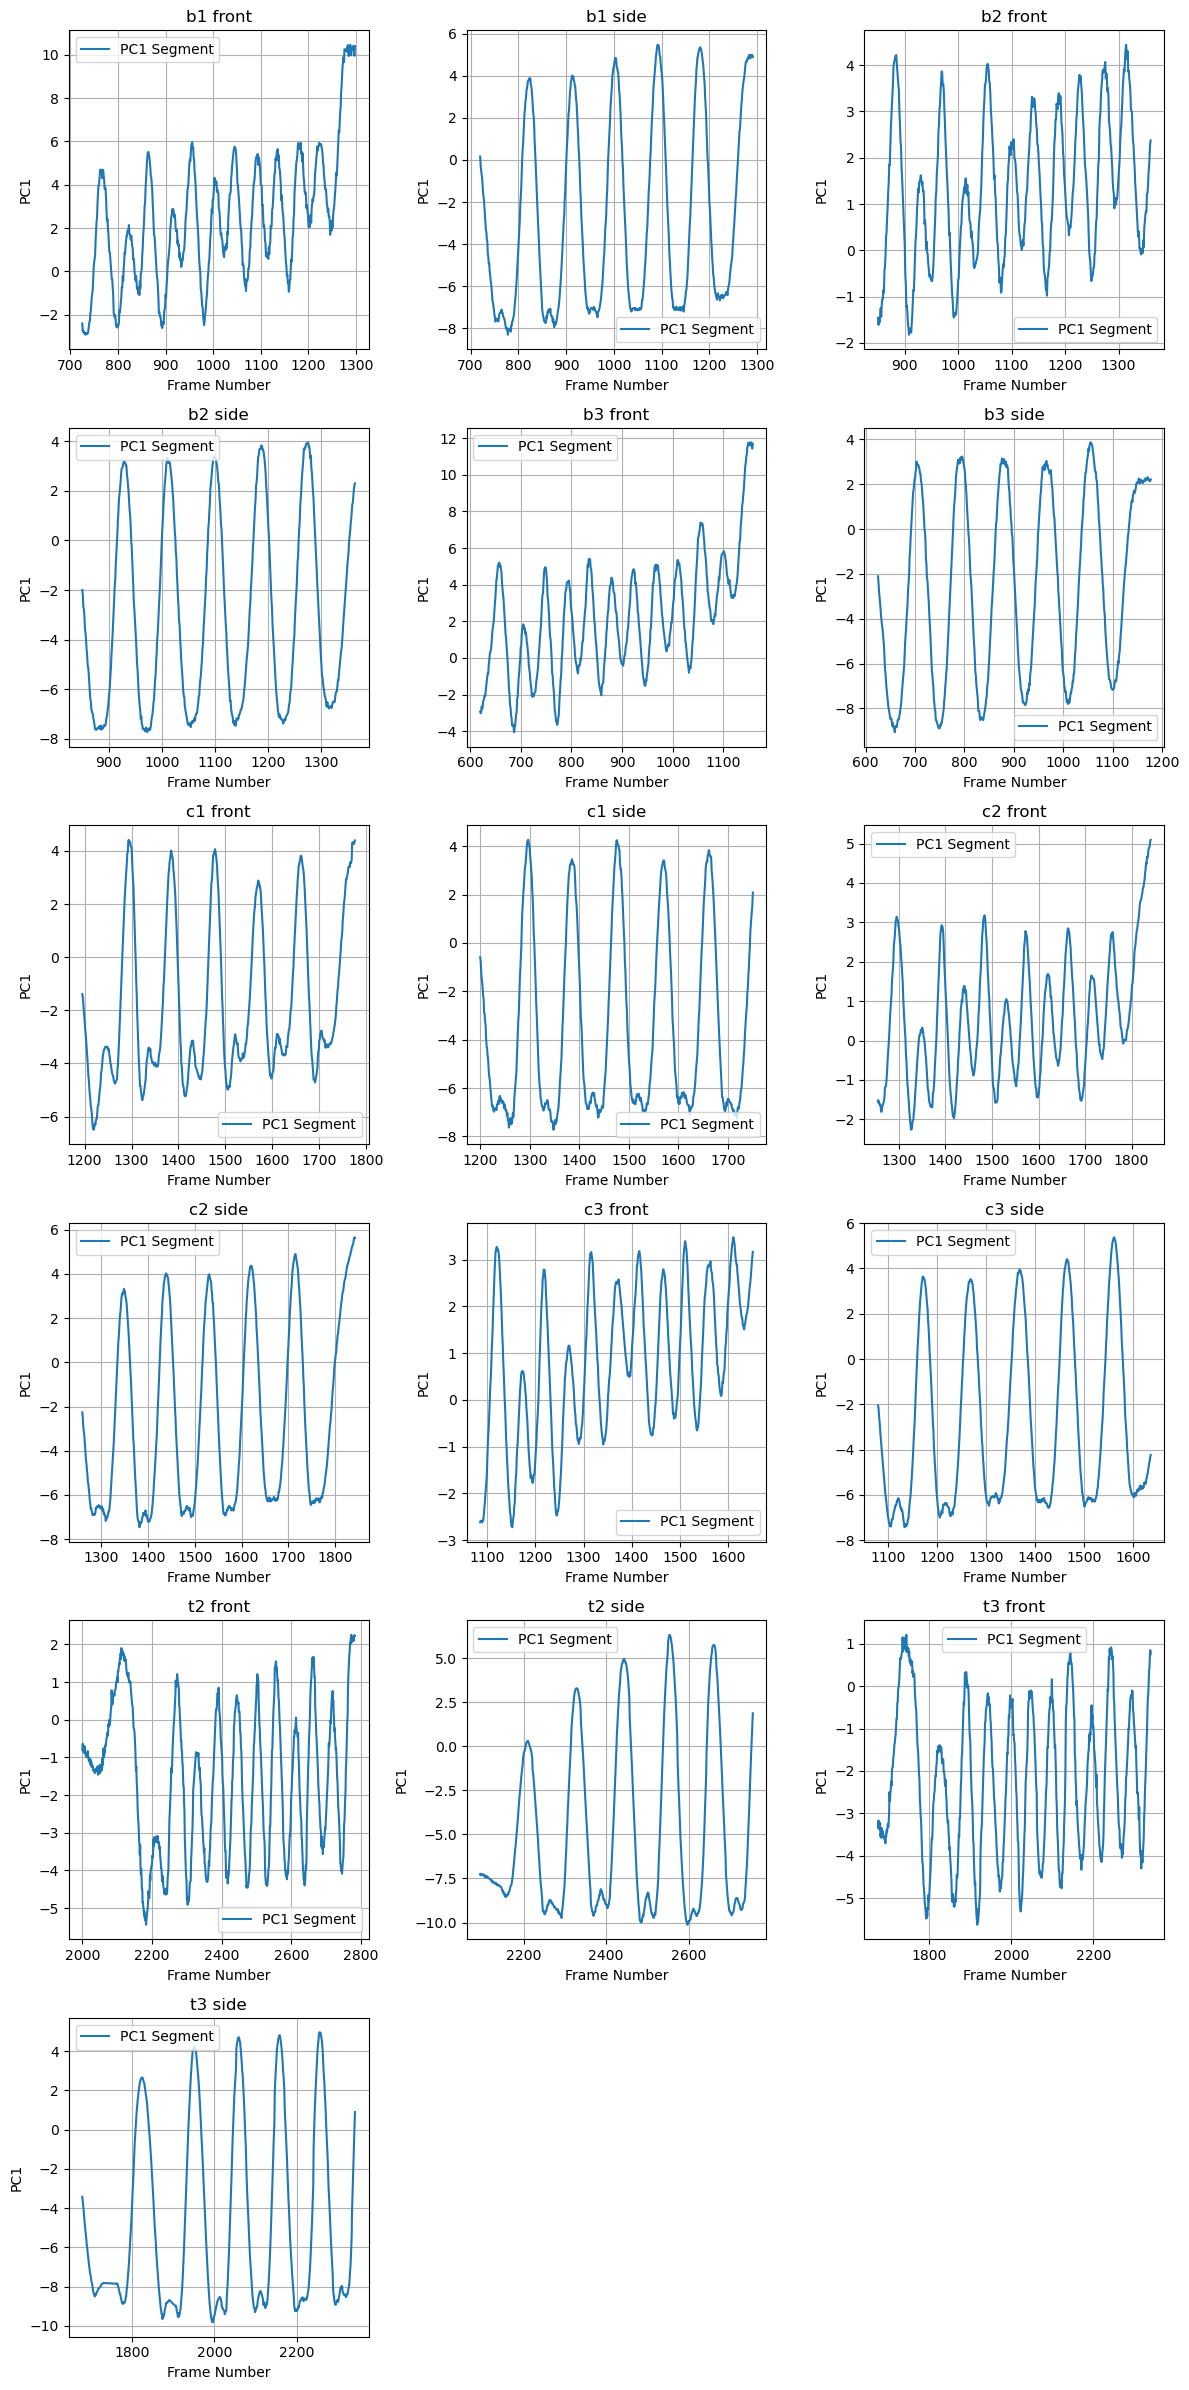

In [151]:
# Filter out rows where depth is 't1'
filtered_movements = df_movements[df_movements['dataset'] != 't1']
n = len(filtered_movements)
cols = 3
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(12, 4 * rows), sharex=False)
axs = axs.flatten()

for idx, (_, row) in enumerate(filtered_movements.iterrows()):
    depth = row['dataset']
    view_type = row['view']
    start, end = row['arm_EF']

    # Find the correct PC1 row in pca1_df based on matching depth and view
    match = pca1_df[(pca1_df['depth'] == depth) & (pca1_df['view'] == view_type)]
    if match.empty:
        print(f"No PC1 data found for depth={depth}, view={view_type}")
        continue

    values_list = match['values'].iloc[0]  # Extract the list/array of PC1 values
    values_series = pd.Series(values_list, index=np.arange(len(values_list)))

    # Slice the segment based on start and end frame
    segment = values_series.iloc[start:end+1]

    # Plot the segment
    ax = axs[idx]
    ax.plot(segment.index, segment.values, label='PC1 Segment')
    ax.set_title(f"{depth} {view_type}")
    ax.set_ylabel('PC1')
    ax.set_xlabel('Frame Number')
    ax.grid(True)
    ax.legend()

# Hide any unused subplots
for i in range(n, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()


## Run PCA on only handOC and handPS time 

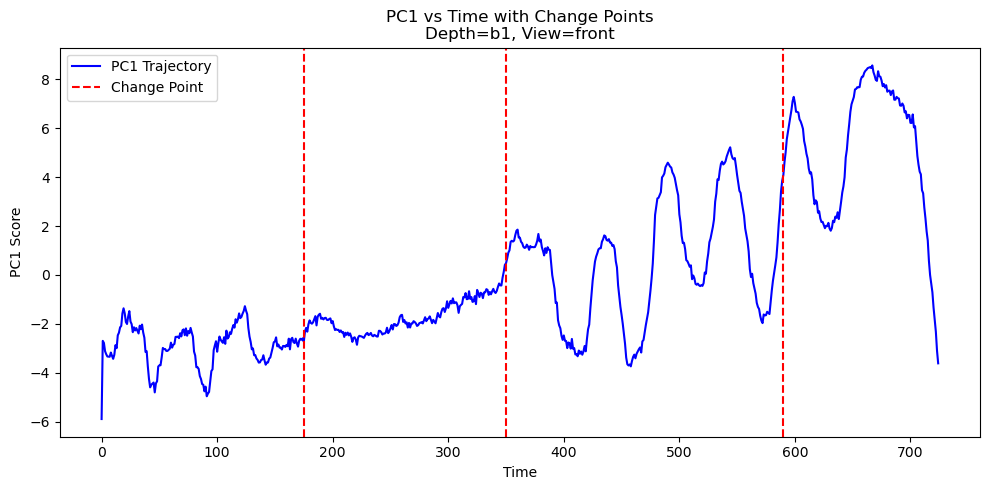

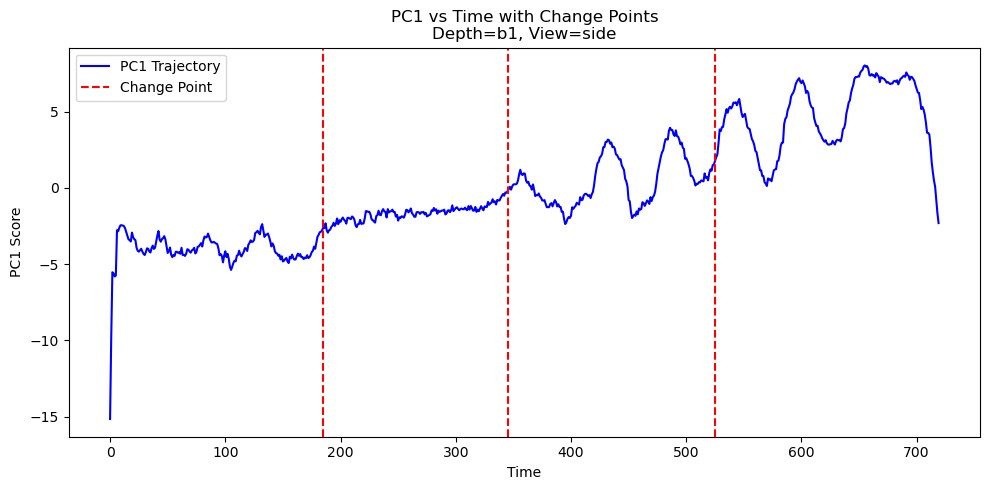

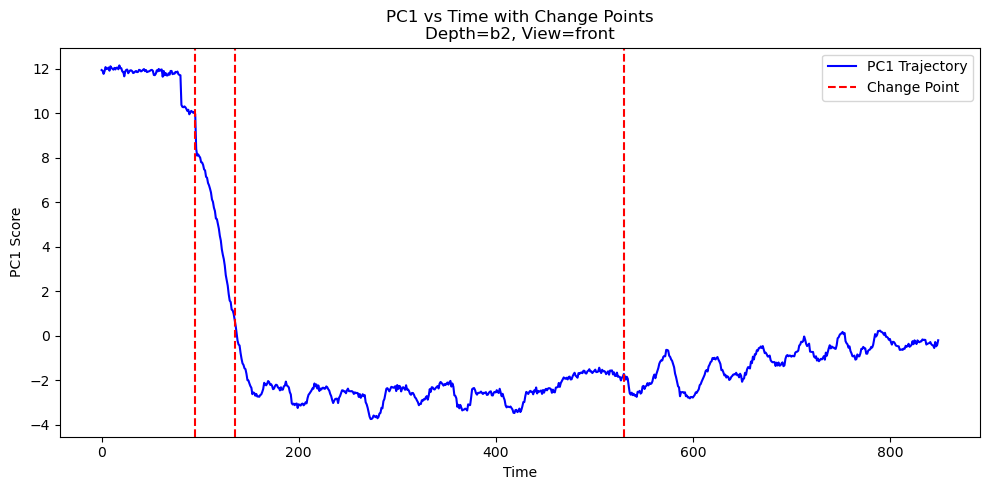

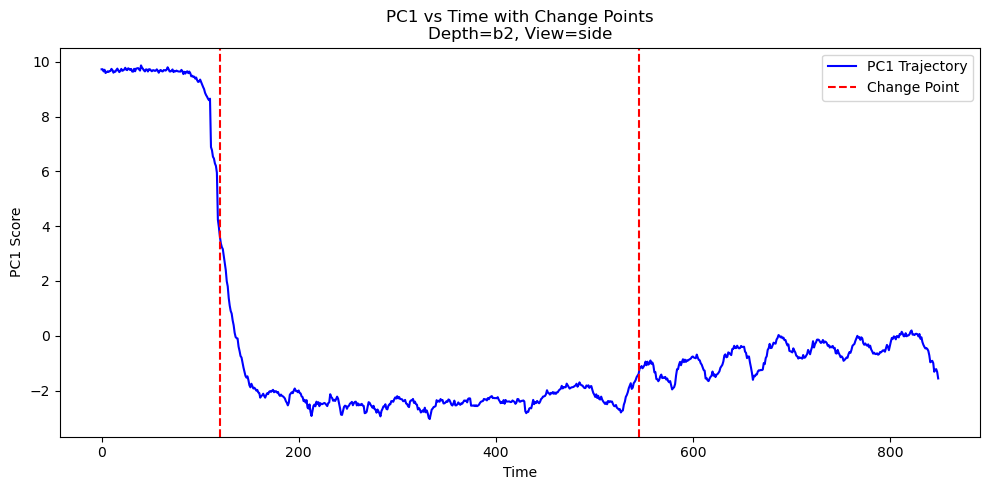

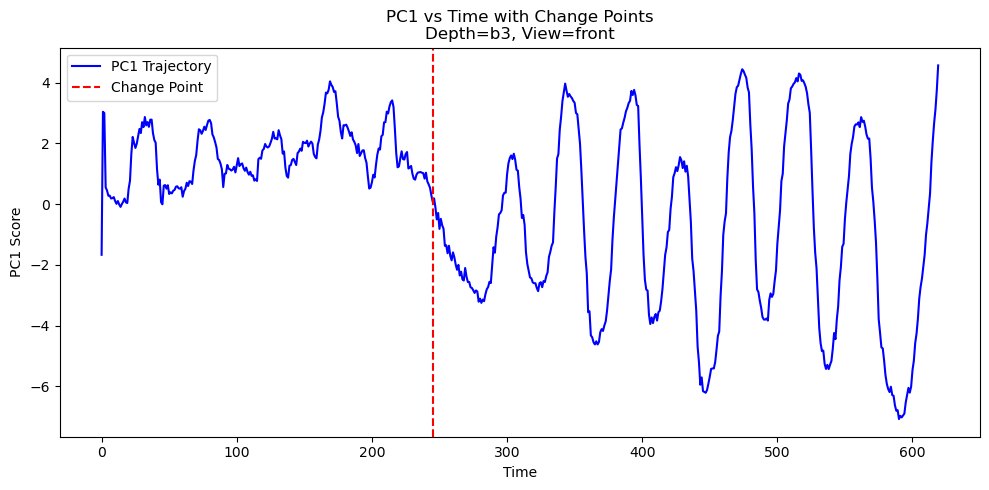

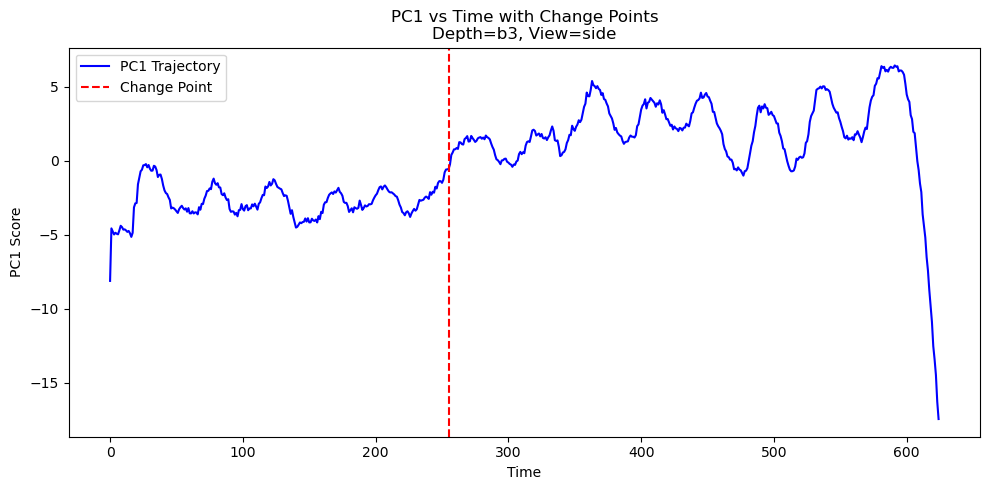

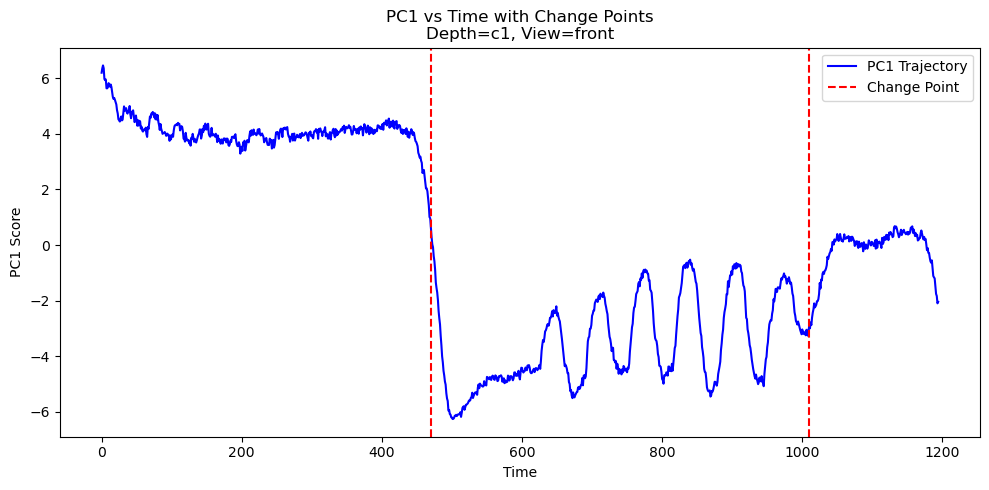

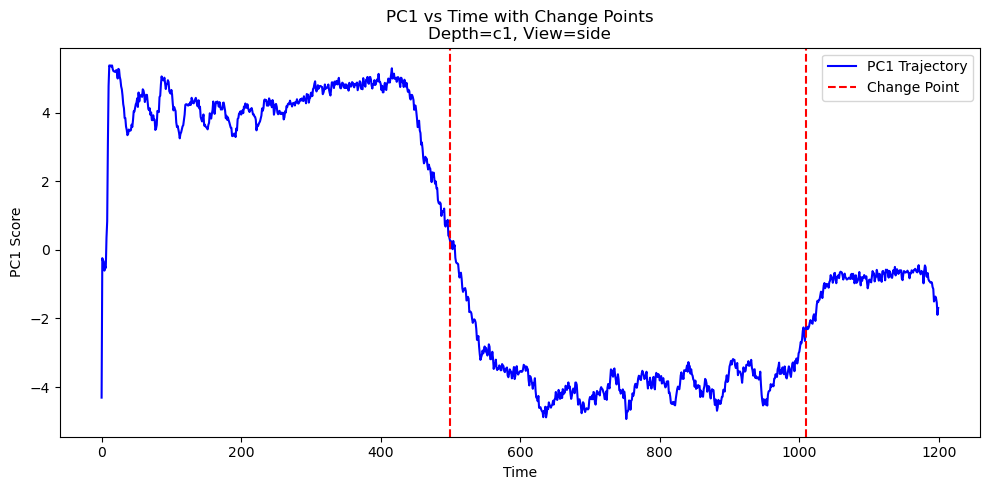

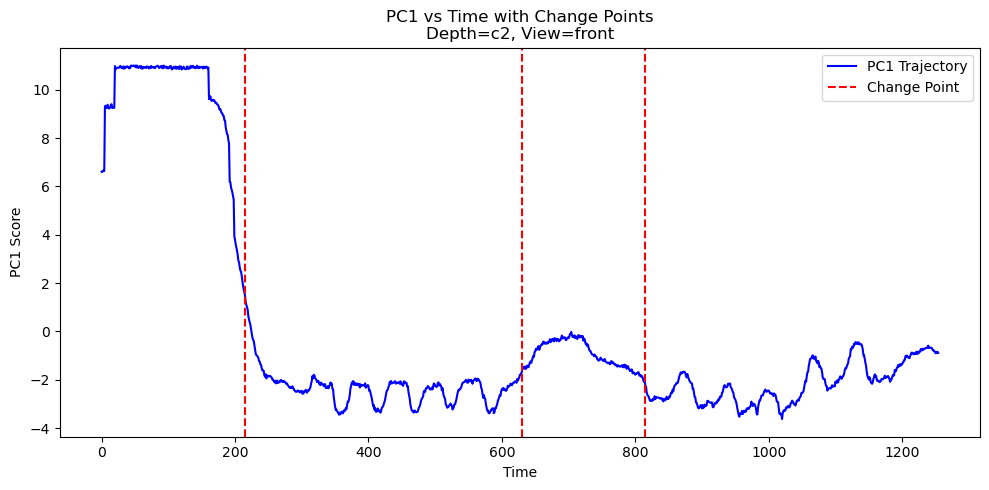

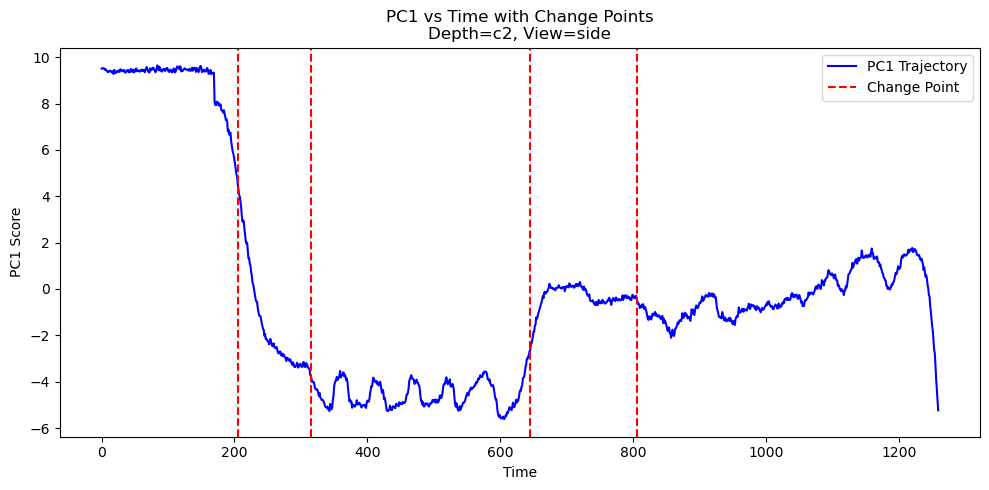

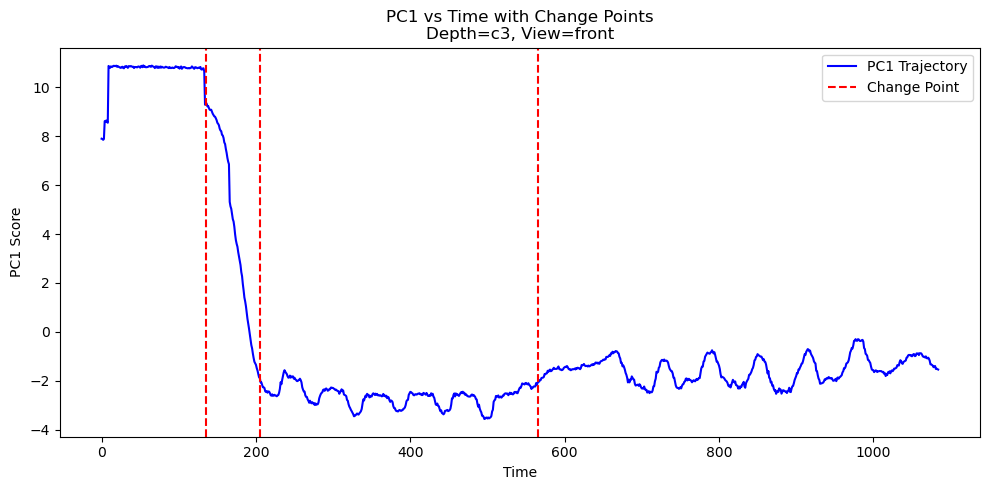

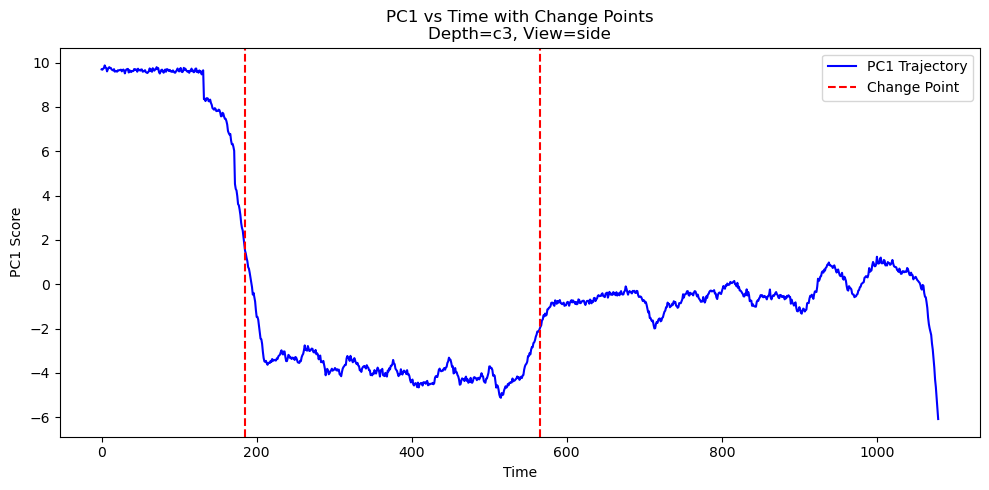

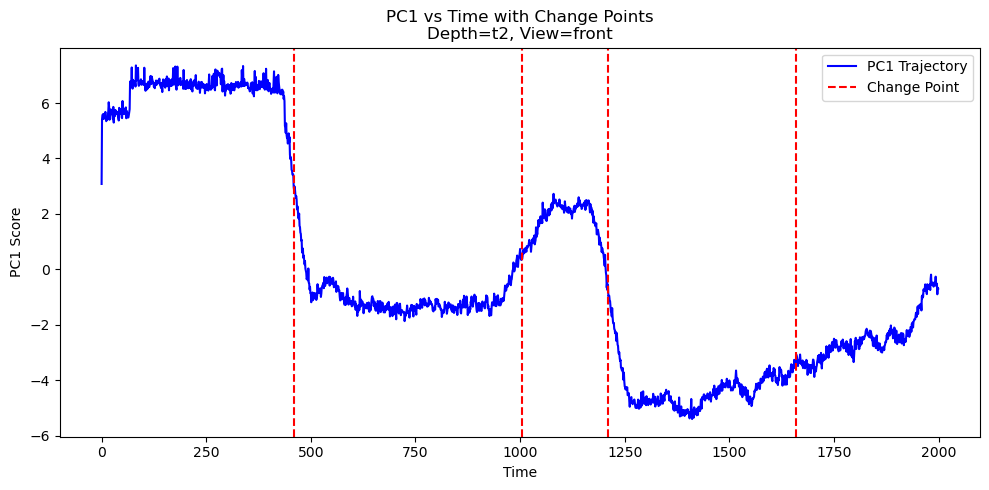

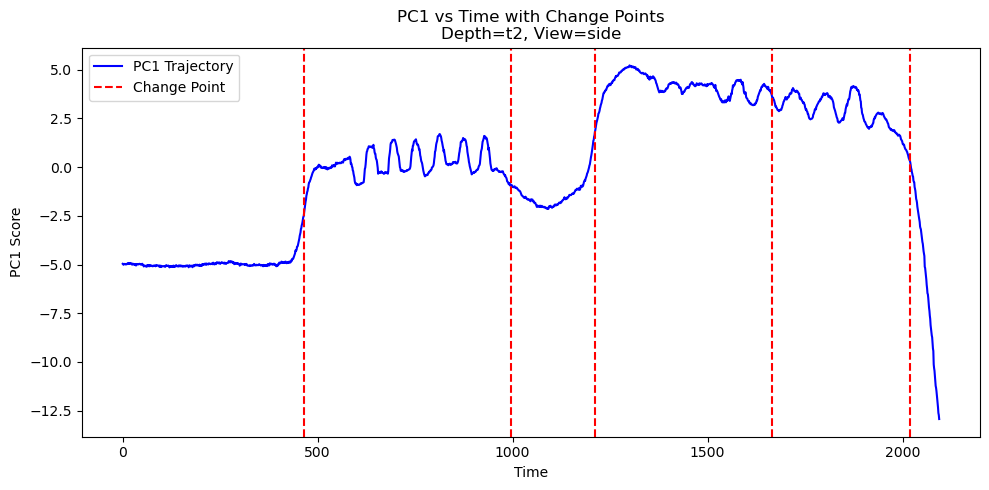

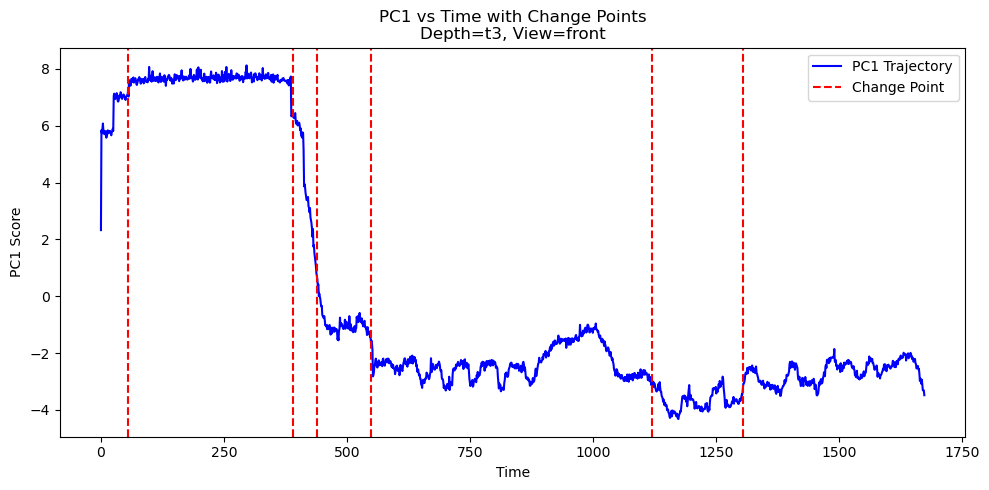

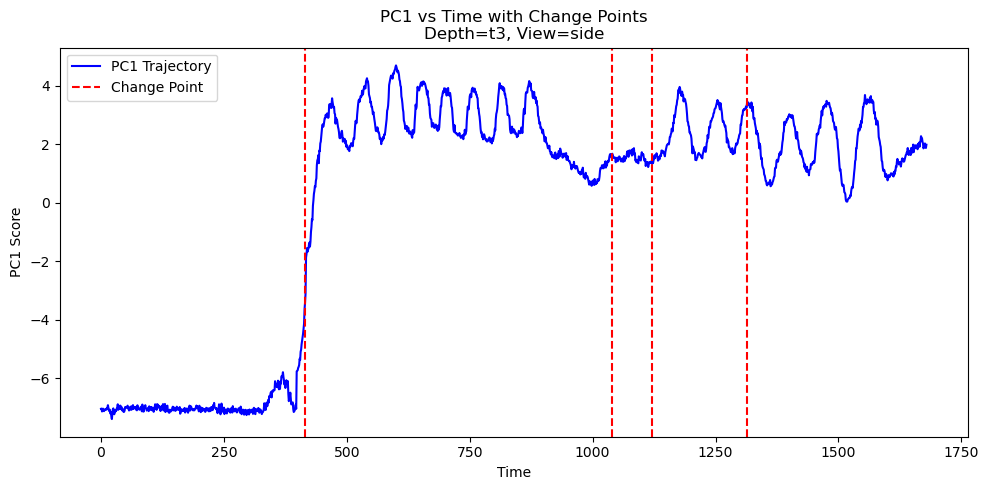

In [170]:
# New containers for start-segment PCA data
pca1_start_rows = []
pca2_start_rows = []
explained_start_rows = []
top5_start_pc1_rows = []
top5_start_pc2_rows = []

results_list2 = []

view_map = {"front": "f", "side": "s"}

for _, row in df_movements.iterrows():
    depth = row["dataset"]
    view = row["view"]

    # Skip if missing
    if pd.isna(depth) or pd.isna(view):
        continue

    # Map "front"/"side" to "f"/"s"
    view_letter = view_map.get(view.lower())

    if view_letter is None:
        print(f"Unrecognized view: {view}")
        continue

    base = f"{depth}{view_letter}"

    if base not in dataframes:
        print(f"Skipping {base} - not found in dataframes.")
        continue

    df_full = dataframes[base]
    


    # Get starting segment: from 0 to first change point of armEF so it only includes handOC and armPS
    change_points = row['arm_EF']  
    if not change_points or len(change_points) == 0:
        continue  # Skip if no change points
    
    # get the segment for only HOC and HPS
    first_cp = int(change_points[0])
    df_segment = df_full.iloc[:first_cp]

    # Trim initial zeros like before
    df_trimmed = trim_initial_zeros(df_segment)

    # Run PCA on start segment
    X_pca, explained_ratio, explained_raw, components = run_PCA(df_segment, None)

    # 
    used_columns = df_segment.loc[:, ~df_segment.columns.str.contains(r'\.2')]
    stds = used_columns.std(axis=0)
    final_cols = used_columns.loc[:, stds != 0].columns.tolist()

    # X_pca shape: (n_samples, 2)
    pc1_scores = X_pca[:, 0]
    pc2_scores = X_pca[:, 1]
    t = np.arange(len(pc1_scores))

    # Now stack them for ruptures
    signal = np.column_stack((pc1_scores, pc2_scores))

    # Run ruptures (as you already do)
    algo = rpt.Pelt(model='rbf').fit(signal)
    change_points = algo.predict(pen=penalty_value)

    
    plt.figure(figsize=(10, 5))

    # Plot PC1 scores over time
    plt.plot(t, pc1_scores, color='blue', label='PC1 Trajectory')

    # Mark change points with vertical dashed lines
    for cp in change_points[:-1]:  # Skip last point if it’s at the end
        plt.axvline(x=cp, color='red', linestyle='--', label='Change Point' if cp == change_points[0] else "")

    plt.xlabel('Time')
    plt.ylabel('PC1 Score')
    plt.title(f'PC1 vs Time with Change Points\nDepth={depth}, View={view}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    pc1 = components[0]
    pc2 = components[1]

    # Build PCA1 row
    row_pc1 = {"depth": depth, "view": view_letter, "component": "PC1"}
    row_pc2 = {"depth": depth, "view": view_letter, "component": "PC2"}
    
    for feat, w1, w2 in zip(final_cols, pc1, pc2):
        row_pc1[feat] = w1
        row_pc2[feat] = w2

    pca1_start_rows.append(row_pc1)
    pca2_start_rows.append(row_pc2)

    explained_start_rows.append({
        "depth": depth,
        "view": view_letter,
        "PC1_var": explained_ratio[0],
        "PC2_var": explained_ratio[1]
    })

    # Top 5 for PC1
    contributions = list(zip(final_cols, pc1))
    contributions.sort(key=lambda x: abs(x[1]), reverse=True)
    top5 = contributions[:5]

    top5_dict = {
        "depth": depth,
        "view": view,
        "component": "PC1"
    }
    for idx, (feat, weight) in enumerate(top5):
        top5_dict[f"feature_{idx+1}"] = feat
        top5_dict[f"weight_{idx+1}"] = weight
    top5_start_pc1_rows.append(top5_dict)


    # Top 5 for PC2
    contributions_pc2 = list(zip(final_cols, pc2))
    contributions_pc2.sort(key=lambda x: abs(x[1]), reverse=True)
    top5_pc2 = contributions_pc2[:5]

    top5_dict_pc2 = {
        "depth": depth,
        "view": view,
        "component": "PC2"
    }
    for idx, (feat, weight) in enumerate(top5_pc2):
        top5_dict_pc2[f"feature_{idx+1}"] = feat
        top5_dict_pc2[f"weight_{idx+1}"] = weight
    top5_start_pc2_rows.append(top5_dict_pc2)

    # Create a dictionary for storing change point results
    dic_indices2 = {
        "depth": depth,
        "view": view,
        "component": "indices"
    }

    # Save the top features and their change points
    dic_indices2["change_points"] = change_points

    # Assuming you're collecting multiple such dictionaries into a list
    results_list2.append(dic_indices2)


# At the end: convert to dataframes
pca1_start_df = pd.DataFrame(pca1_start_rows)
pca2_start_df = pd.DataFrame(pca2_start_rows)
explained_start_df = pd.DataFrame(explained_start_rows)
top5_start_pc1_df = pd.DataFrame(top5_start_pc1_rows)
top5_start_pc2_df = pd.DataFrame(top5_start_pc2_rows)

df_indices2 = pd.DataFrame(results_list2)



In [63]:
top5_start_pc1_df

depth   view component feature_1  weight_1 feature_2  weight_2 feature_3  \
0    b1  front       PC1    MCP4.1  0.233352    MCP3.1  0.232727   fTip5.1   
1    c1  front       PC1    MCP4.1  0.240591    MCP5.1  0.240322   fTip5.1   
2    c2  front       PC1    MCP5.1  0.250023    MCP4.1  0.249263    MCP3.1   
3    c3  front       PC1    MCP5.1  0.236412    MCP4.1  0.236352    MCP3.1   
4    t3  front       PC1    MCP3.1  0.246393    MCP2.1  0.246038    MCP4.1   

   weight_3 feature_4  weight_4 feature_5  weight_5  
0  0.232519    MCP2.1  0.231346   fTip4.1  0.228615  
1  0.240319    MCP3.1  0.239339   fTip4.1  0.238106  
2  0.248969   fTip5.1  0.246944    MCP2.1  0.246848  
3  0.235378    MCP2.1  0.234027   fTip5.1  0.233423  
4  0.246005   fTip5.1  0.243965   fTip4.1  0.242870

In [153]:
df_indices2 

depth   view component                          change_points
0     b1  front   indices                   [175, 350, 590, 725]
1     b1   side   indices                   [185, 345, 525, 720]
2     b2  front   indices                    [95, 135, 530, 850]
3     b2   side   indices                        [120, 545, 850]
4     b3  front   indices                             [245, 620]
5     b3   side   indices                             [255, 625]
6     c1  front   indices                      [470, 1010, 1195]
7     c1   side   indices                      [500, 1010, 1200]
8     c2  front   indices                  [215, 630, 815, 1255]
9     c2   side   indices             [205, 315, 645, 805, 1260]
10    c3  front   indices                  [135, 205, 565, 1085]
11    c3   side   indices                       [185, 565, 1080]
12    t2  front   indices          [460, 1005, 1210, 1660, 2000]
13    t2   side   indices     [465, 995, 1210, 1665, 2020, 2095]
14    t3  front   indices  [55, 390, 440, 550, 1120, 1305, 1675]
15    t3   side   indices          [415, 1040, 1120, 1315, 1680]

In [166]:
def segment_variability(values_series, indices, plot=False, use_std=True):
    """
    Calculate variability (std or variance) for each segment in values_series
    split by given indices.
    """
    # Ensure the first index is 0
    if indices[0] != 0:
        indices = [0] + list(indices)

    results = []
    for i in range(len(indices) - 1):
        start = indices[i]
        end = indices[i + 1]
        segment = values_series[start:end+1]

        variability = np.std(segment) if use_std else np.var(segment)
        results.append({"start": start, "end": end, "variability": variability})

    df_results = pd.DataFrame(results)

    if plot:
        plt.figure(figsize=(8, 4))
        plt.bar(range(len(results)), [r["variability"] for r in results])
        plt.xlabel("Segment")
        plt.ylabel("Std Dev" if use_std else "Variance")
        plt.title("Segment Variability")
        plt.show()

    return df_results


In [173]:
# Create an empty list to hold averaged points for each row
averaged_points_list = []

# Loop through each row in the DataFrame
for _, row in df_indices2.iterrows():
    change_points = row['change_points']
    averaged_points = average_close_indices(change_points, threshold=150)
    averaged_points_list.append(averaged_points)

# Assign the results as a new column in the DataFrame
df_indices2['averaged_points'] = averaged_points_list

In [174]:
df_indices2

depth   view component                          change_points  \
0     b1  front   indices                   [175, 350, 590, 725]   
1     b1   side   indices                   [185, 345, 525, 720]   
2     b2  front   indices                    [95, 135, 530, 850]   
3     b2   side   indices                        [120, 545, 850]   
4     b3  front   indices                             [245, 620]   
5     b3   side   indices                             [255, 625]   
6     c1  front   indices                      [470, 1010, 1195]   
7     c1   side   indices                      [500, 1010, 1200]   
8     c2  front   indices                  [215, 630, 815, 1255]   
9     c2   side   indices             [205, 315, 645, 805, 1260]   
10    c3  front   indices                  [135, 205, 565, 1085]   
11    c3   side   indices                       [185, 565, 1080]   
12    t2  front   indices          [460, 1005, 1210, 1660, 2000]   
13    t2   side   indices     [465, 995, 1210, 1665, 2020, 2095]   
14    t3  front   indices  [55, 390, 440, 550, 1120, 1305, 1675]   
15    t3   side   indices          [415, 1040, 1120, 1315, 1680]   

                  averaged_points  
0                 [175, 350, 657]  
1            [185, 345, 525, 720]  
2                 [115, 530, 850]  
3                 [120, 545, 850]  
4                      [245, 620]  
5                      [255, 625]  
6               [470, 1010, 1195]  
7               [500, 1010, 1200]  
8           [215, 630, 815, 1255]  
9           [260, 645, 805, 1260]  
10               [170, 565, 1085]  
11               [185, 565, 1080]  
12  [460, 1005, 1210, 1660, 2000]  
13   [465, 995, 1210, 1665, 2057]  
14    [55, 460, 1120, 1305, 1675]  
15        [415, 1080, 1315, 1680]

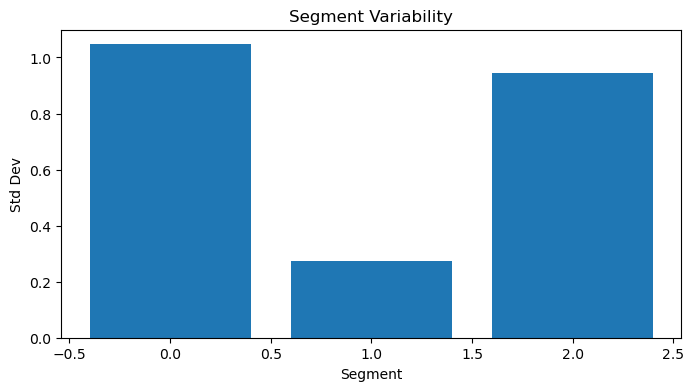

   start  end  variability
0      0  175     1.046733
1    175  350     0.273121
2    350  657     0.944106


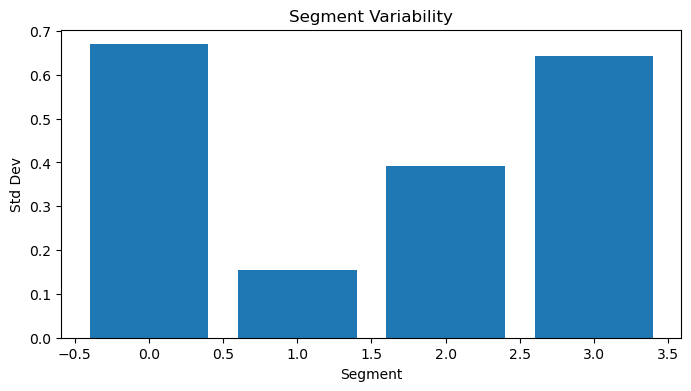

   start  end  variability
0      0  185     0.669275
1    185  345     0.154103
2    345  525     0.392022
3    525  720     0.642438


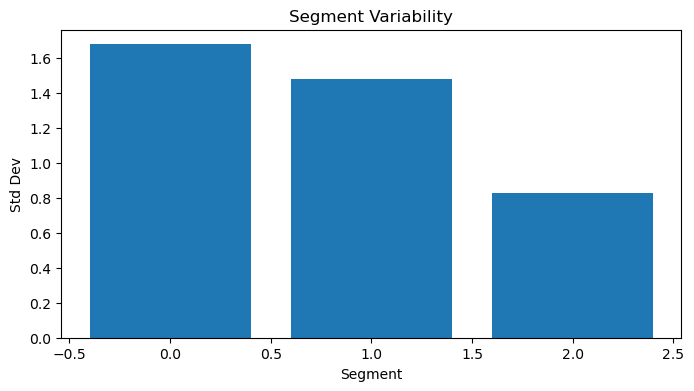

   start  end  variability
0      0  115     1.676635
1    115  530     1.478933
2    530  850     0.824457


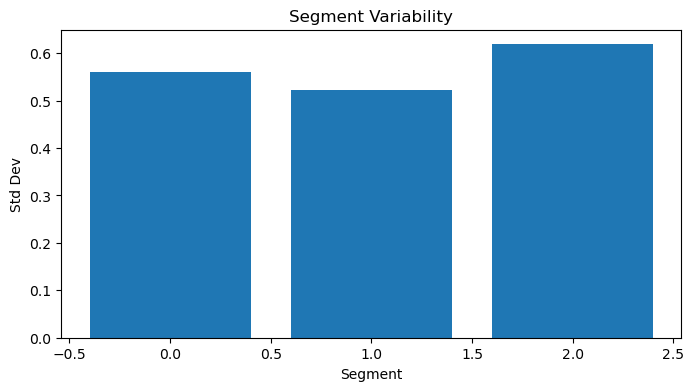

   start  end  variability
0      0  120     0.560311
1    120  545     0.521495
2    545  850     0.618272


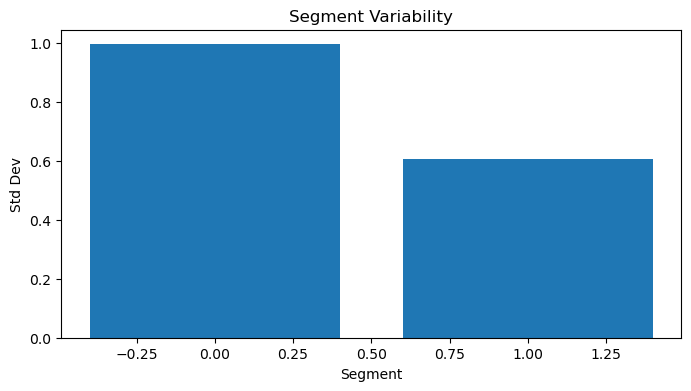

   start  end  variability
0      0  245     0.994791
1    245  620     0.606728


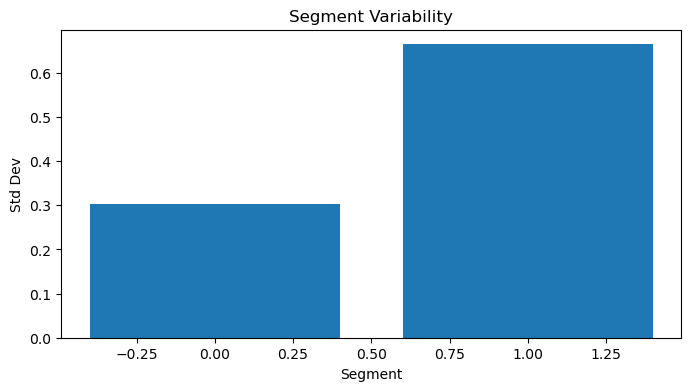

   start  end  variability
0      0  255     0.303426
1    255  625     0.664446


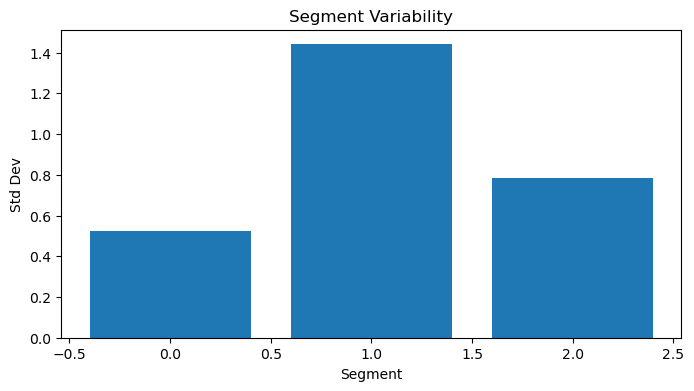

   start   end  variability
0      0   470     0.526110
1    470  1010     1.440133
2   1010  1195     0.781894


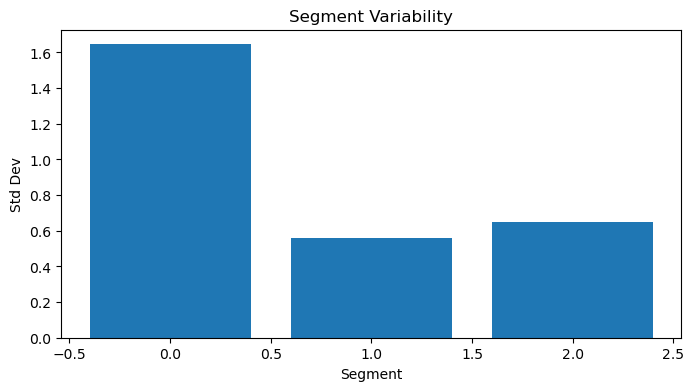

   start   end  variability
0      0   500     1.645130
1    500  1010     0.559317
2   1010  1200     0.651712


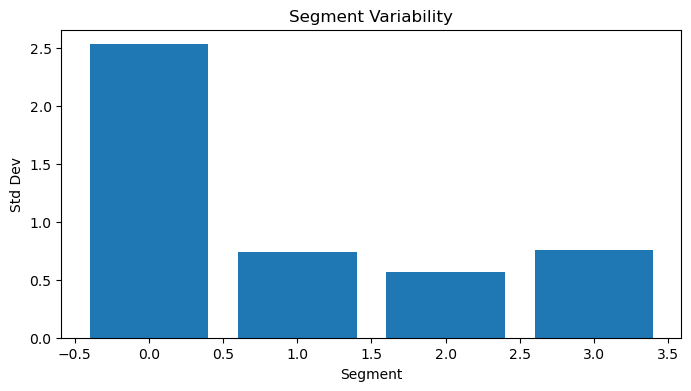

   start   end  variability
0      0   215     2.528822
1    215   630     0.739102
2    630   815     0.566360
3    815  1255     0.756952


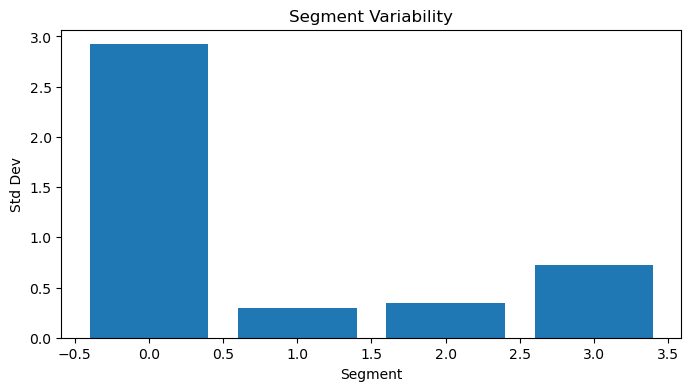

   start   end  variability
0      0   260     2.921259
1    260   645     0.299621
2    645   805     0.348415
3    805  1260     0.722683


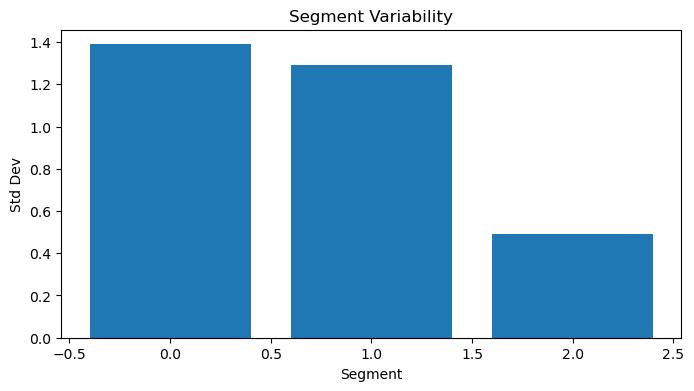

   start   end  variability
0      0   170     1.388847
1    170   565     1.289292
2    565  1085     0.493432


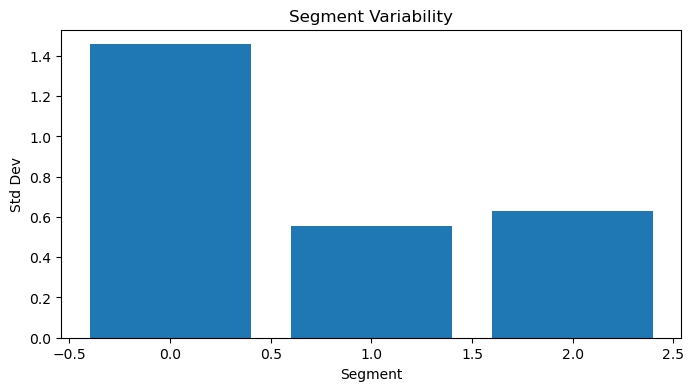

   start   end  variability
0      0   185     1.457253
1    185   565     0.556687
2    565  1080     0.632006


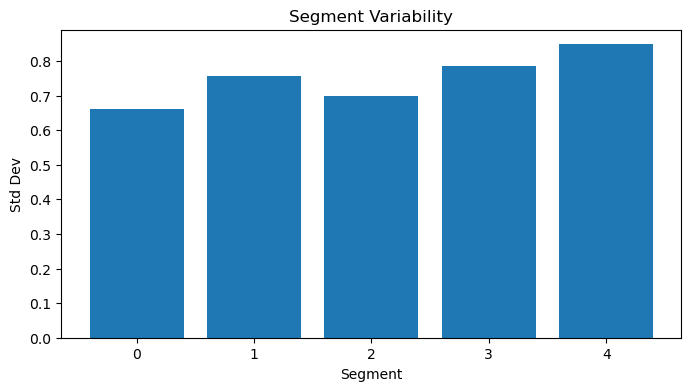

   start   end  variability
0      0   460     0.662477
1    460  1005     0.757373
2   1005  1210     0.697489
3   1210  1660     0.784742
4   1660  2000     0.847893


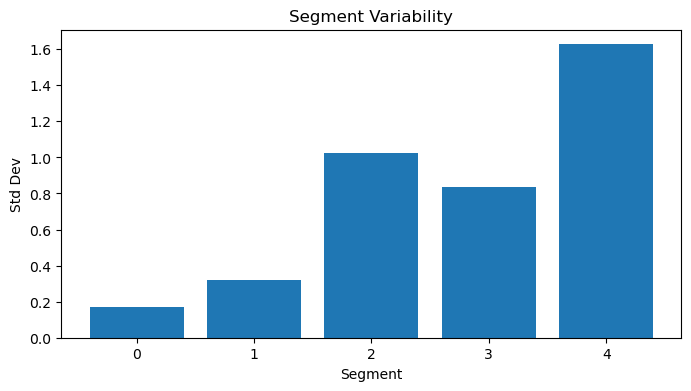

   start   end  variability
0      0   465     0.171660
1    465   995     0.319382
2    995  1210     1.025426
3   1210  1665     0.833555
4   1665  2057     1.626923


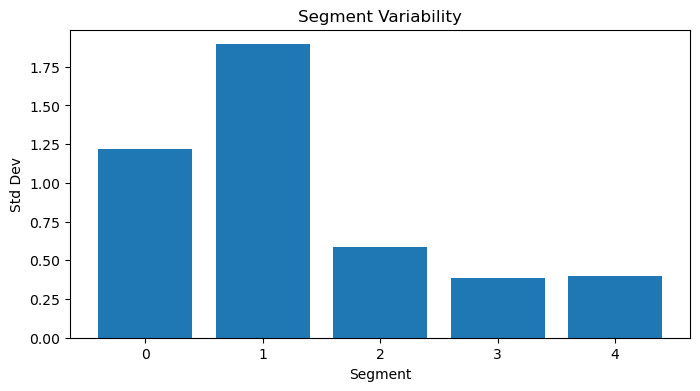

   start   end  variability
0      0    55     1.220550
1     55   460     1.894420
2    460  1120     0.588504
3   1120  1305     0.384118
4   1305  1675     0.397953


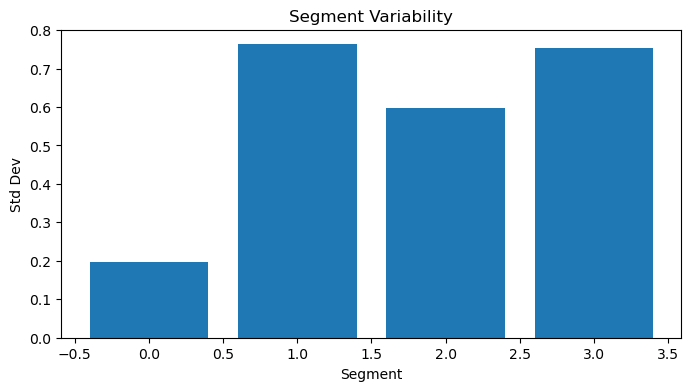

   start   end  variability
0      0   415     0.198179
1    415  1080     0.762742
2   1080  1315     0.597007
3   1315  1680     0.753235


In [175]:
# for each row in df_indices2

for idx, (_, row) in enumerate(df_indices2.iterrows()):
    depth = row['depth']
    view_type = row['view']
    averaged_points = row['averaged_points']


    # Find the correct PC1 row in pca1_df based on matching depth and view
    match = pca1_df[(pca1_df['depth'] == depth) & (pca1_df['view'] == view_type)]
    if match.empty:
        print(f"No PC1 data found for depth={depth}, view={view_type}")
        continue

    values_list = match['values'].iloc[0]  # Extract the list/array of PC1 values
    values_series = pd.Series(values_list, index=np.arange(len(values_list)))




    df_variability = segment_variability(values_series, averaged_points, plot=True, use_std=True)
    print(df_variability)


## Segment

Averaged cp list: [175, 350, 657]
3


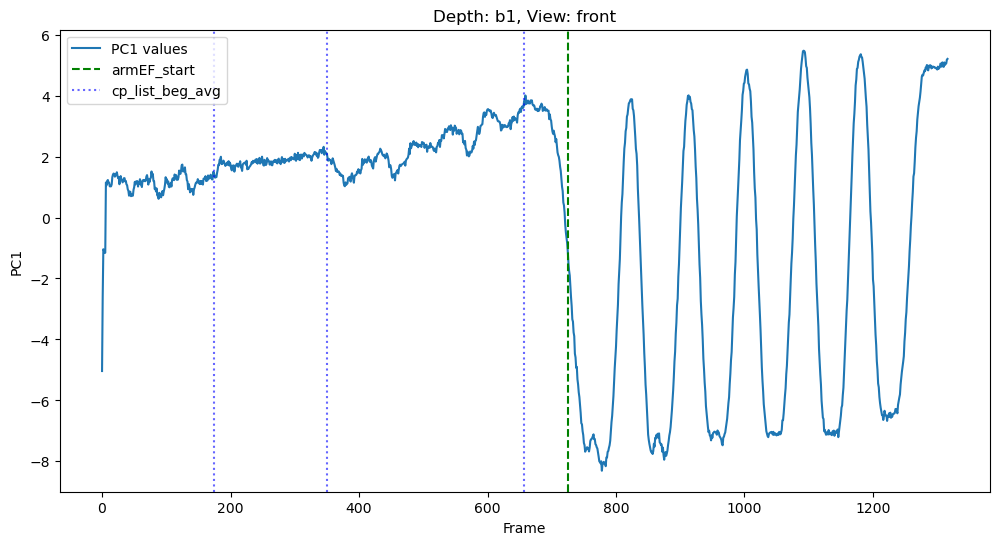

Averaged cp list: [185, 345, 525, 720]
4
first


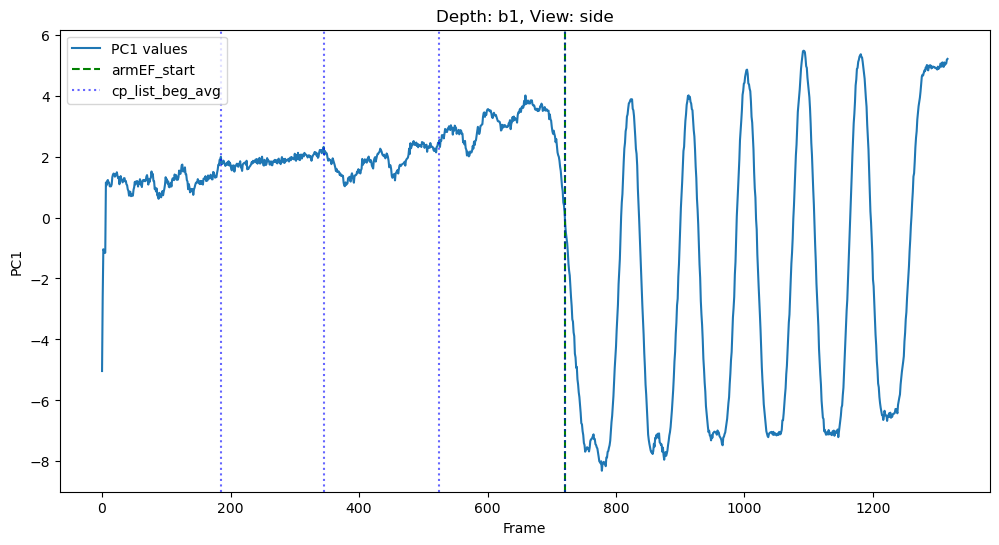

Averaged cp list: [115, 530, 850]
3


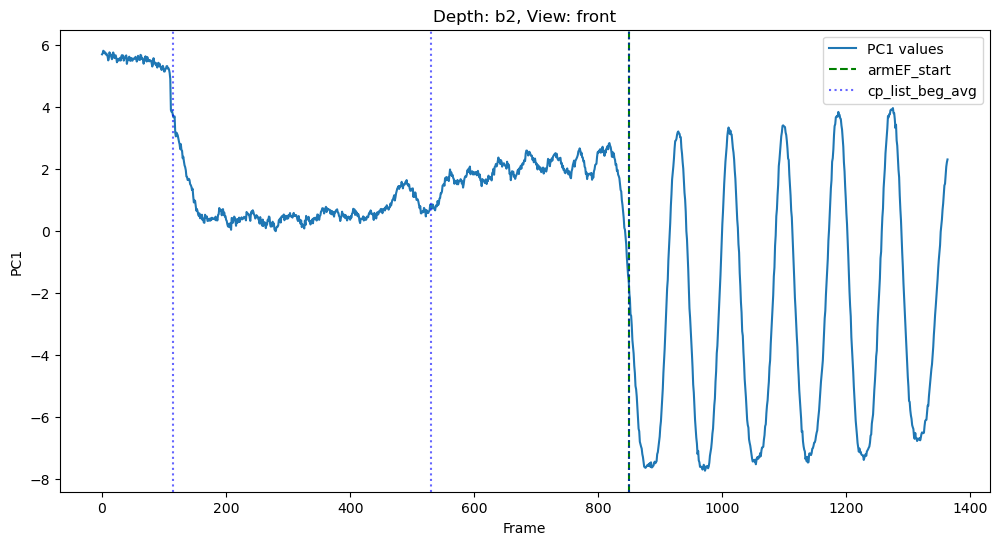

Averaged cp list: [120, 545, 850]
3


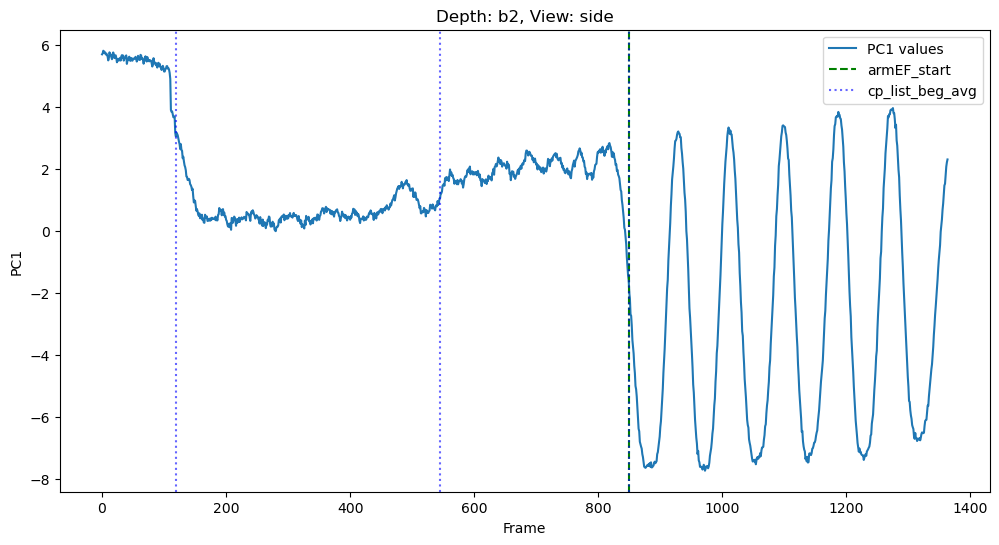

Averaged cp list: [245, 620]
2


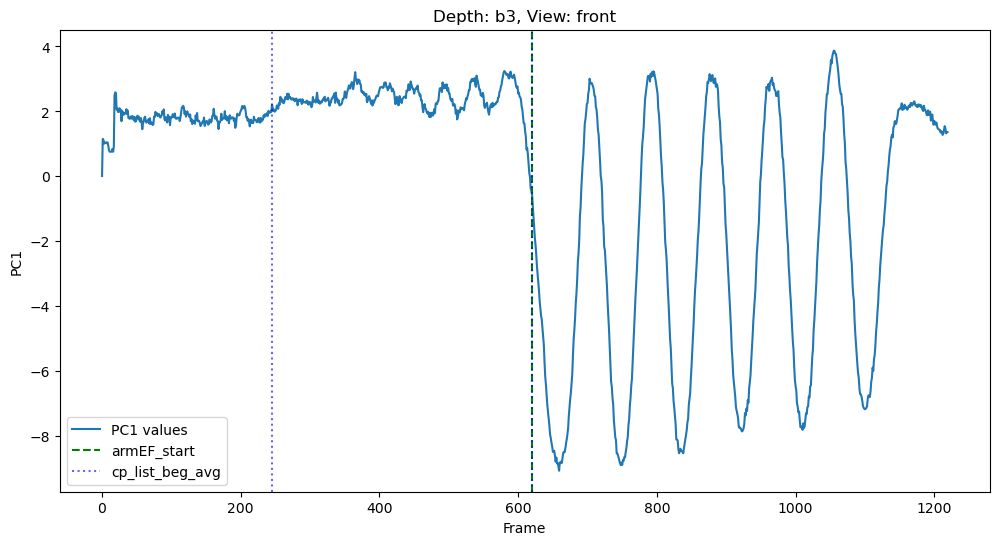

Averaged cp list: [255, 625]
2


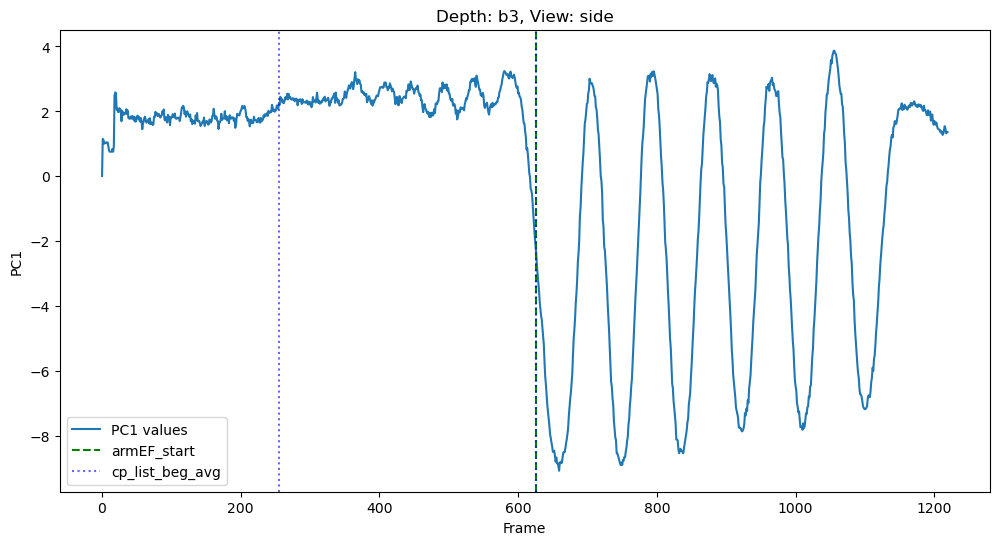

Averaged cp list: [470, 1010, 1195]
3


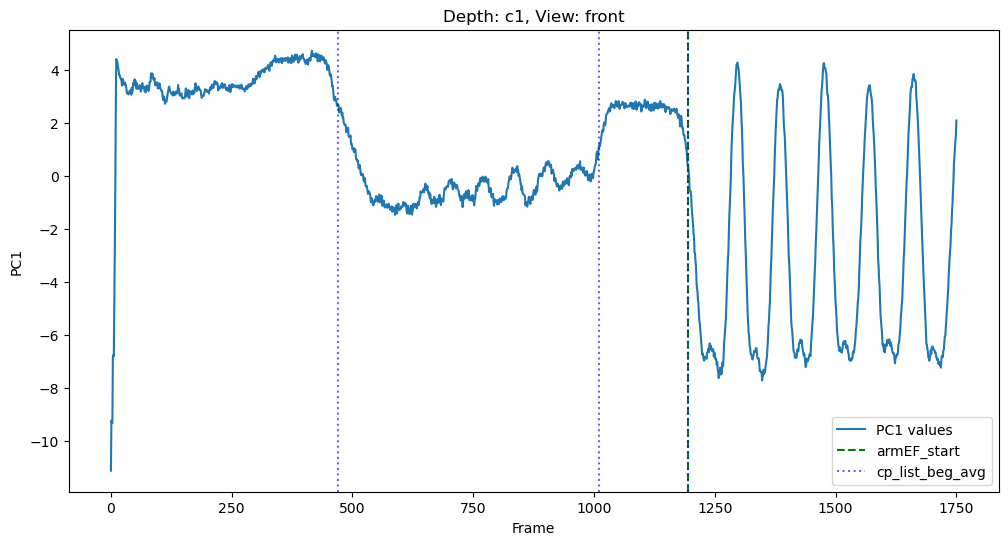

Averaged cp list: [500, 1010, 1200]
3


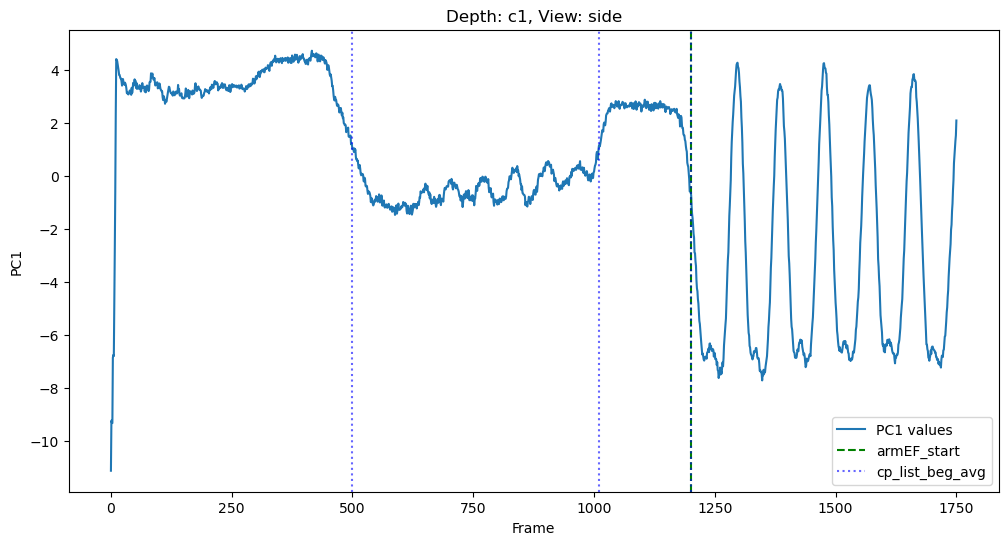

Averaged cp list: [215, 630, 815, 1255]
4
first


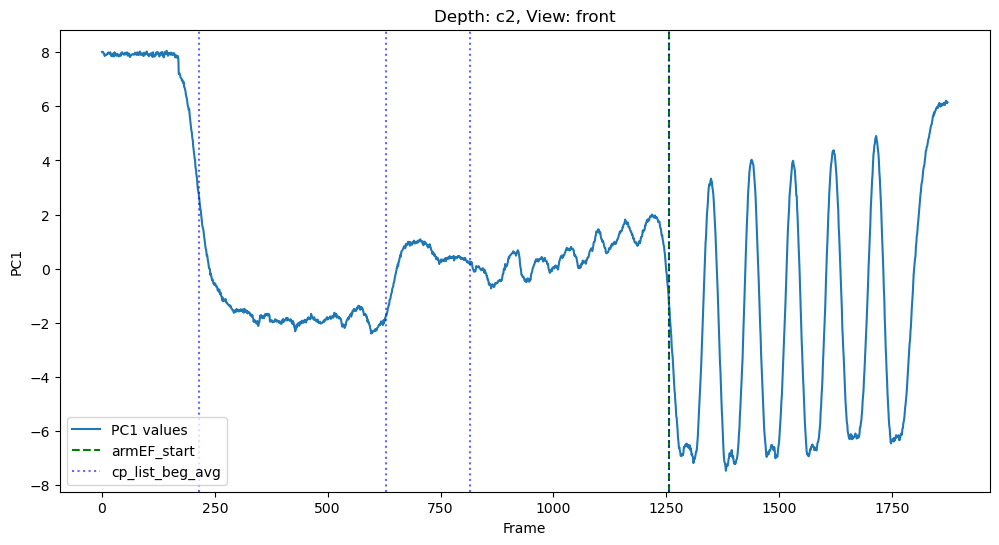

Averaged cp list: [260, 645, 805, 1260]
4
first


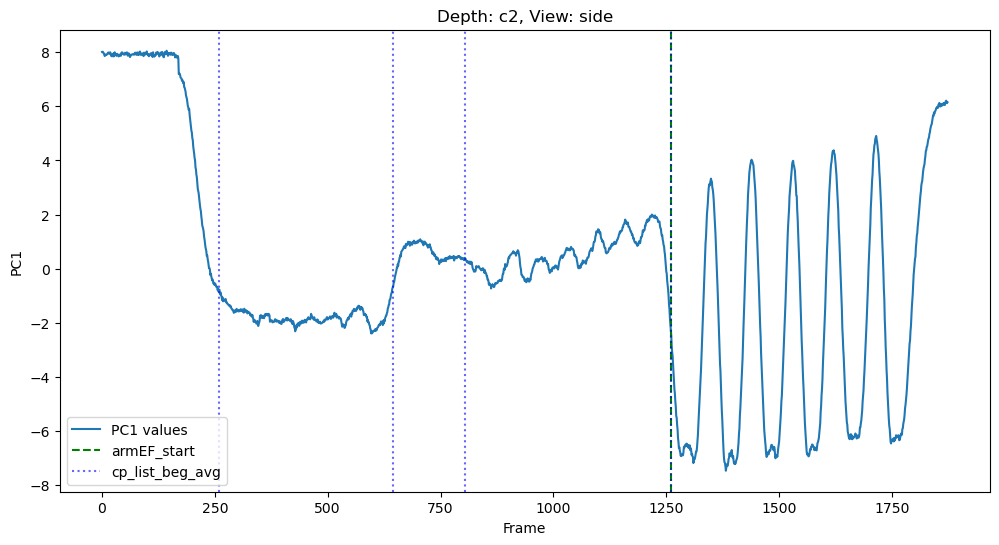

Averaged cp list: [170, 565, 1085]
3


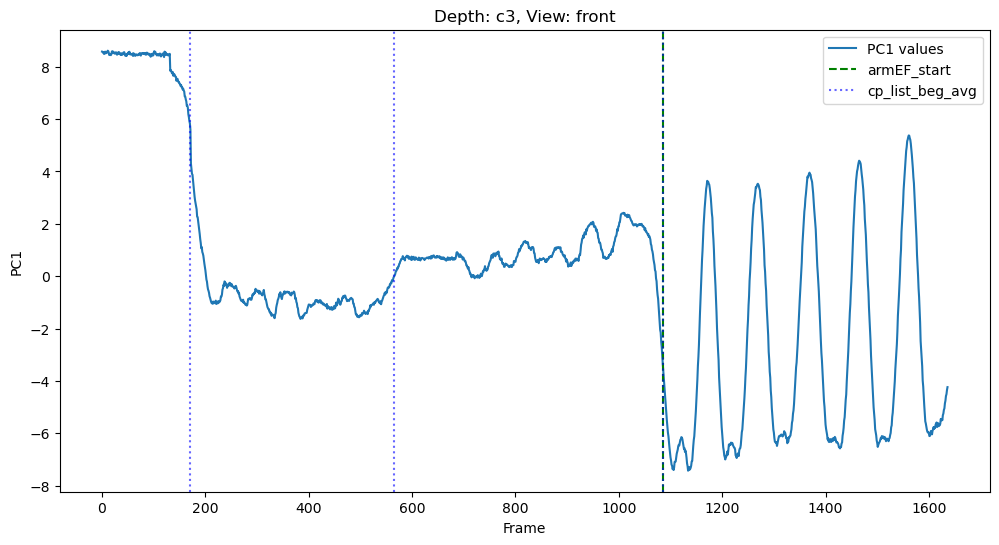

Averaged cp list: [185, 565, 1080]
3


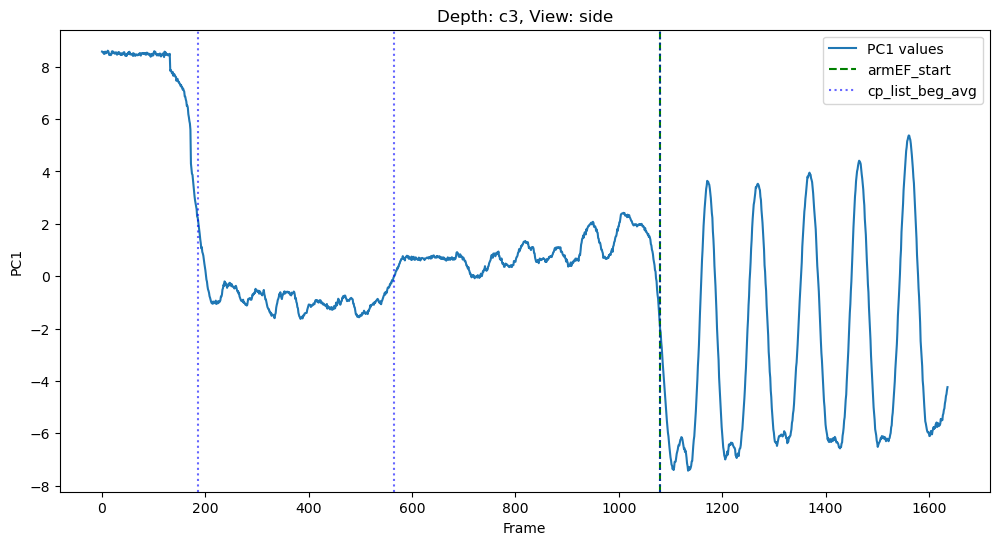

Averaged cp list: [460, 1005, 1210, 1660, 2000]
5


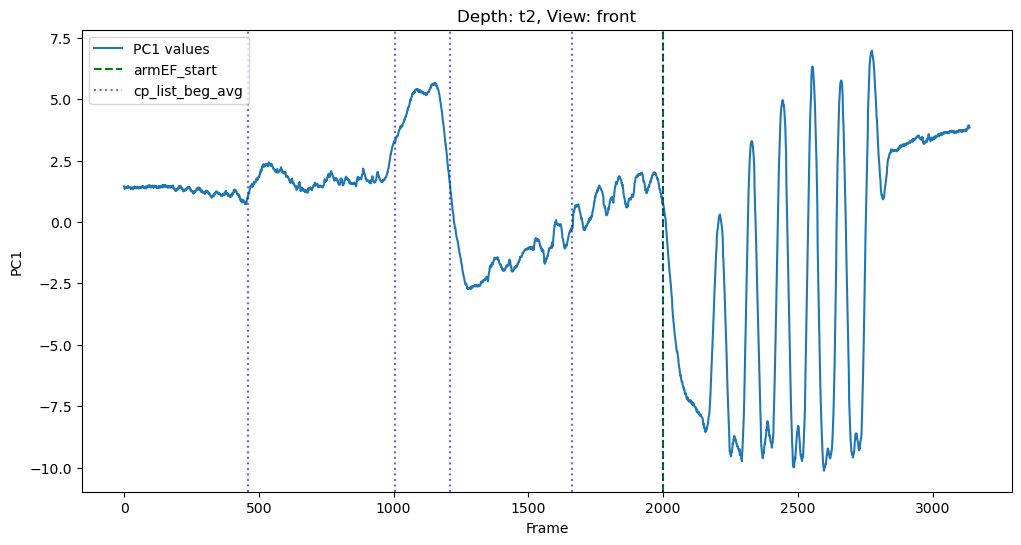

Averaged cp list: [465, 995, 1210, 1665, 2057]
5


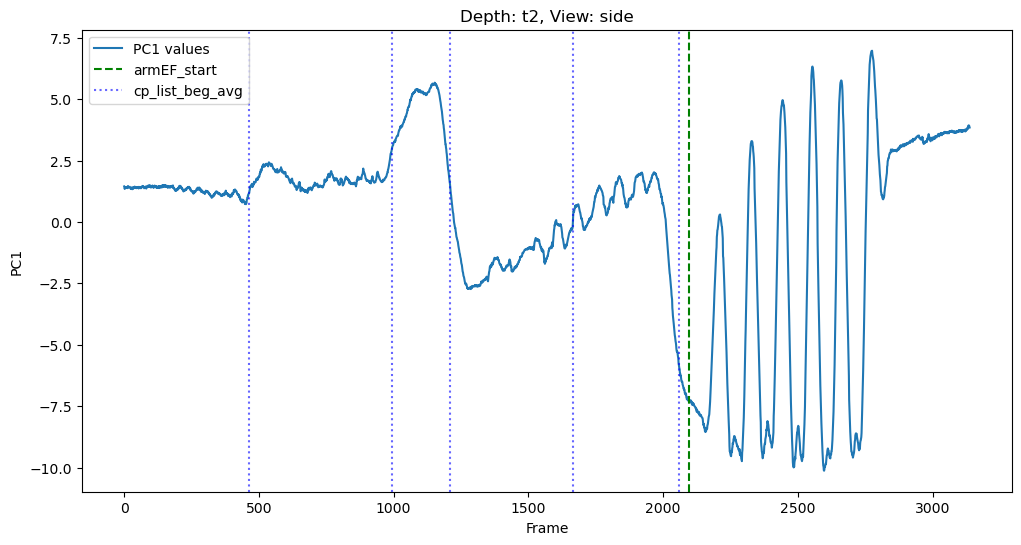

Averaged cp list: [55, 460, 1120, 1305, 1675]
5
first


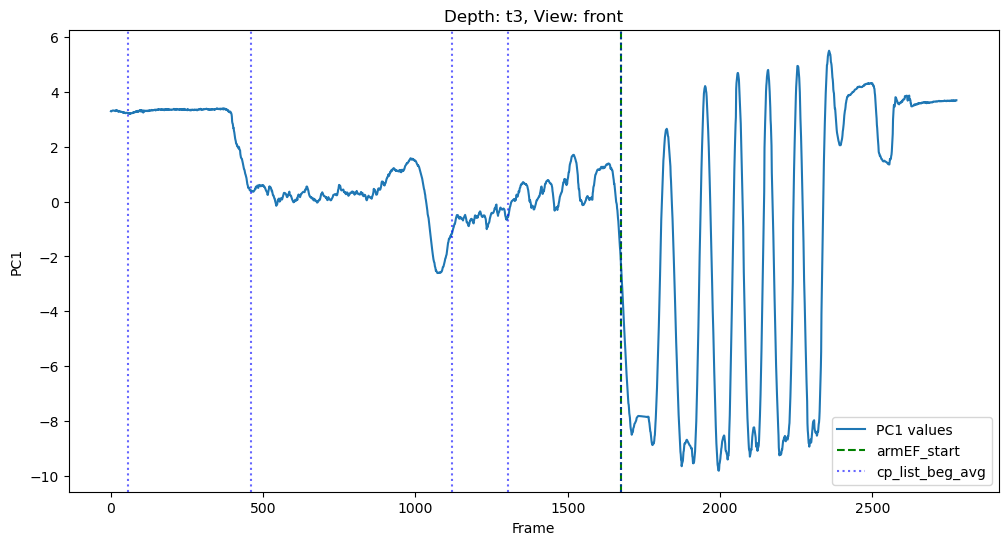

Averaged cp list: [415, 1080, 1315, 1680]
4


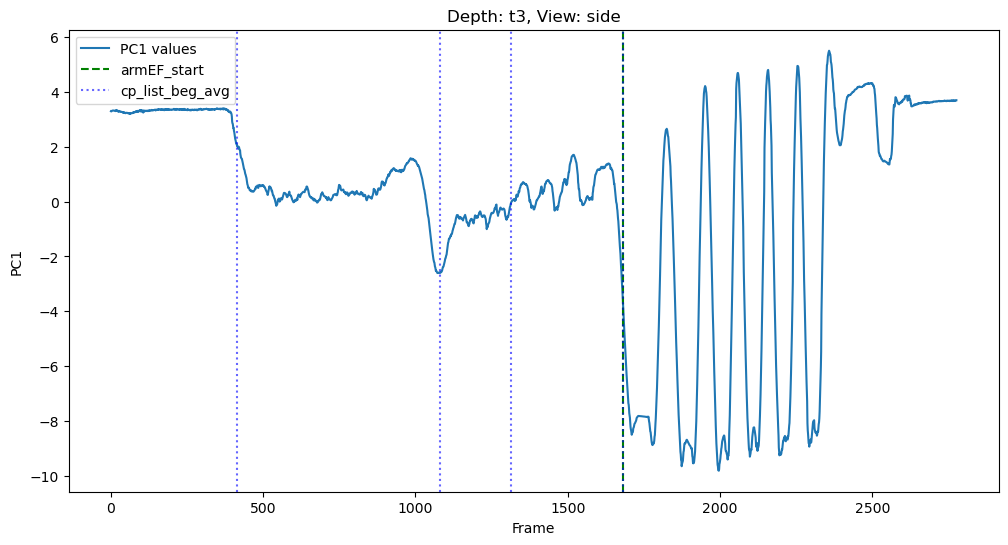

In [192]:
for idx, (depth, view) in enumerate(zip(df_movements['dataset'], df_movements['view'])):

    # skipping if the depth is not complete for trial
    if depth in skip_trails:
        continue
    
    armEF_start = df_movements.iloc[idx]['arm_EF'][0]  # First value of the tuple

    # gathering the indices created above
    cp_list_beg_avg = df_indices2.loc[
        (df_indices2['depth'] == depth) & (df_indices2['view'] == view), 'averaged_points'
    ].values

    if len(cp_list_beg_avg) == 1 and isinstance(cp_list_beg_avg[0], list):
        cp_list_beg_avg = cp_list_beg_avg[0]  # unwrap one layer


    print(f'Averaged cp list: {cp_list_beg_avg}')


    # Find the row index in df_movements for the current depth and view
    row_idx = df_movements[
        (df_movements['dataset'] == depth) & 
        (df_movements['view'] == view)
    ].index

    if not row_idx.empty:
            row_idx = row_idx[0]  # Get the actual index value

            print(len(cp_list_beg_avg))

            if len(cp_list_beg_avg) ==2:
                df_movements.at[row_idx, 'hand_OC'] = (0, cp_list_beg_avg[0])
                df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[0], armEF_start)
            elif len(cp_list_beg_avg) == 3:
                df_movements.at[row_idx, 'hand_OC'] = (cp_list_beg_avg[0], cp_list_beg_avg[1])
                df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[1], armEF_start)
                # this is the part i have not yet updated yet 
            elif cp_list_beg_avg[0] < 500 and cp_list_beg_avg[1] < 700: ### need to make a variable here that is patient specific
                # Update hand_OC and hand_PS columns directly
                print('first')
                df_movements.at[row_idx, 'hand_OC'] = (cp_list_beg_avg[1], cp_list_beg_avg[2])
                df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[2], armEF_start)
            else:
                df_movements.at[row_idx, 'hand_OC'] = (cp_list_beg_avg[0], cp_list_beg_avg[1])
                df_movements.at[row_idx, 'hand_PS'] = (cp_list_beg_avg[1], armEF_start)

    else:
        print(f"Row not found for dataset={depth}, view={view}")
    
    # Get your dataframe with top PC1 feature for this depth & view
    df_key = depth + ('f' if view == 'front' else 's')
    if df_key not in dataframes:
        print(f"Missing df for {df_key}")
        continue
    df = dataframes[df_key]


    # Find the correct PC1 row in pca1_df based on matching depth and view
    match = pca1_df[(pca1_df['depth'] == depth) & (pca1_df['view'] == view_type)]
    if match.empty:
        print(f"No PC1 data found for depth={depth}, view={view_type}")
        continue

    values_list = match['values'].iloc[0]  # Extract the list/array of PC1 values
    x = pd.Series(values_list, index=np.arange(len(values_list)))
    t = np.arange(len(x))
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(t, x, label=f"{'PC1'} values")
    
    # Plot armEF_start as vertical line
    plt.axvline(armEF_start, color='green', linestyle='--', label='armEF_start')
    
    # Plot change points
    for cp in cp_list_beg_avg:
        plt.axvline(cp, color='blue', linestyle=':', alpha=0.6, label='cp_list_beg_avg' if cp == cp_list_beg_avg[0] else "")

    
    plt.title(f"Depth: {depth}, View: {view}")
    plt.xlabel('Frame')
    plt.ylabel('PC1')
    plt.legend()
    plt.show()


In [186]:
df_movements

dataset   view        arm_EF      hand_OC       hand_PS
0       b1  front   (725, 1298)   (175, 350)    (350, 725)
1       b1   side   (720, 1291)   (345, 525)    (525, 720)
2       b2  front   (850, 1361)   (115, 530)    (530, 850)
3       b2   side   (850, 1364)   (120, 545)    (545, 850)
4       b3  front   (620, 1158)     (0, 245)    (245, 620)
5       b3   side   (625, 1177)     (0, 255)    (255, 625)
6       c1  front  (1195, 1777)  (470, 1010)  (1010, 1195)
7       c1   side  (1200, 1751)  (500, 1010)  (1010, 1200)
8       c2  front  (1255, 1842)   (630, 815)   (815, 1255)
9       c2   side  (1260, 1842)   (645, 805)   (805, 1260)
10      c3  front  (1085, 1653)   (170, 565)   (565, 1085)
11      c3   side  (1080, 1637)   (185, 565)   (565, 1080)
12      t2  front  (2000, 2782)  (460, 1005)  (1005, 2000)
13      t2   side  (2095, 2755)   (465, 995)   (995, 2095)
14      t3  front  (1675, 2340)  (460, 1120)  (1120, 1675)
15      t3   side  (1680, 2340)  (415, 1080)  (1080, 1680)

Segments: arm_EF=(725,1298), hand_OC=(175,350), hand_PS=(350,725)
PC1 length: 1331


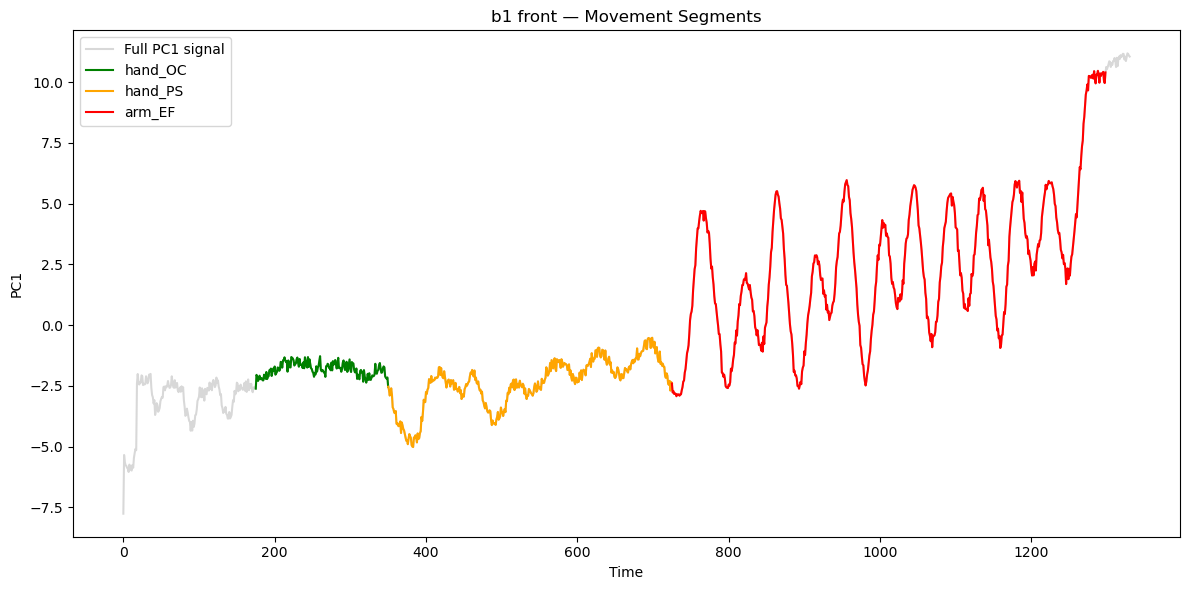

Segments: arm_EF=(720,1291), hand_OC=(345,525), hand_PS=(525,720)
PC1 length: 1317


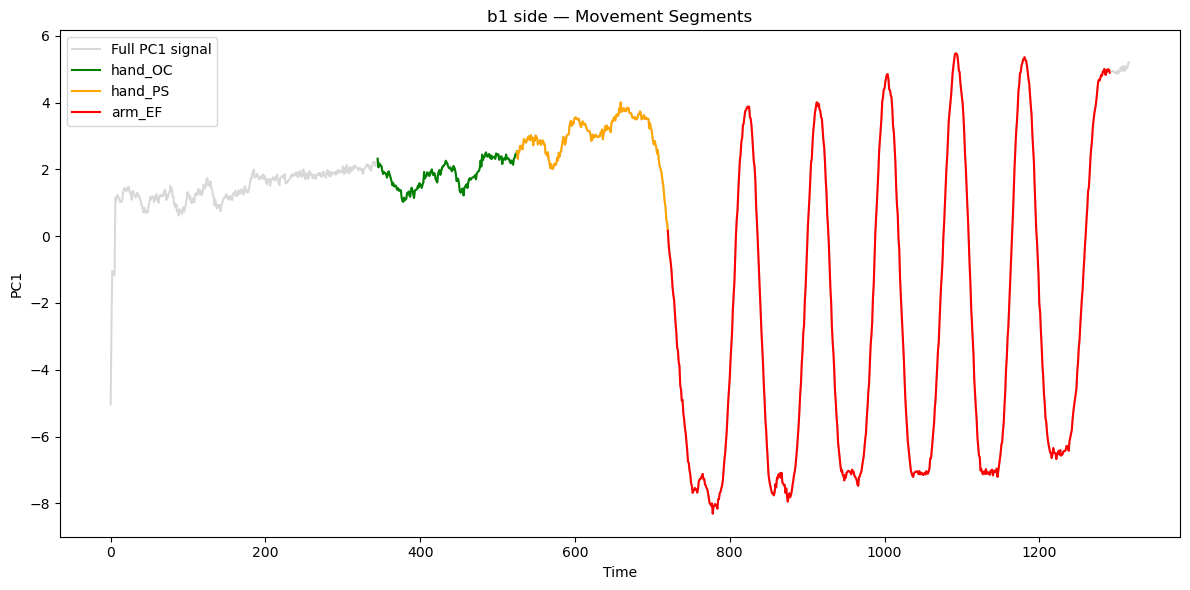

Segments: arm_EF=(850,1361), hand_OC=(115,530), hand_PS=(530,850)
PC1 length: 1361


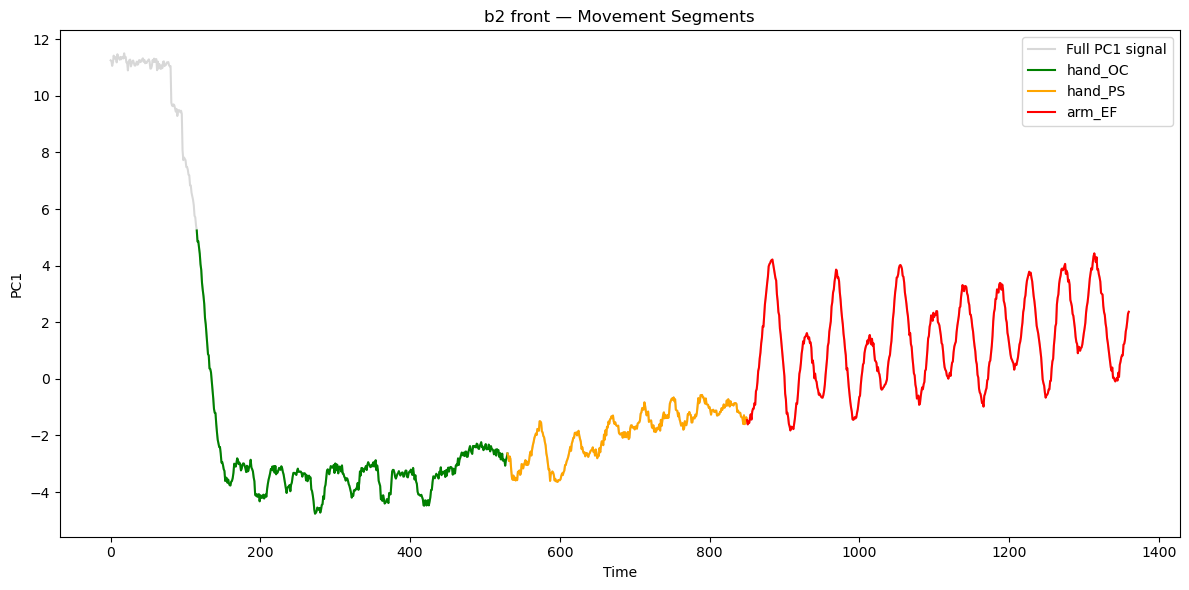

Segments: arm_EF=(850,1364), hand_OC=(120,545), hand_PS=(545,850)
PC1 length: 1364


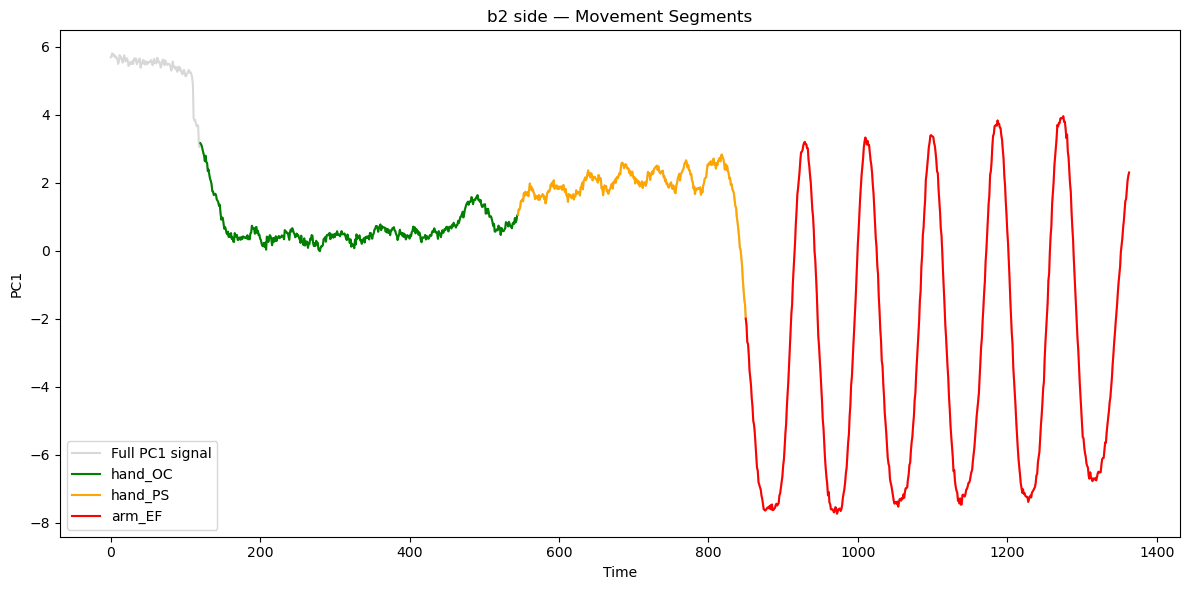

Segments: arm_EF=(620,1158), hand_OC=(0,245), hand_PS=(245,620)
PC1 length: 1181


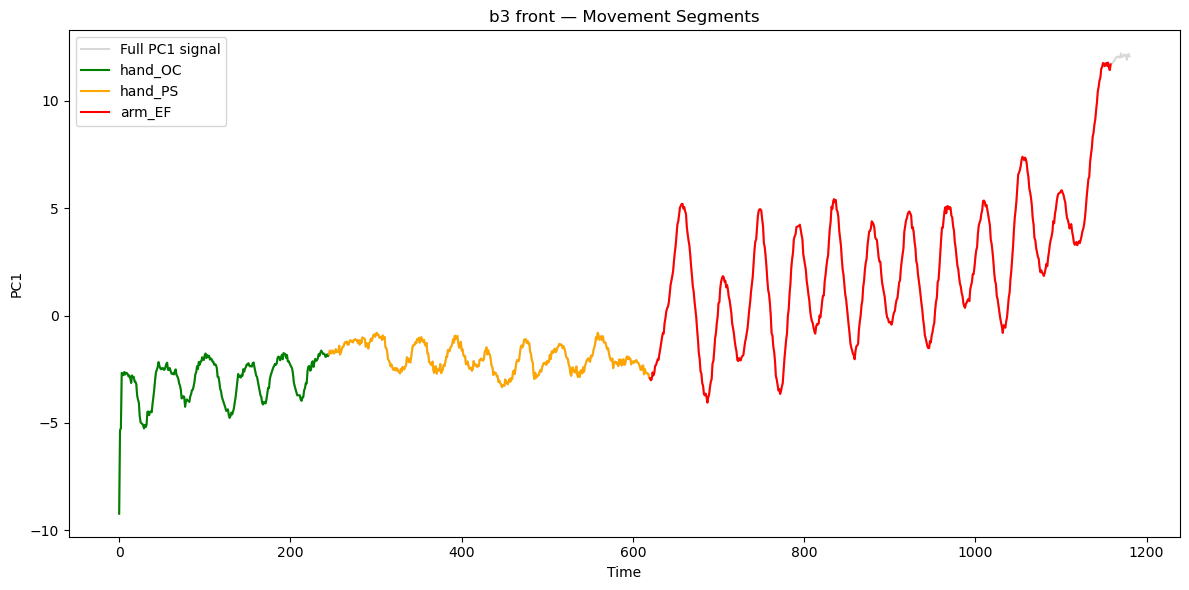

Segments: arm_EF=(625,1177), hand_OC=(0,255), hand_PS=(255,625)
PC1 length: 1220


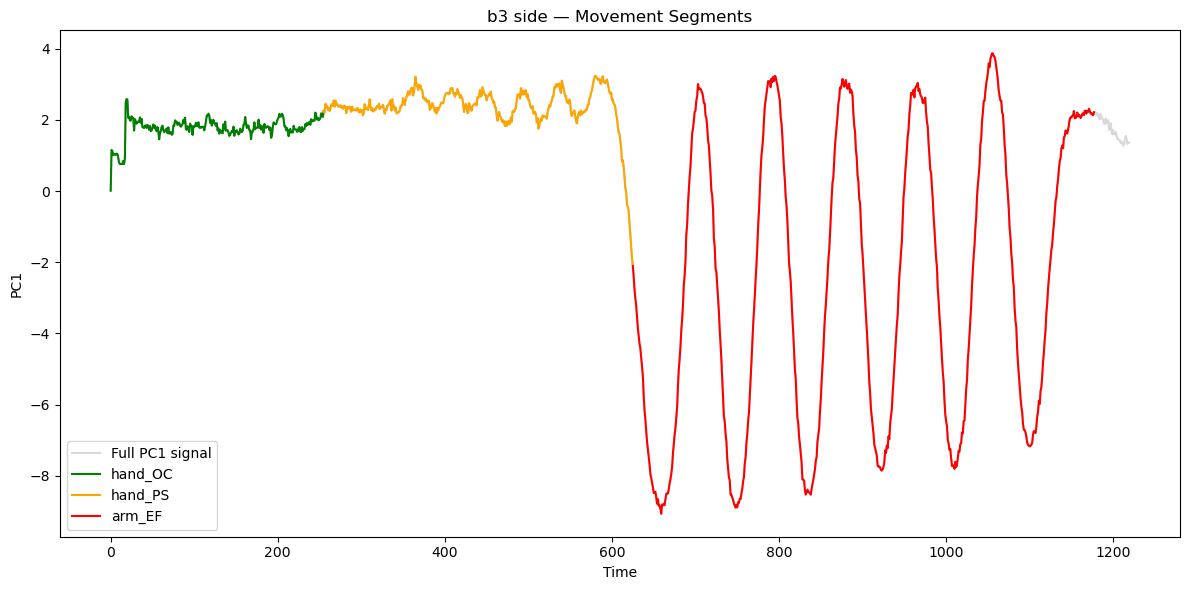

Segments: arm_EF=(1195,1777), hand_OC=(470,1010), hand_PS=(1010,1195)
PC1 length: 1777


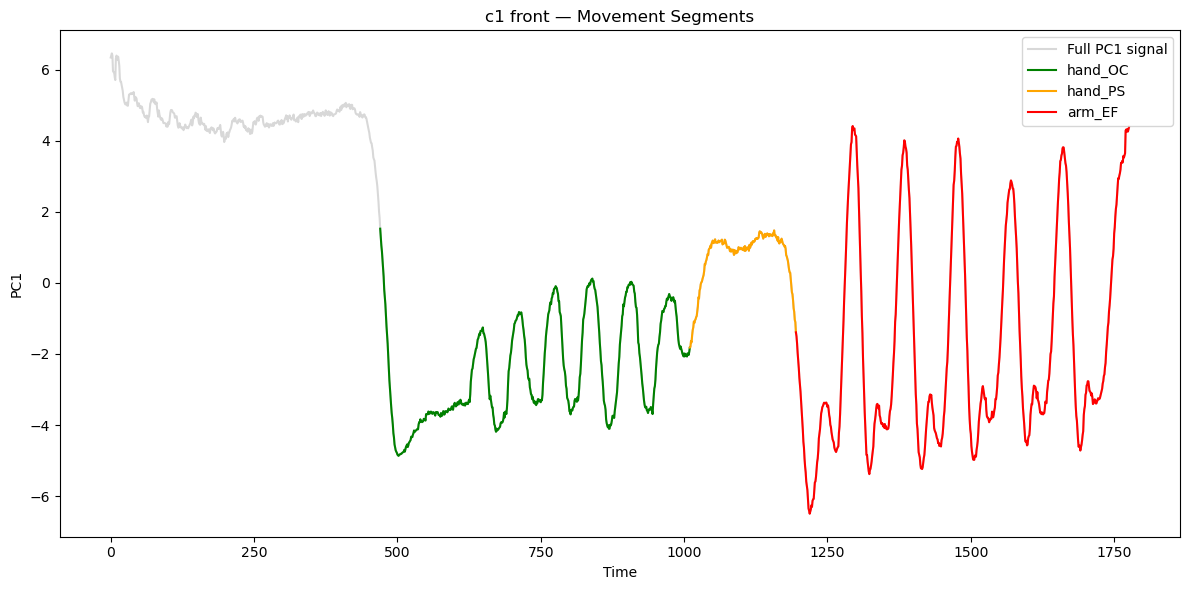

Segments: arm_EF=(1200,1751), hand_OC=(500,1010), hand_PS=(1010,1200)
PC1 length: 1751


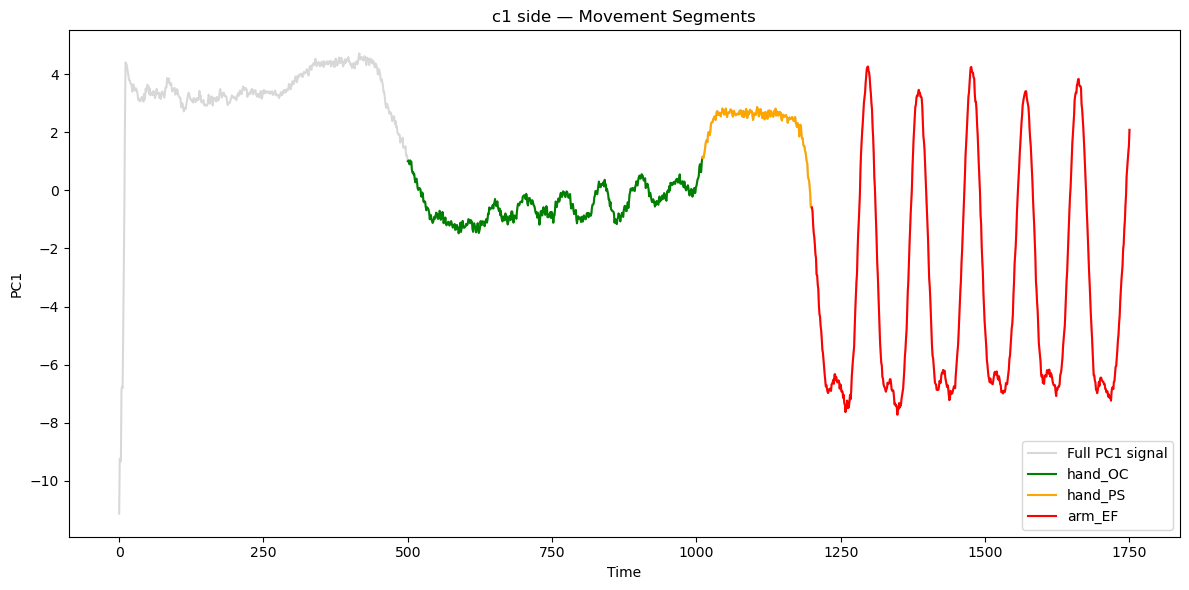

Segments: arm_EF=(1255,1842), hand_OC=(630,815), hand_PS=(815,1255)
PC1 length: 1842


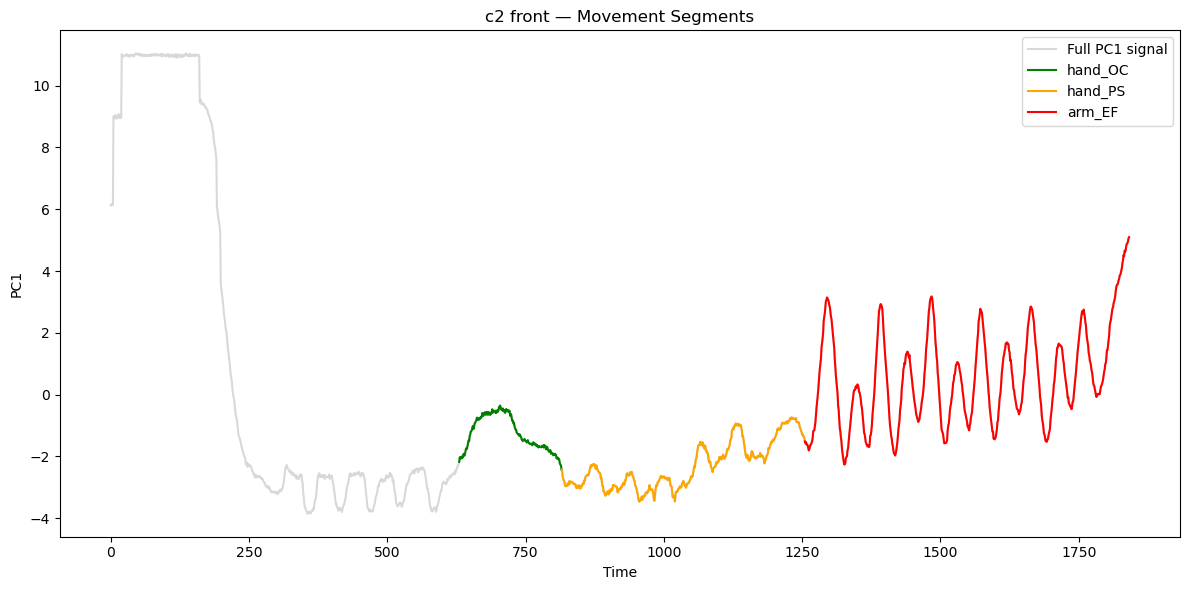

Segments: arm_EF=(1260,1842), hand_OC=(645,805), hand_PS=(805,1260)
PC1 length: 1874


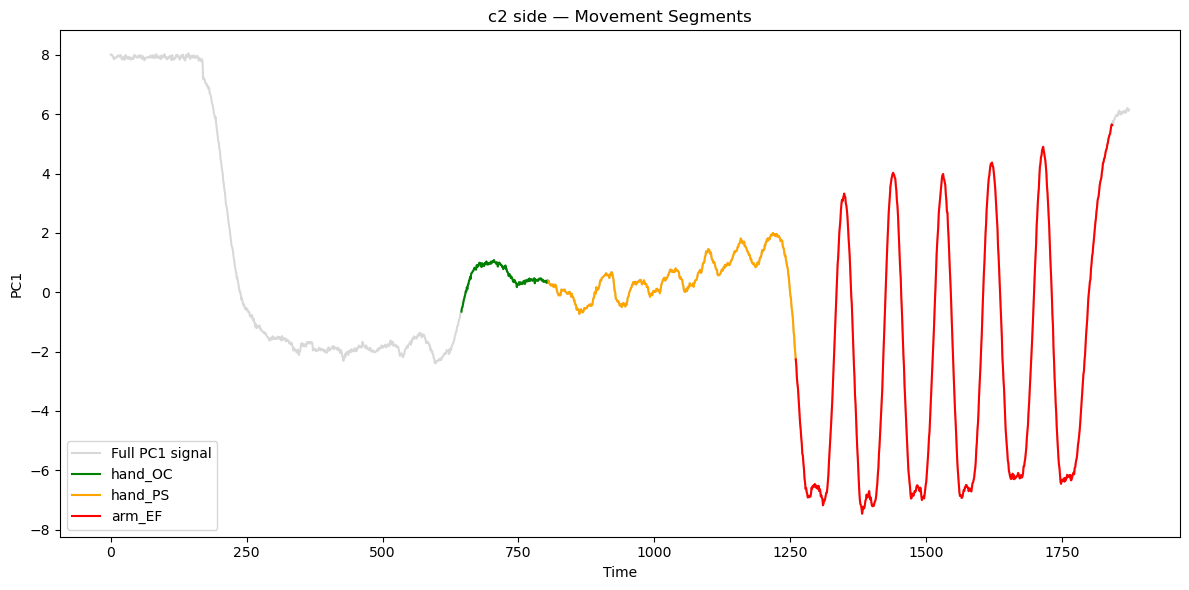

Segments: arm_EF=(1085,1653), hand_OC=(170,565), hand_PS=(565,1085)
PC1 length: 1653


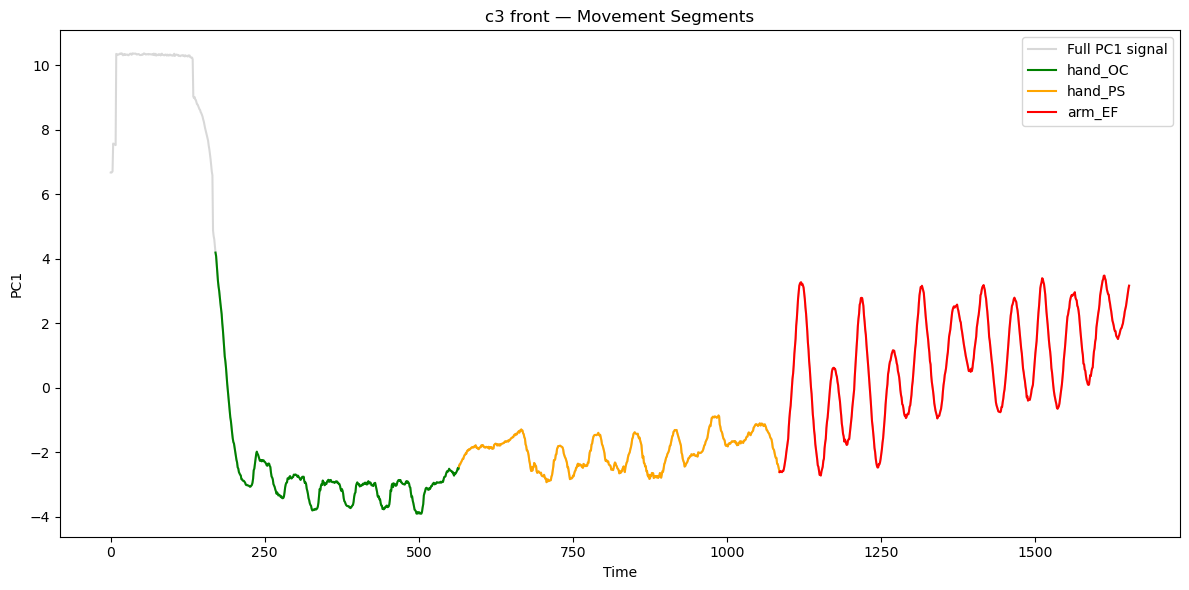

Segments: arm_EF=(1080,1637), hand_OC=(185,565), hand_PS=(565,1080)
PC1 length: 1637


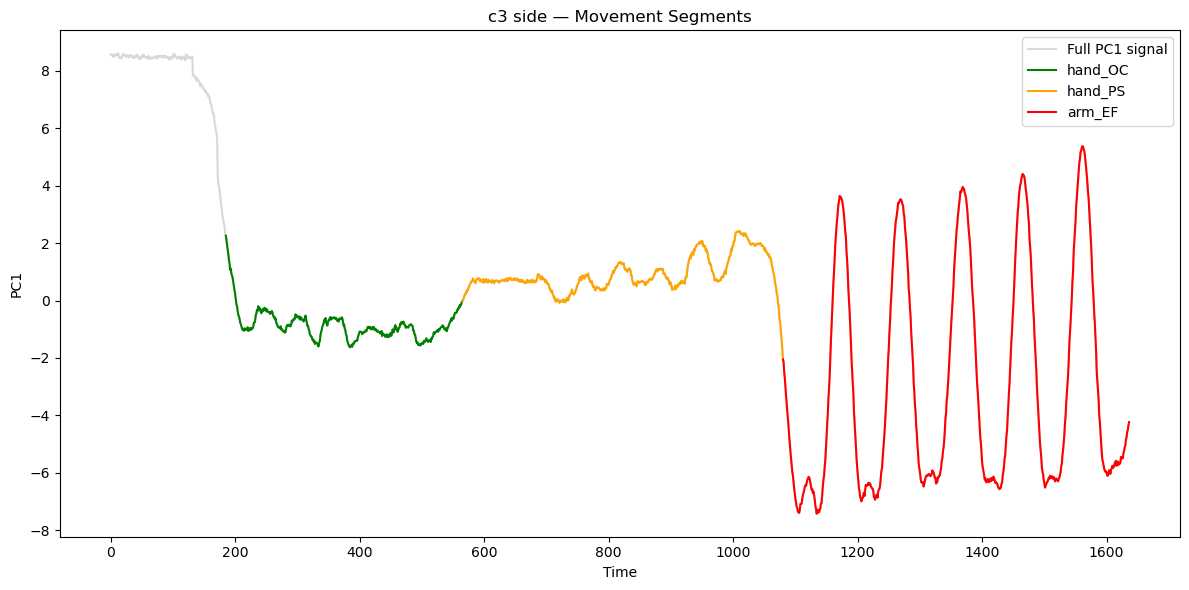

Segments: arm_EF=(2000,2782), hand_OC=(460,1005), hand_PS=(1005,2000)
PC1 length: 3131


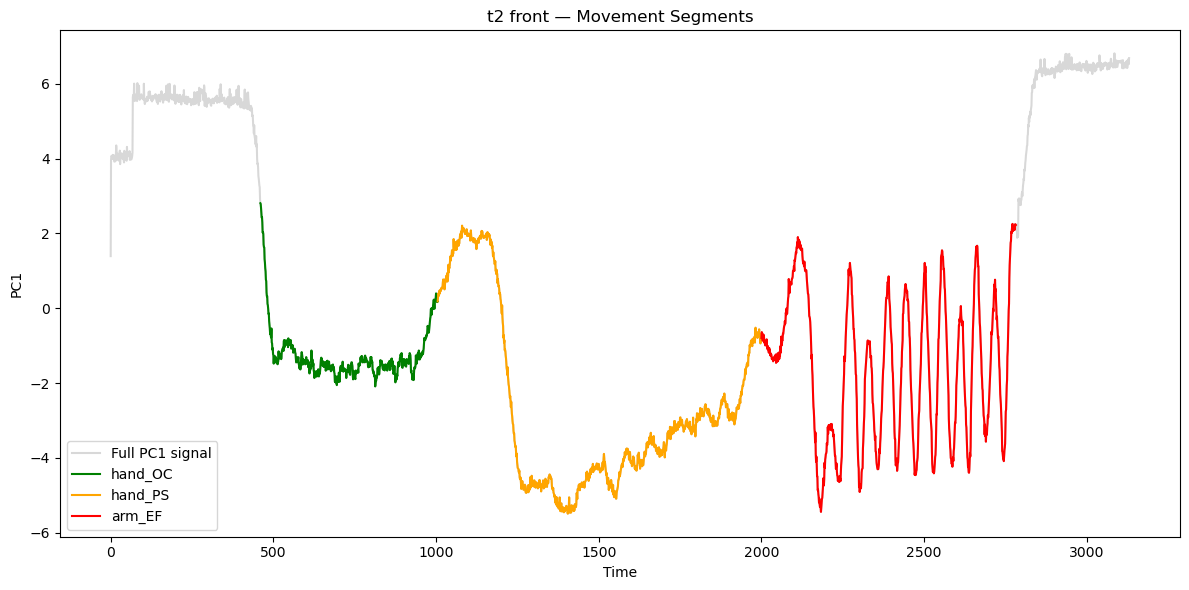

Segments: arm_EF=(2095,2755), hand_OC=(465,995), hand_PS=(995,2095)
PC1 length: 3138


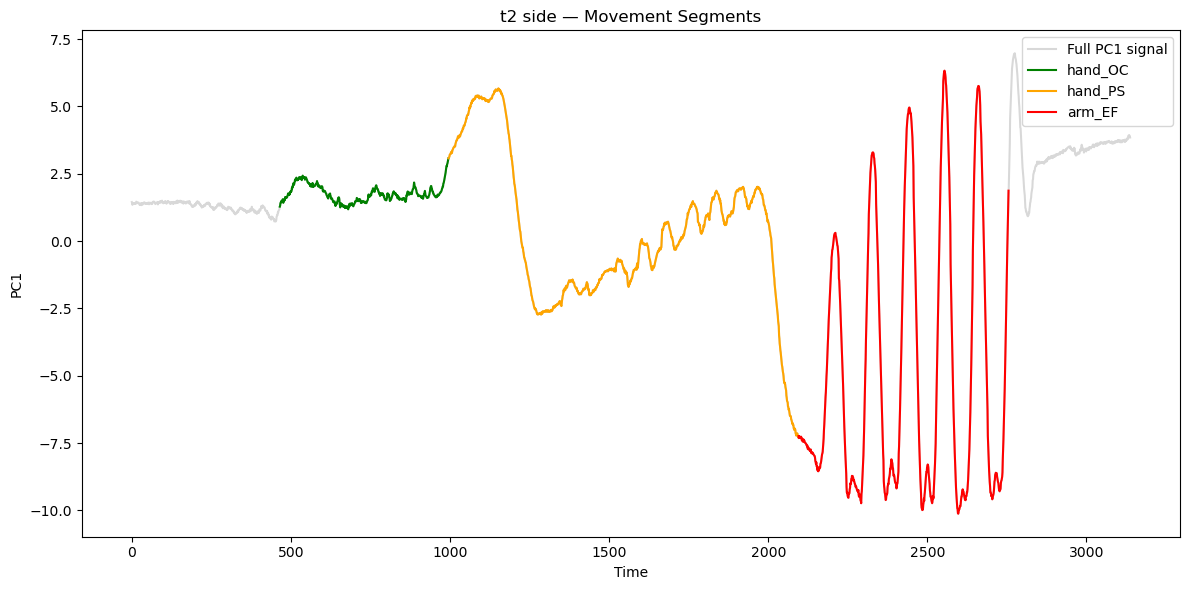

Segments: arm_EF=(1675,2340), hand_OC=(460,1120), hand_PS=(1120,1675)
PC1 length: 2758


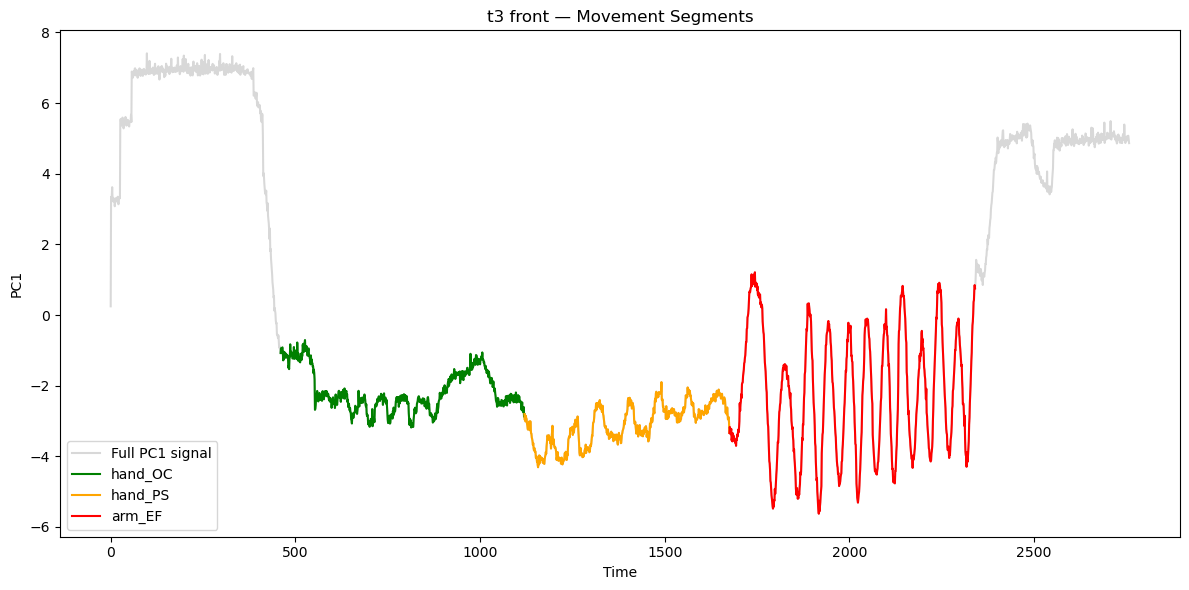

Segments: arm_EF=(1680,2340), hand_OC=(415,1080), hand_PS=(1080,1680)
PC1 length: 2777


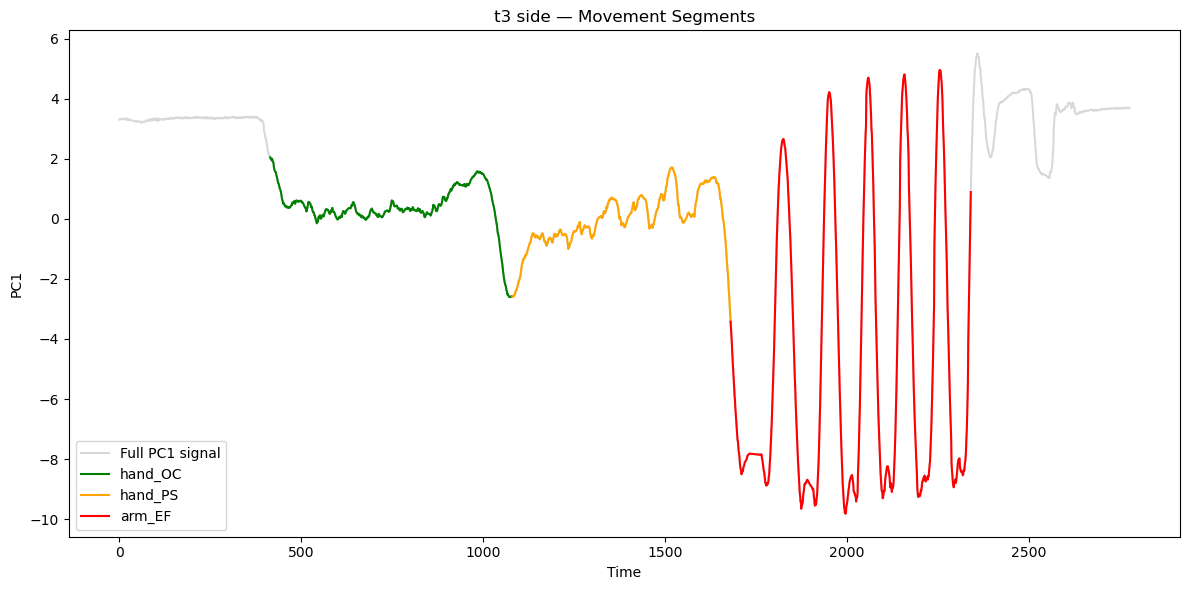

In [187]:
for idx, row in df_movements.iterrows():
    dataset = row['dataset']
    view = row['view']

    df_key = dataset + ('f' if view == 'front' else 's')
    if df_key not in dataframes:
        print(f"Skipping {df_key} — data not found.")
        continue

    match = pca1_df[(pca1_df['depth'] == dataset) & (pca1_df['view'] == view)]
    if match.empty:
        print(f"No PC1 data found for depth={dataset}, view={view}")
        continue

    values_list = match['values'].iloc[0]
    x = pd.Series(values_list, index=np.arange(len(values_list)))
    t = np.arange(len(x))

    # Cast to int to avoid slicing errors
    armEF_start, armEF_end = map(int, row['arm_EF'])
    handOC_start, handOC_end = map(int, row['hand_OC'])
    handPS_start, handPS_end = map(int, row['hand_PS'])

    print(f"Segments: arm_EF=({armEF_start},{armEF_end}), hand_OC=({handOC_start},{handOC_end}), hand_PS=({handPS_start},{handPS_end})")
    print(f"PC1 length: {len(x)}")

    plt.figure(figsize=(12, 6))
    plt.plot(t, x, color='gray', alpha=0.3, label='Full PC1 signal')

    plt.plot(t[handOC_start:handOC_end+1], x[handOC_start:handOC_end+1], color=movement_colors['hand_OC'], label='hand_OC')
    plt.plot(t[handPS_start:handPS_end+1], x[handPS_start:handPS_end+1], color=movement_colors['hand_PS'], label='hand_PS')
    plt.plot(t[armEF_start:armEF_end+1], x[armEF_start:armEF_end+1], color=movement_colors['arm_EF'], label='arm_EF')

    plt.title(f"{dataset} {view} — Movement Segments")
    plt.xlabel("Time")
    plt.ylabel("PC1")
    plt.legend()
    plt.tight_layout()
    plt.show()


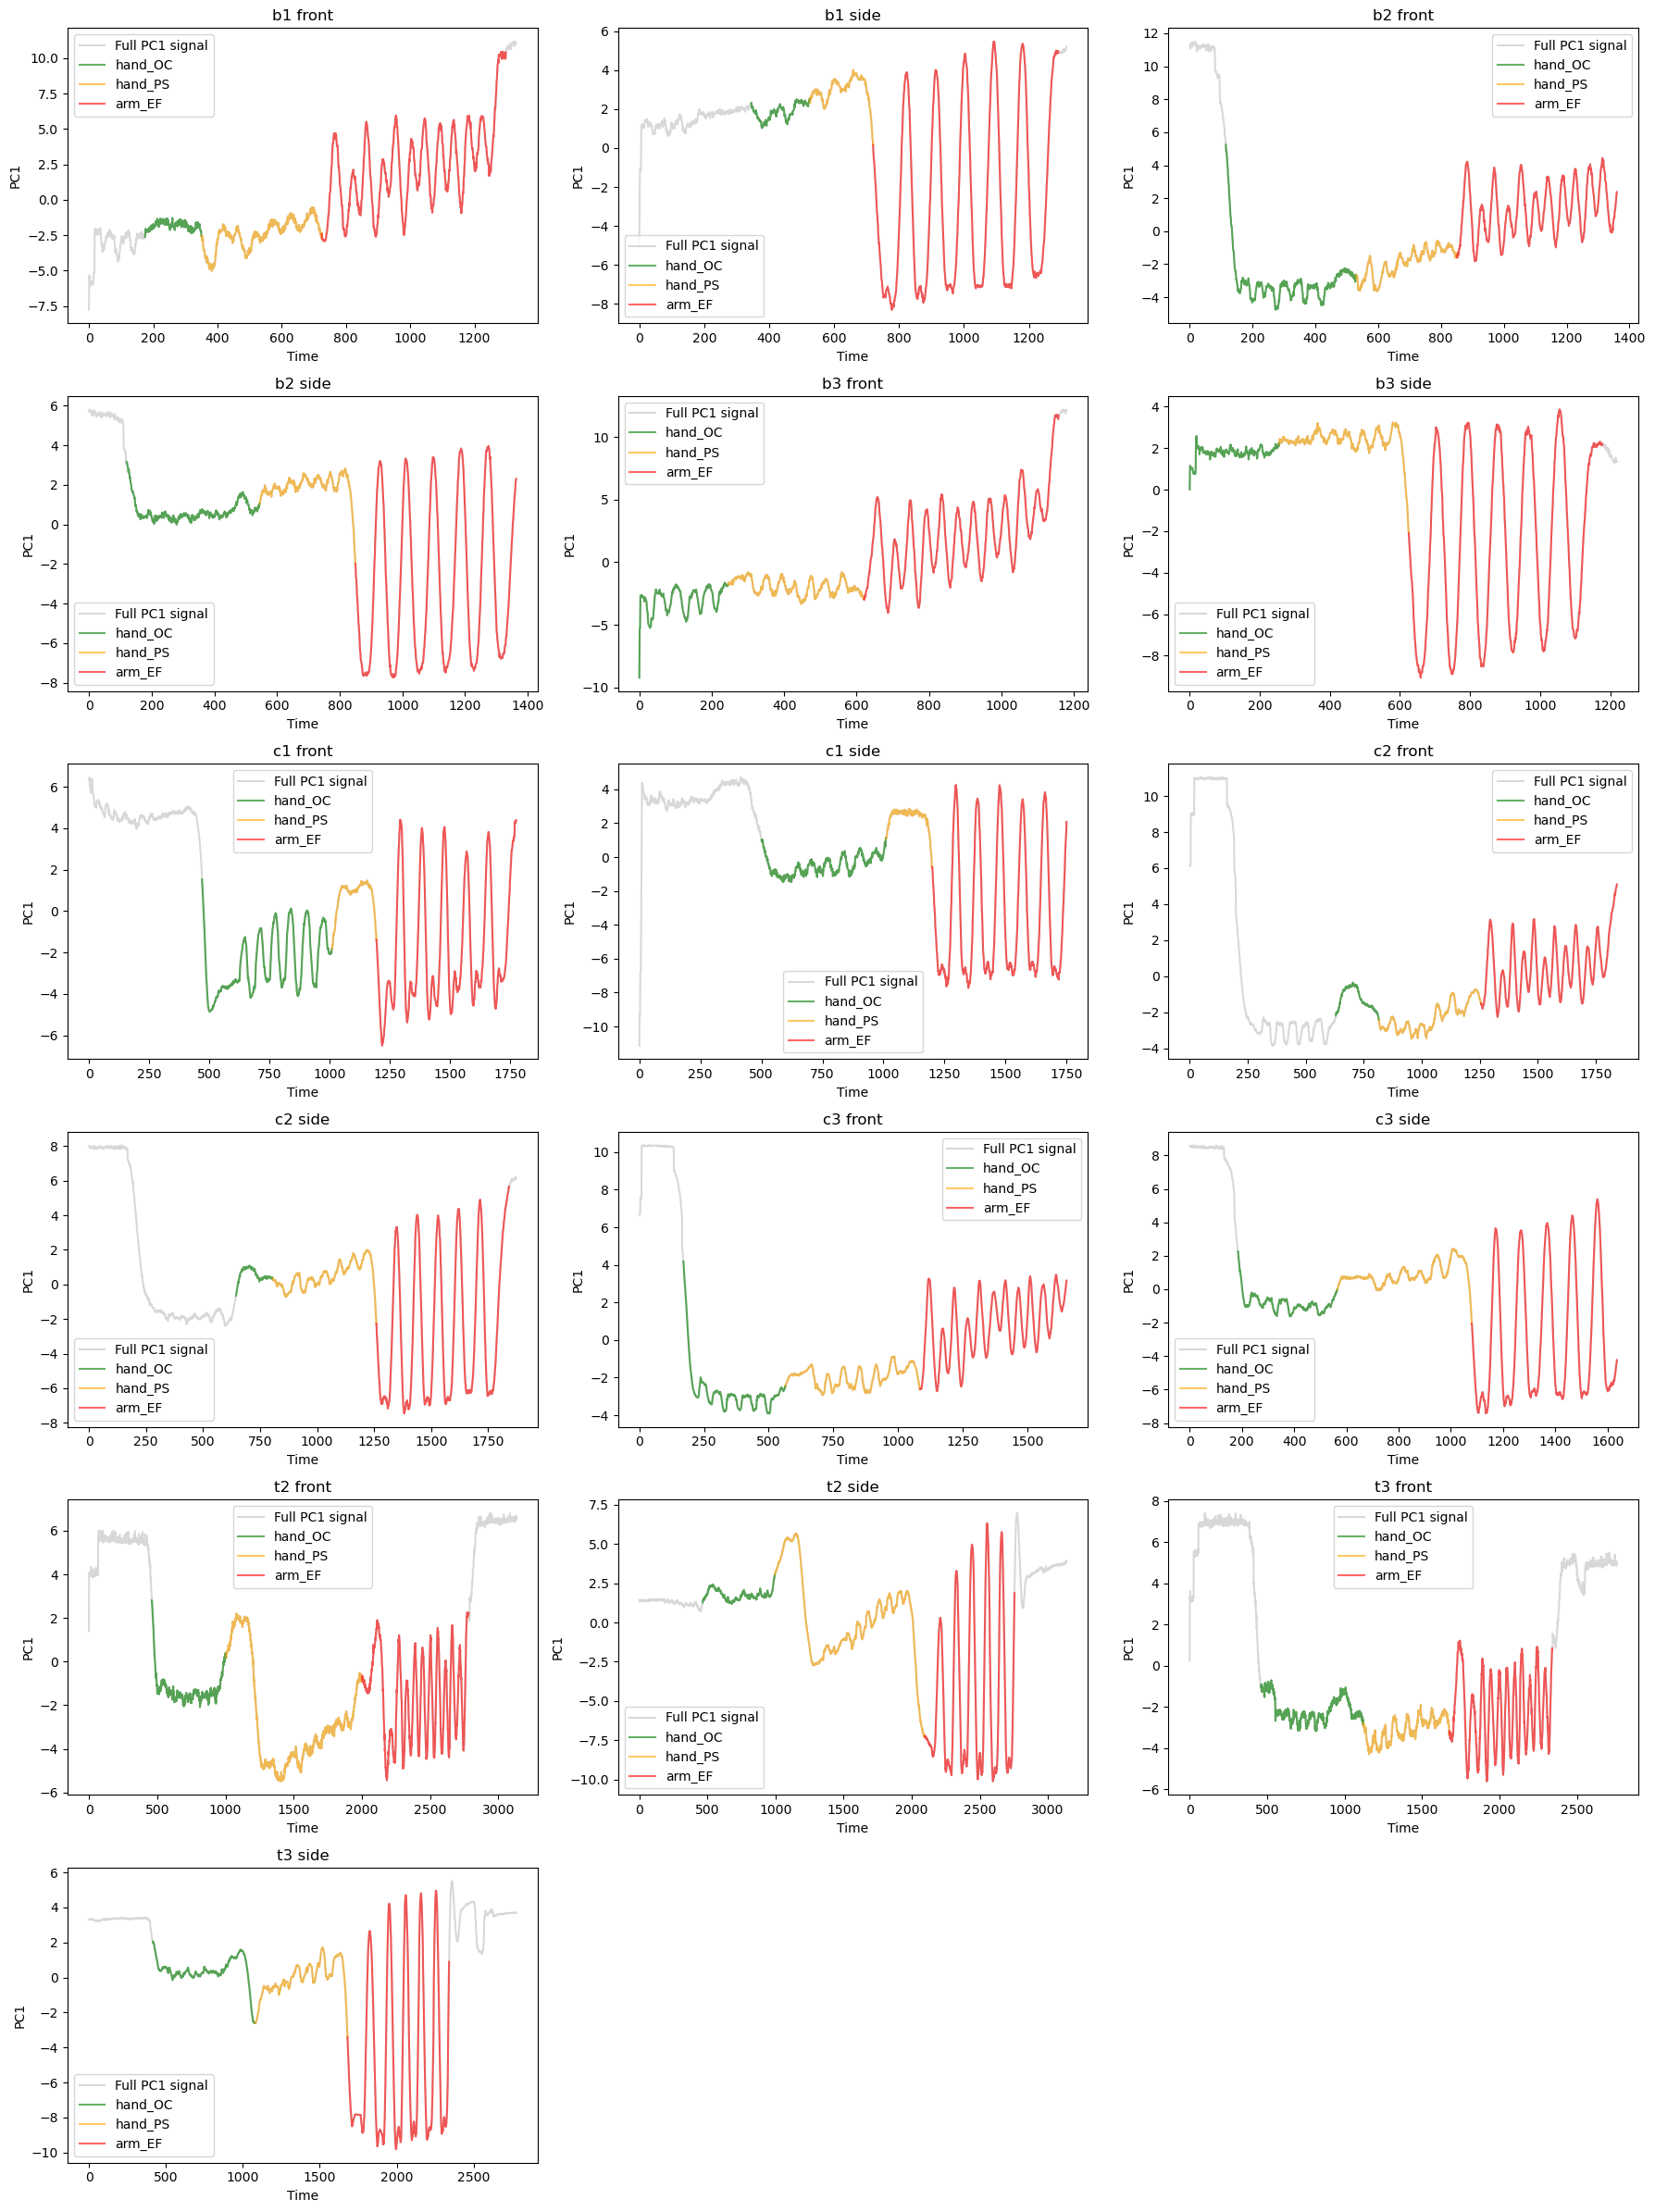

In [188]:
# Number of plots = number of rows in df_movements
num_plots = len(df_movements)

# Decide layout (e.g., 3 columns)
cols = 3
rows = (num_plots + cols - 1) // cols  # ceiling division

# Create subplots grid
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4), squeeze=False)

# Flatten axes for easy iteration
axes_flat = axes.flatten()

movement_colors = {
    'hand_OC': 'green',
    'hand_PS': 'orange',
    'arm_EF': 'red'
}

for idx, (row, ax) in enumerate(zip(df_movements.itertuples(), axes_flat)):
    dataset = row.dataset
    view = row.view

    df_key = dataset + ('f' if view == 'front' else 's')

    if df_key not in dataframes:
        print(f"Skipping {df_key} — data not found.")
        ax.axis('off')  # Hide empty subplot
        continue

    match = pca1_df[(pca1_df['depth'] == dataset) & (pca1_df['view'] == view)]
    if match.empty:
        print(f"No PC1 data found for depth={dataset}, view={view}")
        ax.axis('off')
        continue

    x = match['values'].iloc[0]
    t = np.arange(len(x))

    # Cast to int for slicing
    armEF_start, armEF_end = map(int, row.arm_EF)
    handOC_start, handOC_end = map(int, row.hand_OC)
    handPS_start, handPS_end = map(int, row.hand_PS)

    # Plot full PC1 signal lightly as background
    ax.plot(t, x, color='gray', alpha=0.3, label='Full PC1 signal')

    # Plot segments with inclusive slicing (end+1)
    ax.plot(t[handOC_start:handOC_end+1], x[handOC_start:handOC_end+1],
            color=movement_colors['hand_OC'], alpha=0.6, label='hand_OC')

    ax.plot(t[handPS_start:handPS_end+1], x[handPS_start:handPS_end+1],
            color=movement_colors['hand_PS'], alpha=0.6, label='hand_PS')

    ax.plot(t[armEF_start:armEF_end+1], x[armEF_start:armEF_end+1],
            color=movement_colors['arm_EF'], alpha=0.6, label='arm_EF')

    ax.set_title(f"{dataset} {view}")
    ax.set_xlabel("Time")
    ax.set_ylabel("PC1")
    ax.legend()

# Hide any unused subplots if num_plots < rows*cols
for j in range(num_plots, len(axes_flat)):
    axes_flat[j].axis('off')

plt.tight_layout()
plt.show()


## Getting peaks and troughs

In [91]:
df_movements

dataset   view        arm_EF      hand_OC       hand_PS
0      b1  front  (2375, 3265)  (467, 1420)  (1420, 2375)
1      c1  front  (2355, 3245)  (480, 1510)  (1510, 2355)
2      c2  front  (2255, 3240)  (520, 1155)  (1155, 2255)
3      c3  front  (2285, 3230)  (582, 1517)  (1517, 2285)
4      t3  front  (2330, 3225)  (650, 1255)  (1255, 2330)

In [189]:
# OPTIONAL: Drop existing computed columns if re-running (can get rid of this once pipeline is set)
cols_to_remove = [col for col in df_movements.columns if 'peaks' in col or 'troughs' in col or 'euclidean_dis' in col or 'arm_EF_data' in col]
df_movements = df_movements.drop(columns=cols_to_remove, errors='ignore')

# Recompute
results_df = df_movements.apply(compute_peaks_troughs, axis=1)
df_movements = pd.concat([df_movements, results_df], axis=1)


df_movements

dataset   view        arm_EF      hand_OC       hand_PS  \
0       b1  front   (725, 1298)   (175, 350)    (350, 725)   
1       b1   side   (720, 1291)   (345, 525)    (525, 720)   
2       b2  front   (850, 1361)   (115, 530)    (530, 850)   
3       b2   side   (850, 1364)   (120, 545)    (545, 850)   
4       b3  front   (620, 1158)     (0, 245)    (245, 620)   
5       b3   side   (625, 1177)     (0, 255)    (255, 625)   
6       c1  front  (1195, 1777)  (470, 1010)  (1010, 1195)   
7       c1   side  (1200, 1751)  (500, 1010)  (1010, 1200)   
8       c2  front  (1255, 1842)   (630, 815)   (815, 1255)   
9       c2   side  (1260, 1842)   (645, 805)   (805, 1260)   
10      c3  front  (1085, 1653)   (170, 565)   (565, 1085)   
11      c3   side  (1080, 1637)   (185, 565)   (565, 1080)   
12      t2  front  (2000, 2782)  (460, 1005)  (1005, 2000)   
13      t2   side  (2095, 2755)   (465, 995)   (995, 2095)   
14      t3  front  (1675, 2340)  (460, 1120)  (1120, 1675)   
15      t3   side  (1680, 2340)  (415, 1080)  (1080, 1680)   

                hand_OC_peaks                 hand_OC_troughs  \
0                          []                              []   
1                        None                            None   
2                          []                           [277]   
3                        None                            None   
4              [55, 101, 188]              [30, 78, 127, 210]   
5                        None                            None   
6   [646, 711, 775, 839, 906]  [506, 676, 741, 805, 870, 937]   
7                        None                            None   
8                       [706]                              []   
9                        None                            None   
10                         []                              []   
11                       None                            None   
12                 [724, 843]                 [525, 812, 875]   
13                       None                            None   
14                      [927]                          [1079]   
15                       None                            None   

                                hand_OC_euclidean_dis  \
0   [1.3247294683881492, 1.2725911971971497, 1.171...   
1                                                None   
2   [21.108636183822703, 20.99227150394321, 20.763...   
3                                                None   
4   [1.1240169260274369, 1.0933224758468632, 1.034...   
5                                                None   
6   [5.793110054522074, 5.7151376629888855, 5.5615...   
7                                                None   
8   [-4.199342376916477, -4.157291845549082, -4.07...   
9                                                None   
10  [19.96588250302674, 19.86788553791334, 19.6756...   
11                                               None   
12  [9.156954493044694, 9.07886391558334, 8.926020...   
13                                               None   
14  [-1.7700110771682955, -1.7592149740866498, -1....   
15                                               None   

                     hand_PS_peaks                       hand_PS_troughs  \
0                       [543, 668]                                 [573]   
1                             None                                  None   
2        [644, 687, 730, 769, 817]                  [666, 711, 751, 788]   
3                             None                                  None   
4        [368, 448, 492, 538, 590]             [346, 391, 474, 515, 562]   
5                             None                                  None   
6                           [1148]                                    []   
7                             None                                  None   
8          [910, 1033, 1099, 1223]                [871, 940, 1064, 1129]   
9                             None                                  None   
10      [758, 820, 882, 947, 1014]  

## Viewing peaks and troughs

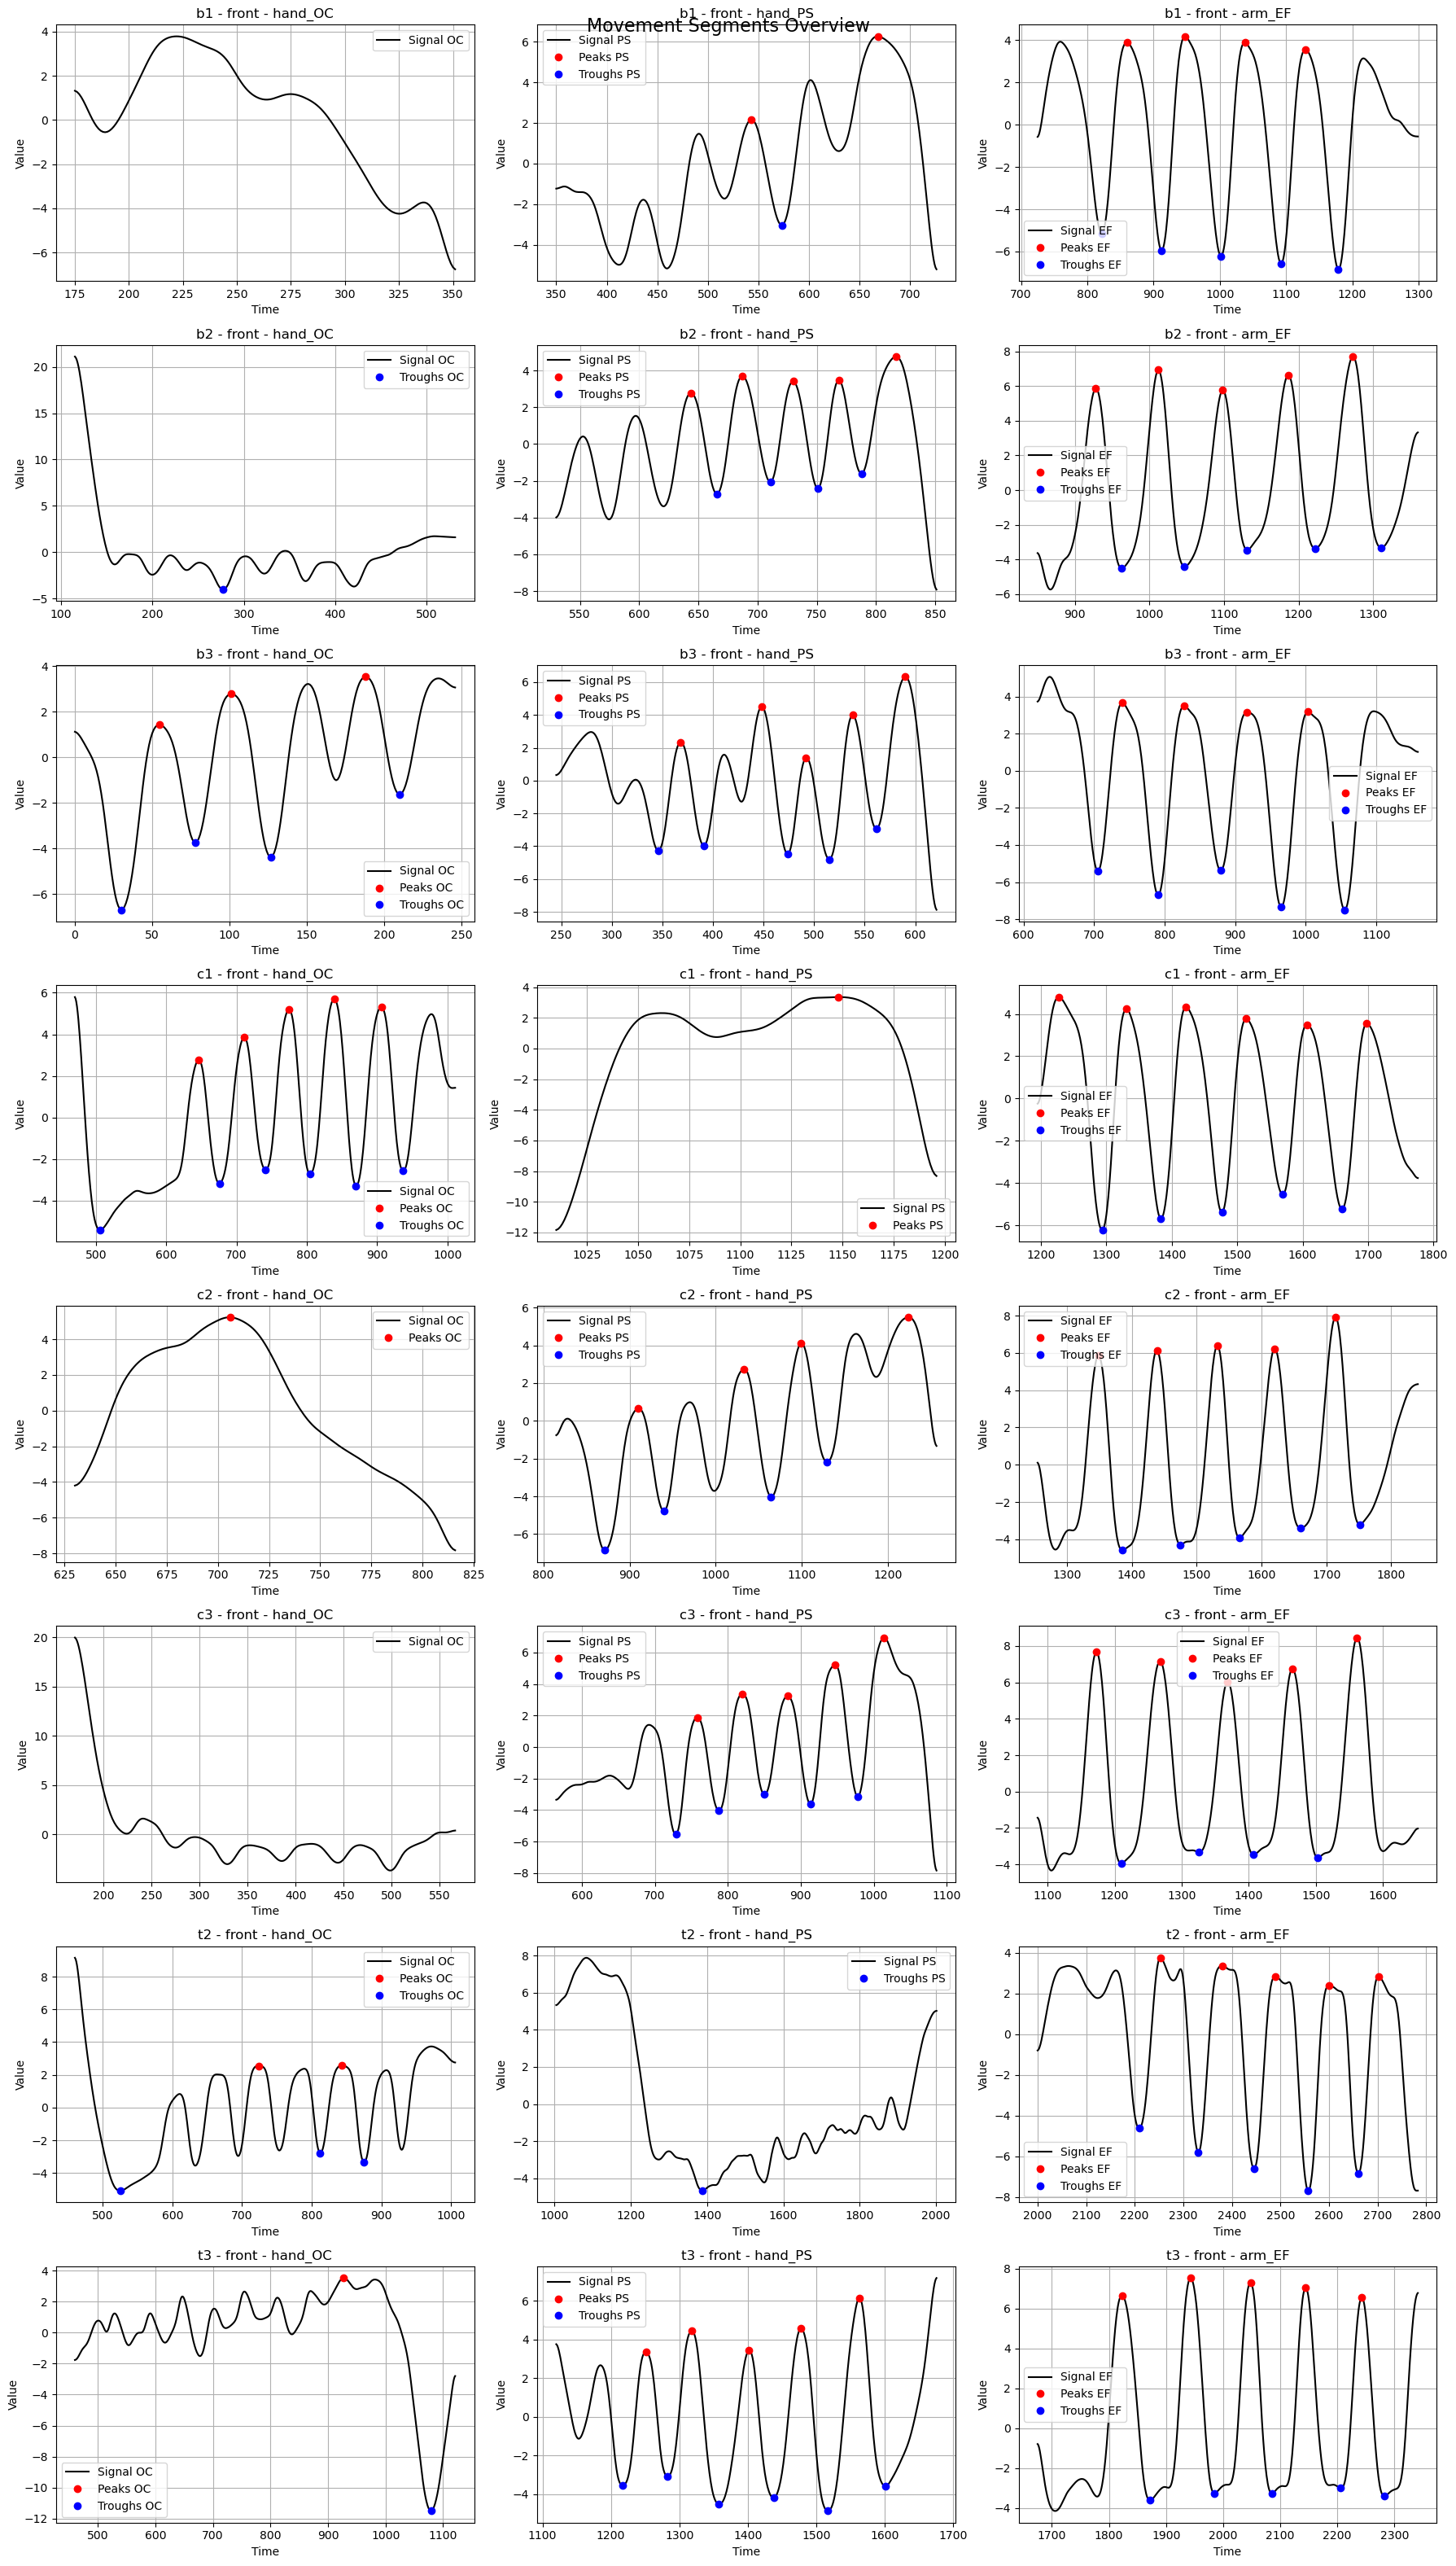

In [190]:
def plot_segment(ax, t, data, peaks=None, troughs=None, label_suffix=""):
    ax.plot(t, data, label=f'Signal {label_suffix}', color='black')

    peaks = np.atleast_1d(peaks)
    if peaks.size > 0 and not np.all(pd.isna(peaks)):
        ax.plot(peaks, np.interp(peaks, t, data), 'ro', label=f'Peaks {label_suffix}')

    troughs = np.atleast_1d(troughs)
    if troughs.size > 0 and not np.all(pd.isna(troughs)):
        ax.plot(troughs, np.interp(troughs, t, data), 'bo', label=f'Troughs {label_suffix}')

num_plots = 0  # will count how many subplots we actually need

# Count how many subplots we'll create
for _, row in df_movements.iterrows():
    if row['hand_OC'] is not None:
        num_plots += 1
    elif row['view'] == 'front':
        if row['hand_PS'] is not None:
            num_plots += 1
        if row['arm_EF'] is not None:
            num_plots += 1

cols = 3
rows = ((num_plots + cols - 1) // cols) + 2  # add an extra row buffer

fig, axes = plt.subplots(rows, cols, figsize=(18, 4 * rows))
axes = axes.flatten()

plot_idx = 0  # index for axes

for idx, row in df_movements.iterrows():

    if row['hand_OC_euclidean_dis'] is None or len(row['hand_OC_euclidean_dis']) == 0:
        continue

    depth = row['dataset']
    view = row['view']

    df_key = depth + ('f')
    df_data = dataframes.get(df_key)
    if df_data is None:
        print(f"Data not found for {df_key} — Skipping")
        continue

    
    ax = axes[plot_idx]
    plot_idx += 1

    start, end = row['hand_OC']
    segment = row['hand_OC_euclidean_dis']
    tOC = np.arange(len(segment)) + start

    plot_segment(ax, tOC, segment,
                    peaks=row.get('hand_OC_peaks'),
                    troughs=row.get('hand_OC_troughs'),
                    label_suffix='OC')

    ax.set_title(f"{depth} - front - hand_OC")
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.grid(True)
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())

    # For front view, plot hand_PS and arm_EF on separate subplots if they exist

    if row['hand_PS'] is not None:
        ax = axes[plot_idx]
        plot_idx += 1

        start_ps, end_ps = row['hand_PS']
        segment = row['hand_PS_euclidean_dis']
        tPS = np.arange(len(segment)) + start_ps

        plot_segment(ax, tPS, segment,
                        peaks=row.get('hand_PS_peaks'),
                        troughs=row.get('hand_PS_troughs'),
                        label_suffix='PS')

        ax.set_title(f"{depth} - front - hand_PS")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.grid(True)
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

    if row['arm_EF'] is not None:
        ax = axes[plot_idx]
        plot_idx += 1

        start_ef, end_ef = row['arm_EF']
        segment = row['arm_EF_data']
        tEF = np.arange(len(segment)) + start_ef

        plot_segment(ax, tEF, segment,
                        peaks=row.get('arm_EF_peaks'),
                        troughs=row.get('arm_EF_troughs'),
                        label_suffix='EF')

        ax.set_title(f"{depth} - front - arm_EF")
        ax.set_xlabel("Time")
        ax.set_ylabel("Value")
        ax.grid(True)
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

# Remove unused axes
for j in range(plot_idx, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Movement Segments Overview", fontsize=16)
plt.subplots_adjust(top=0.5)
plt.tight_layout()
plt.show()


In [191]:
df_movements

dataset   view        arm_EF      hand_OC       hand_PS  \
0       b1  front   (725, 1298)   (175, 350)    (350, 725)   
1       b1   side   (720, 1291)   (345, 525)    (525, 720)   
2       b2  front   (850, 1361)   (115, 530)    (530, 850)   
3       b2   side   (850, 1364)   (120, 545)    (545, 850)   
4       b3  front   (620, 1158)     (0, 245)    (245, 620)   
5       b3   side   (625, 1177)     (0, 255)    (255, 625)   
6       c1  front  (1195, 1777)  (470, 1010)  (1010, 1195)   
7       c1   side  (1200, 1751)  (500, 1010)  (1010, 1200)   
8       c2  front  (1255, 1842)   (630, 815)   (815, 1255)   
9       c2   side  (1260, 1842)   (645, 805)   (805, 1260)   
10      c3  front  (1085, 1653)   (170, 565)   (565, 1085)   
11      c3   side  (1080, 1637)   (185, 565)   (565, 1080)   
12      t2  front  (2000, 2782)  (460, 1005)  (1005, 2000)   
13      t2   side  (2095, 2755)   (465, 995)   (995, 2095)   
14      t3  front  (1675, 2340)  (460, 1120)  (1120, 1675)   
15      t3   side  (1680, 2340)  (415, 1080)  (1080, 1680)   

                hand_OC_peaks                 hand_OC_troughs  \
0                          []                              []   
1                        None                            None   
2                          []                           [277]   
3                        None                            None   
4              [55, 101, 188]              [30, 78, 127, 210]   
5                        None                            None   
6   [646, 711, 775, 839, 906]  [506, 676, 741, 805, 870, 937]   
7                        None                            None   
8                       [706]                              []   
9                        None                            None   
10                         []                              []   
11                       None                            None   
12                 [724, 843]                 [525, 812, 875]   
13                       None                            None   
14                      [927]                          [1079]   
15                       None                            None   

                                hand_OC_euclidean_dis  \
0   [1.3247294683881492, 1.2725911971971497, 1.171...   
1                                                None   
2   [21.108636183822703, 20.99227150394321, 20.763...   
3                                                None   
4   [1.1240169260274369, 1.0933224758468632, 1.034...   
5                                                None   
6   [5.793110054522074, 5.7151376629888855, 5.5615...   
7                                                None   
8   [-4.199342376916477, -4.157291845549082, -4.07...   
9                                                None   
10  [19.96588250302674, 19.86788553791334, 19.6756...   
11                                               None   
12  [9.156954493044694, 9.07886391558334, 8.926020...   
13                                               None   
14  [-1.7700110771682955, -1.7592149740866498, -1....   
15                                               None   

                     hand_PS_peaks                       hand_PS_troughs  \
0                       [543, 668]                                 [573]   
1                             None                                  None   
2        [644, 687, 730, 769, 817]                  [666, 711, 751, 788]   
3                             None                                  None   
4        [368, 448, 492, 538, 590]             [346, 391, 474, 515, 562]   
5                             None                                  None   
6                           [1148]                                    []   
7                             None                                  None   
8          [910, 1033, 1099, 1223]                [871, 940, 1064, 1129]   
9                             None                                  None   
10      [758, 820, 882, 947, 1014]  

## Creating new df and exporting all different start and stops

In [112]:
def safe_concat(series):
    series = series.dropna()
    combined = []
    for item in series:
        if isinstance(item, list):
            combined.extend(item)
        elif isinstance(item, np.ndarray):
            combined.extend(item.tolist())
        elif np.isscalar(item):
            combined.append(item)
    return combined


export_rows = []  # Collect rows as dictionaries here

for depth in df_movements['dataset'].unique():
    subset = df_movements[df_movements['dataset'] == depth]

    hand_OC_peaks = safe_concat(subset['hand_OC_peaks'])
    hand_OC_troughs = safe_concat(subset['hand_OC_troughs'])
    hand_PS_peaks = safe_concat(subset['hand_PS_peaks'])
    hand_PS_troughs = safe_concat(subset['hand_PS_troughs'])
    arm_EF_peaks = safe_concat(subset['arm_EF_peaks'])
    
    # Concatenate troughs like others but also adding the change point
    arm_EF_troughs = safe_concat(subset['arm_EF_troughs'])

    # Get the first index from 'arm_EF' 
    first_arm_EF_entry = subset['arm_EF'].iloc[0]
    first_index = first_arm_EF_entry[0]

    # append it to troughs
    arm_EF_troughs = [first_index] + arm_EF_troughs


    export_rows.append({
        'dataset': depth,
        'hand_OC_peaks': hand_OC_peaks,
        'hand_OC_troughs': hand_OC_troughs,
        'hand_PS_peaks': hand_PS_peaks,
        'hand_PS_troughs': hand_PS_troughs,
        'arm_EF_peaks': arm_EF_peaks,
        'arm_EF_troughs': arm_EF_troughs
    })

# Build df_export from the list of rows
df_export = pd.DataFrame(export_rows)


In [113]:
df_export

dataset                      hand_OC_peaks  \
0      b1  [600, 674, 807, 1009, 1121, 1301]   
1      c1  [682, 779, 895, 1006, 1122, 1234]   
2      c2         [679, 777, 888, 995, 1107]   
3      c3  [661, 789, 909, 1024, 1138, 1261]   
4      t3        [745, 846, 953, 1060, 1168]   

                    hand_OC_troughs                   hand_PS_peaks  \
0       [641, 743, 854, 1065, 1170]  [1539, 1693, 1838, 1982, 2111]   
1  [636, 735, 843, 942, 1053, 1177]  [1585, 1692, 1798, 1911, 2023]   
2        [619, 727, 837, 942, 1053]  [1490, 1636, 1773, 1902, 2022]   
3       [718, 850, 960, 1079, 1197]  [1580, 1732, 1852, 1979, 2097]   
4      [793, 896, 1003, 1109, 1221]        [1462, 1865, 1971, 2074]   

                  hand_PS_troughs                          arm_EF_peaks  \
0  [1616, 1762, 1900, 2044, 2175]        [2513, 2660, 2806, 2949, 3094]   
1  [1628, 1739, 1843, 1953, 2068]        [2485, 2629, 2773, 2921, 3063]   
2  [1570, 1699, 1829, 1959, 2097]        [2418, 2575, 2735, 2888, 3029]   
3  [1671, 1795, 1925, 2042, 2161]        [2436, 2593, 2744, 2890, 3033]   
4              [1834, 1932, 2033]  [2394, 2532, 2681, 2821, 2965, 3106]   

                         arm_EF_troughs  
0  [2375, 2566, 2759, 2862, 3003, 3145]  
1  [2355, 2580, 2682, 2827, 2974, 3117]  
2  [2255, 2480, 2638, 2795, 2941, 3085]  
3  [2285, 2493, 2650, 2801, 2946, 3092]  
4  [2330, 2446, 2585, 2736, 2876, 3019]

In [114]:
# Assuming df_export already exists and has concatenated peaks/troughs per depth
movement_types = ['hand_OC', 'hand_PS', 'arm_EF']

# Dictionary to hold DataFrames for each depth
depth_dfs = {}

# Output folder
output_folder = 'exported_movements'
os.makedirs(output_folder, exist_ok=True)

for idx, row in df_export.iterrows():
    depth = row['dataset']
    movement_data = []

    for movetype in movement_types:
        peaks = row[f'{movetype}_peaks']
        troughs = row[f'{movetype}_troughs']

        # Skip if peaks or troughs length <= 1
        if len(peaks) <= 1 or len(troughs) <= 1:
            continue

        # Ensure equal length for pairing (truncate to shortest length)
        pair_count = min(len(peaks), len(troughs))

        for i in range(pair_count):
            if movetype == 'hand_PS':
                movement_data.append({
                    'dataset': depth,
                    'movetype': movetype,
                    'moveN': i + 1,
                    'BeginF': peaks[i],
                    'EndF': troughs[i]
                })
            else:
                movement_data.append({
                    'dataset': depth,
                    'movetype': movetype,
                    'moveN': i + 1,
                    'BeginF': troughs[i],
                    'EndF': peaks[i]
                })

    # Create DataFrame for this depth and add to dictionary
    depth_df = pd.DataFrame(movement_data)
    depth_dfs[depth] = depth_df

    # Export as CSV
    depth_df.to_csv(os.path.join(output_folder, f'{depth}_movements.csv'), index=False)

print(f"Exported {len(depth_dfs)} depth CSV files to folder: {output_folder}")


Exported 5 depth CSV files to folder: exported_movements


In [ ]:
# things to now calculate for each movement
    # amplitude
    # distance between peaks
    # lag? --> maybe reread those papers
    ### mean distance between each peak for each movement
    # peak width
    # speed
    # duration

### one paper did a box and whisker plot of all the period frames with the finger tapping and this showed a severity of a tremor score I think --> i wonder if we can do this or there is any relevance here?
### also from that one paper
# mean freq of actions
# coefficient of variation of the freq of actions (std/mean)
# average velocities between peaks and troughs
# coefficient of variation of the velocities between peaks and troughs
# mean amplitude of actions
# coefficient of variation of the amplitudes of actions 

##### can these then correlate with the MDS UDS ratings/scale?!?!!?